### This is an Exercise on the Linear Regression With Time series

In [308]:
# Setup notebook
from pathlib import Path
from warnings import simplefilter
from statsmodels.tsa.deterministic import DeterministicProcess

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.dates as mdates


data_dir = Path('./data/')
comp_dir = Path('./data/store-sales-time-series-forecasting/')

book_sales = pd.read_csv(
    data_dir / 'book_sales.csv',
    index_col='Date',
    parse_dates=['Date'],
).drop('Paperback', axis=1)
book_sales['Time'] = np.arange(len(book_sales.index))
book_sales['Lag_1'] = book_sales['Hardcover'].shift(1)
book_sales = book_sales.reindex(columns=['Hardcover', 'Time', 'Lag_1'])

ar = pd.read_csv(data_dir / 'ar.csv')

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

One advantage linear regression has over more complicated algorithms is that the models it creates are explainable -- it's easy to interpret what contribution each feature makes to the predictions. In the model target = weight * feature + bias, the weight tells you by how much the target changes on average for each unit of change in the feature.

The next cell to give a linear regression on Hardcover Sales.

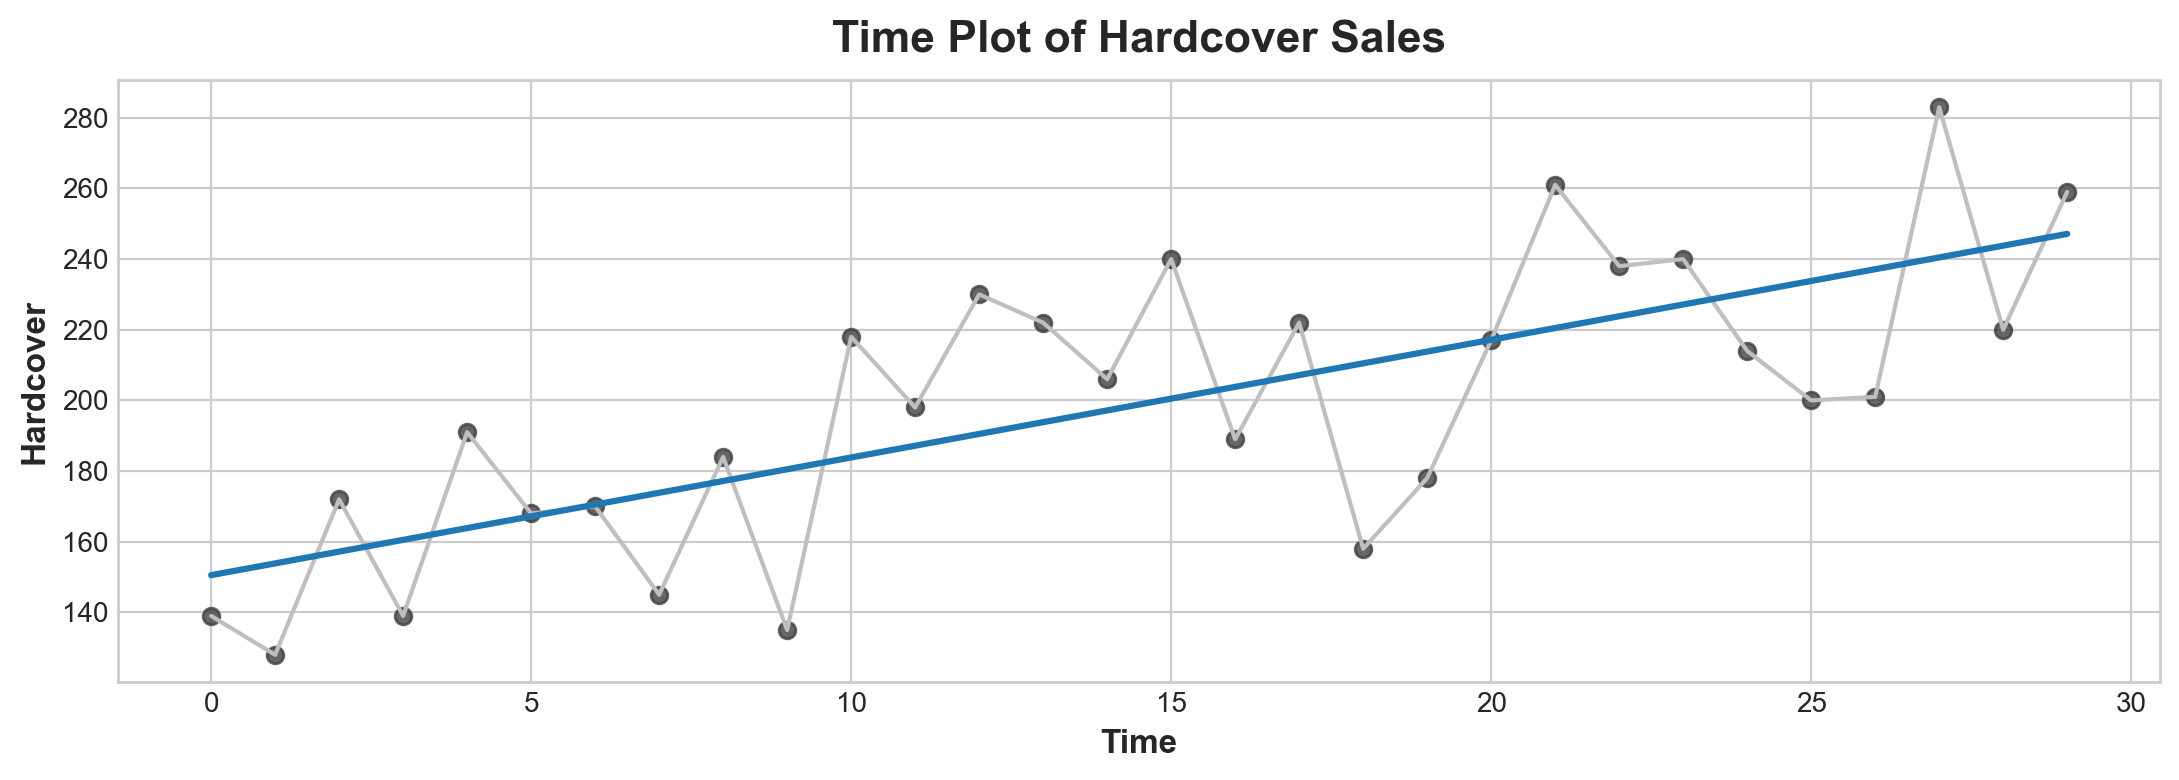

In [309]:
fig, ax = plt.subplots()
ax.plot('Time', 'Hardcover', data=book_sales, color='0.75')
ax = sns.regplot(x='Time', y='Hardcover', data=book_sales, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Hardcover Sales');

Interpreting the regression coefficients can help us recognize serial dependence in a time plot. Consider the model `target = weight * lag_1 + error`, where error is random noise and weight is a number between -1 and 1. The weight in this case tells you how likely the next time step will have the same sign as the previous time step: a weight close to 1 means target will likely have the same sign as the previous step, while a weight close to -1 means target will likely have the opposite sign.

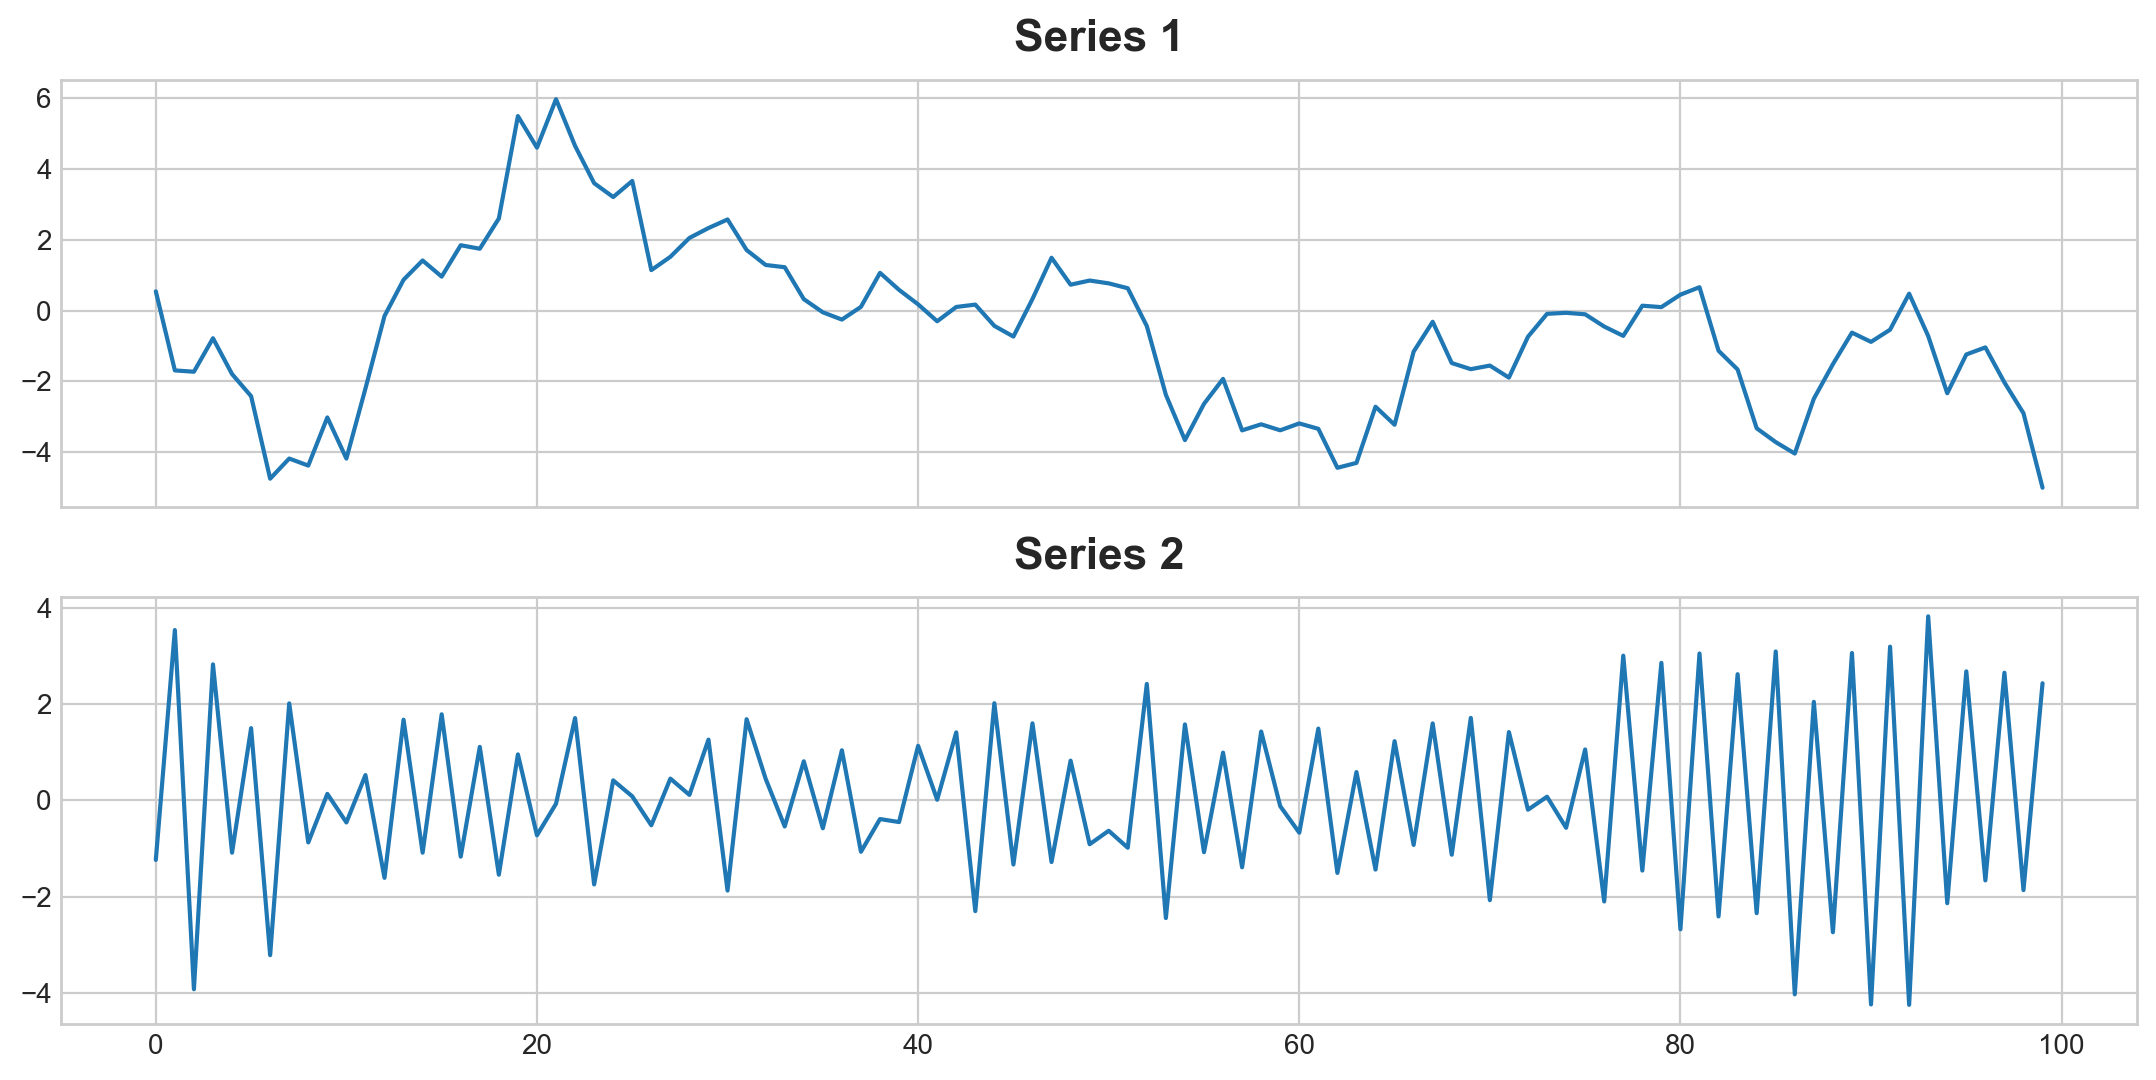

In [310]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(11, 5.5), sharex=True)
ax1.plot(ar['ar1'])
ax1.set_title('Series 1')
ax2.plot(ar['ar2'])
ax2.set_title('Series 2');

In [311]:
average_sales

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
                 ...    
2017-08-11    463.733856
2017-08-12    444.798279
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 1684, dtype: float32

In [312]:
from sklearn.linear_model import LinearRegression

df = average_sales.to_frame()

time = np.arange(len(df.index)) # time dummy

df['time'] = time 

# Create training data
X = df.loc[:, ['time']]  # features
y = df.loc[:, 'sales']  # target

# Train the model
model = LinearRegression()
model.fit(X, y)

# Store the fitted values as a time series with the same time index as
# the training data
y_pred = pd.Series(model.predict(X), index=X.index)

# Regression line
intercept = model.intercept_
coef = model.coef_

print(model.score(X, y), model.intercept_, model.coef_)
line = coef * X + intercept

0.5161529764383439 194.23279019701053 [0.19434695]


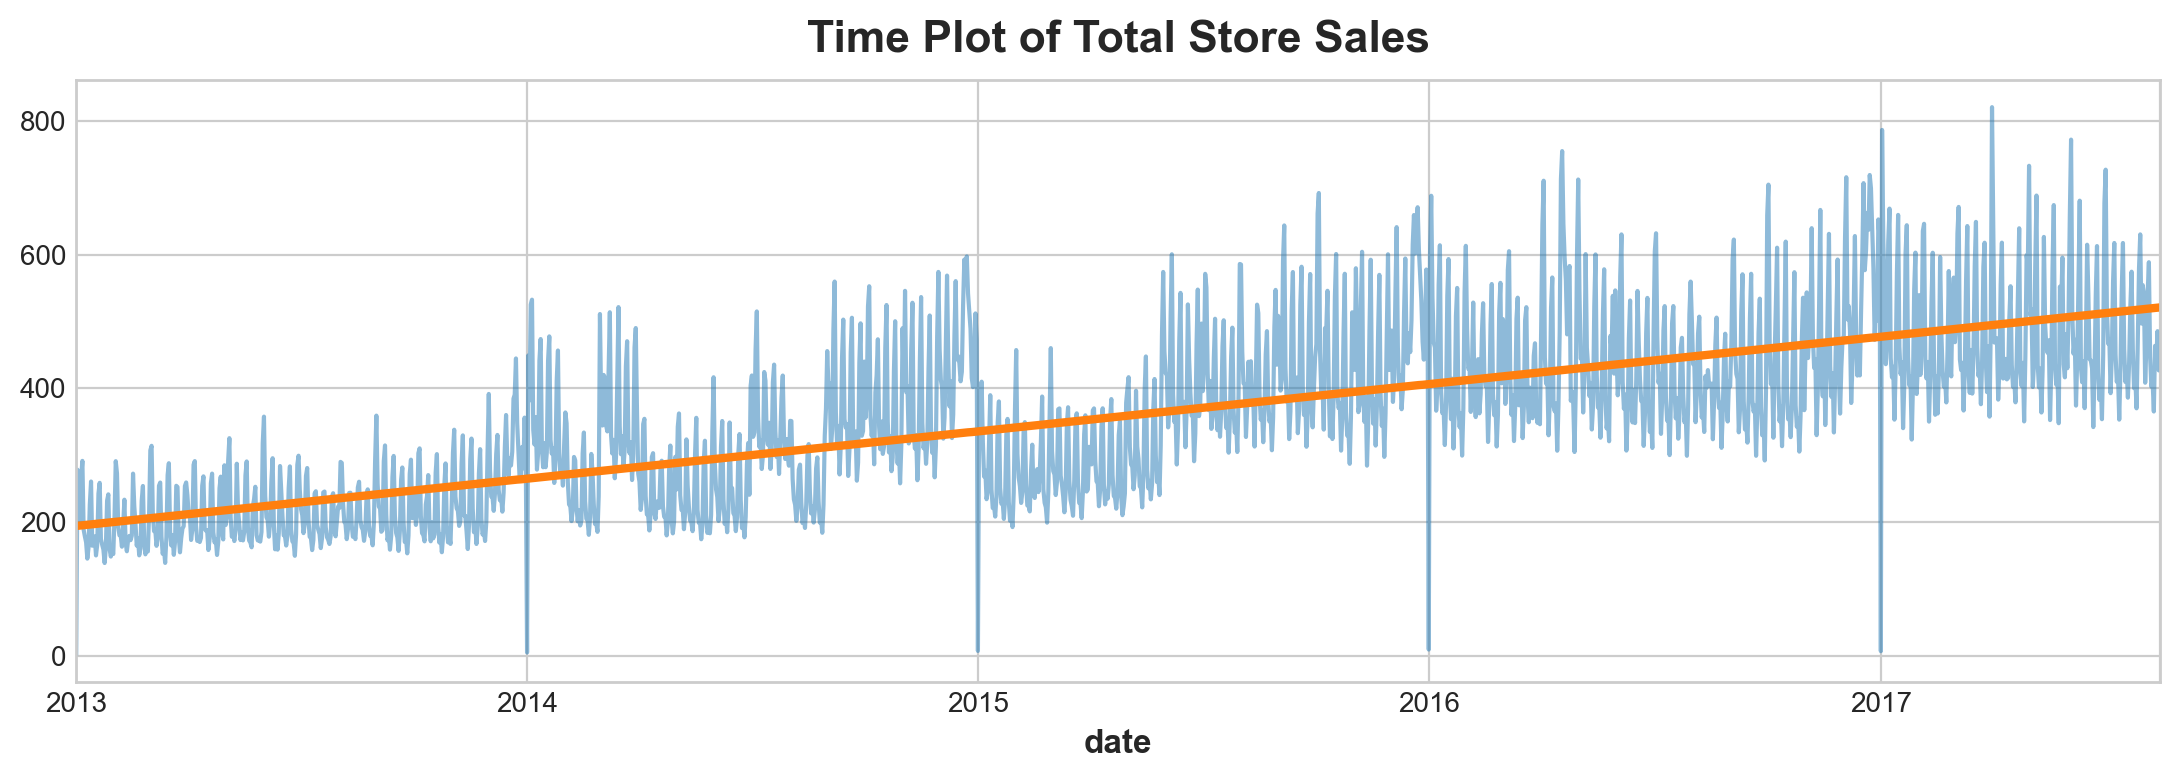

In [313]:
# Visualization 
ax = y.plot(alpha=0.5)
ax = y_pred.plot(ax=ax, linewidth=3)
ax.set_title('Time Plot of Total Store Sales');

In [314]:
df

sales  time
date                        
2013-01-01    1.409438     0
2013-01-02  278.390808     1
2013-01-03  202.840195     2
2013-01-04  198.911148     3
2013-01-05  267.873230     4
...                ...   ...
2017-08-11  463.733856  1679
2017-08-12  444.798279  1680
2017-08-13  485.768616  1681
2017-08-14  427.004730  1682
2017-08-15  427.980896  1683

[1684 rows x 2 columns]

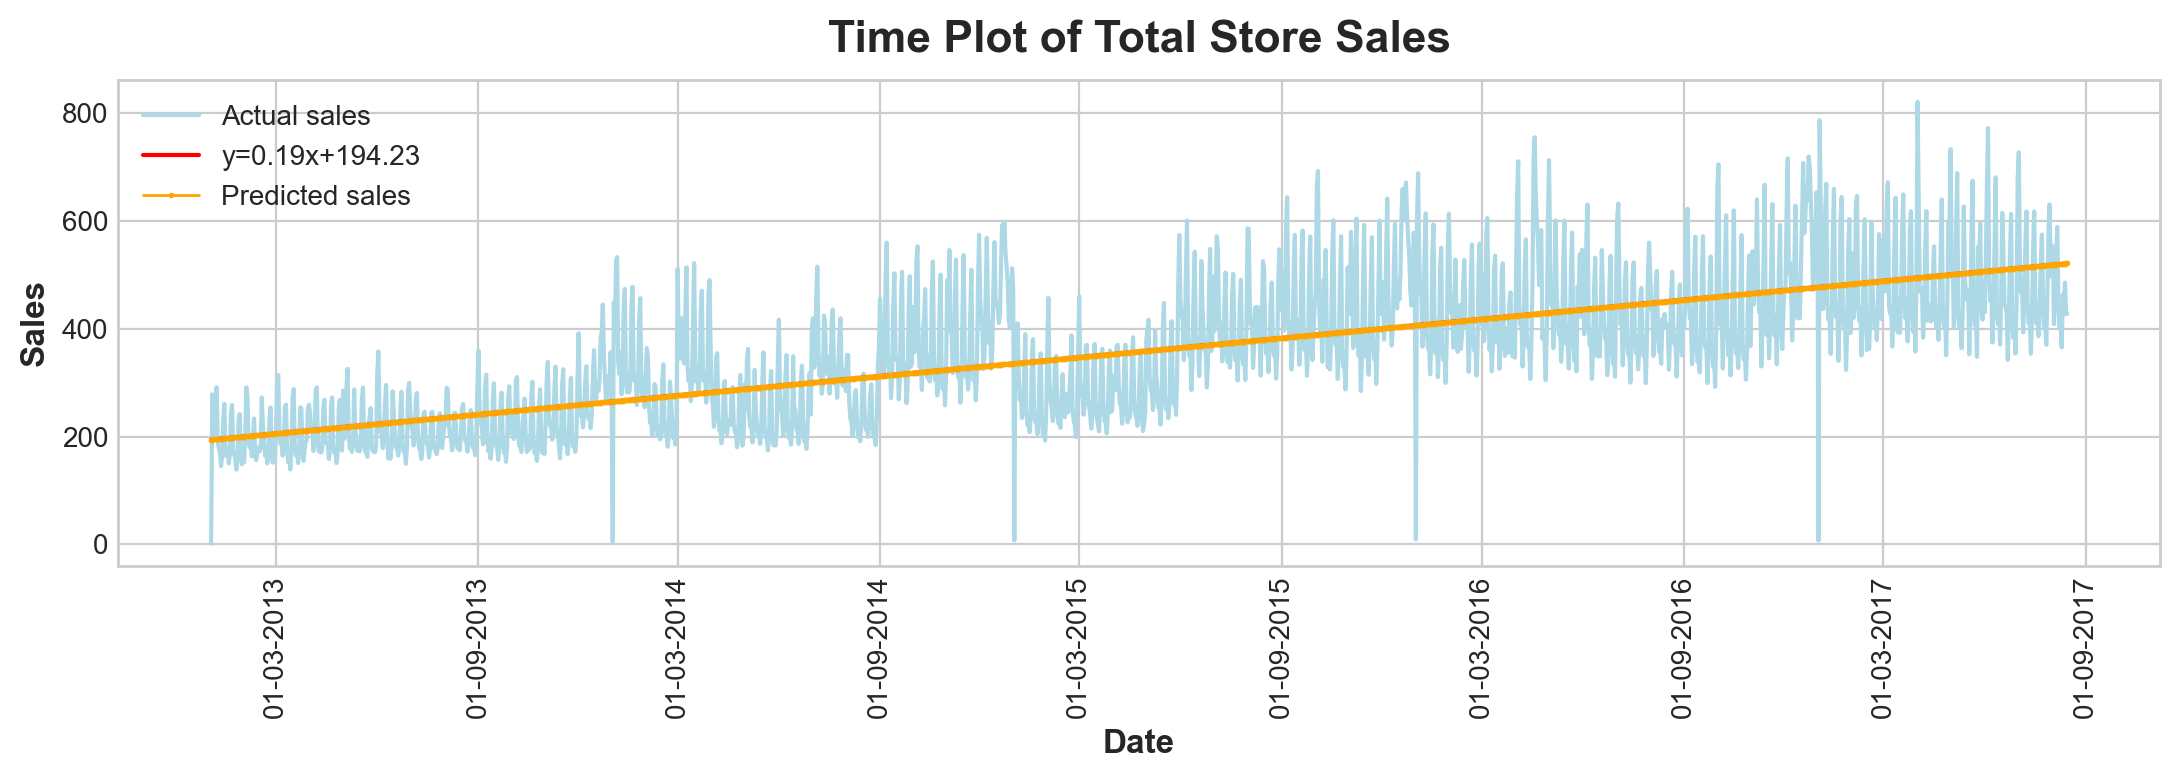

In [315]:
# This blocks constructs a figure with data series `plot_date`

fig, ax = plt.subplots()
ax.plot_date(X.index, y, 'lightblue', label = 'Actual sales')
plt.plot_date(X.index, line, 'r', label='y={:.2f}x+{:.2f}'.format(float(coef), intercept)) # This is a line created from Linear Regression Equation
ax.plot_date(X.index, y_pred, color='orange', linewidth=1, label = 'Predicted sales', linestyle='-', markersize=1)
ax.set_ylabel('Sales')
ax.set_xlabel('Date')
# set monthly locator
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=6))
# set formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.xticks(rotation=90)
ax.set_title('Time Plot of Total Store Sales')
plt.legend();

## Trends 
### Moving Average Plots
To see what kind of trend a time series might have, we can use a moving average plot. To compute a moving average of a time series, we compute the average of the values within a sliding window of some defined width. Each point on the graph represents the average of all the values in the series that fall within the window on either side. The idea is to smooth out any short-term fluctuations in the series so that only long-term changes remain.

Let's create a trend for the Tunnel Traffic dataset

In [316]:
simplefilter("ignore")  # ignore warnings to clean up output cells

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 5))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=True,
)
%config InlineBackend.figure_format = 'retina'


# Load Tunnel Traffic dataset
data_dir = Path("./data")
tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period()

In [317]:
tunnel

NumVehicles
Day                    
2003-11-01       103536
2003-11-02        92051
2003-11-03       100795
2003-11-04       102352
2003-11-05       106569
...                 ...
2005-11-12       104646
2005-11-13        94424
2005-11-14       112165
2005-11-15       114296
2005-11-16       114690

[747 rows x 1 columns]

Let's make a moving average plot to see what kind of trend this series has. Since this series has daily observations, let's choose a window of 365 days to smooth over any short-term changes within the year.

To create a moving average, first use the `rolling` method to begin a windowed computation. Follow this by the `mean` method to compute the average over the window. As we can see, the trend of Tunnel Traffic appears to be about linear.

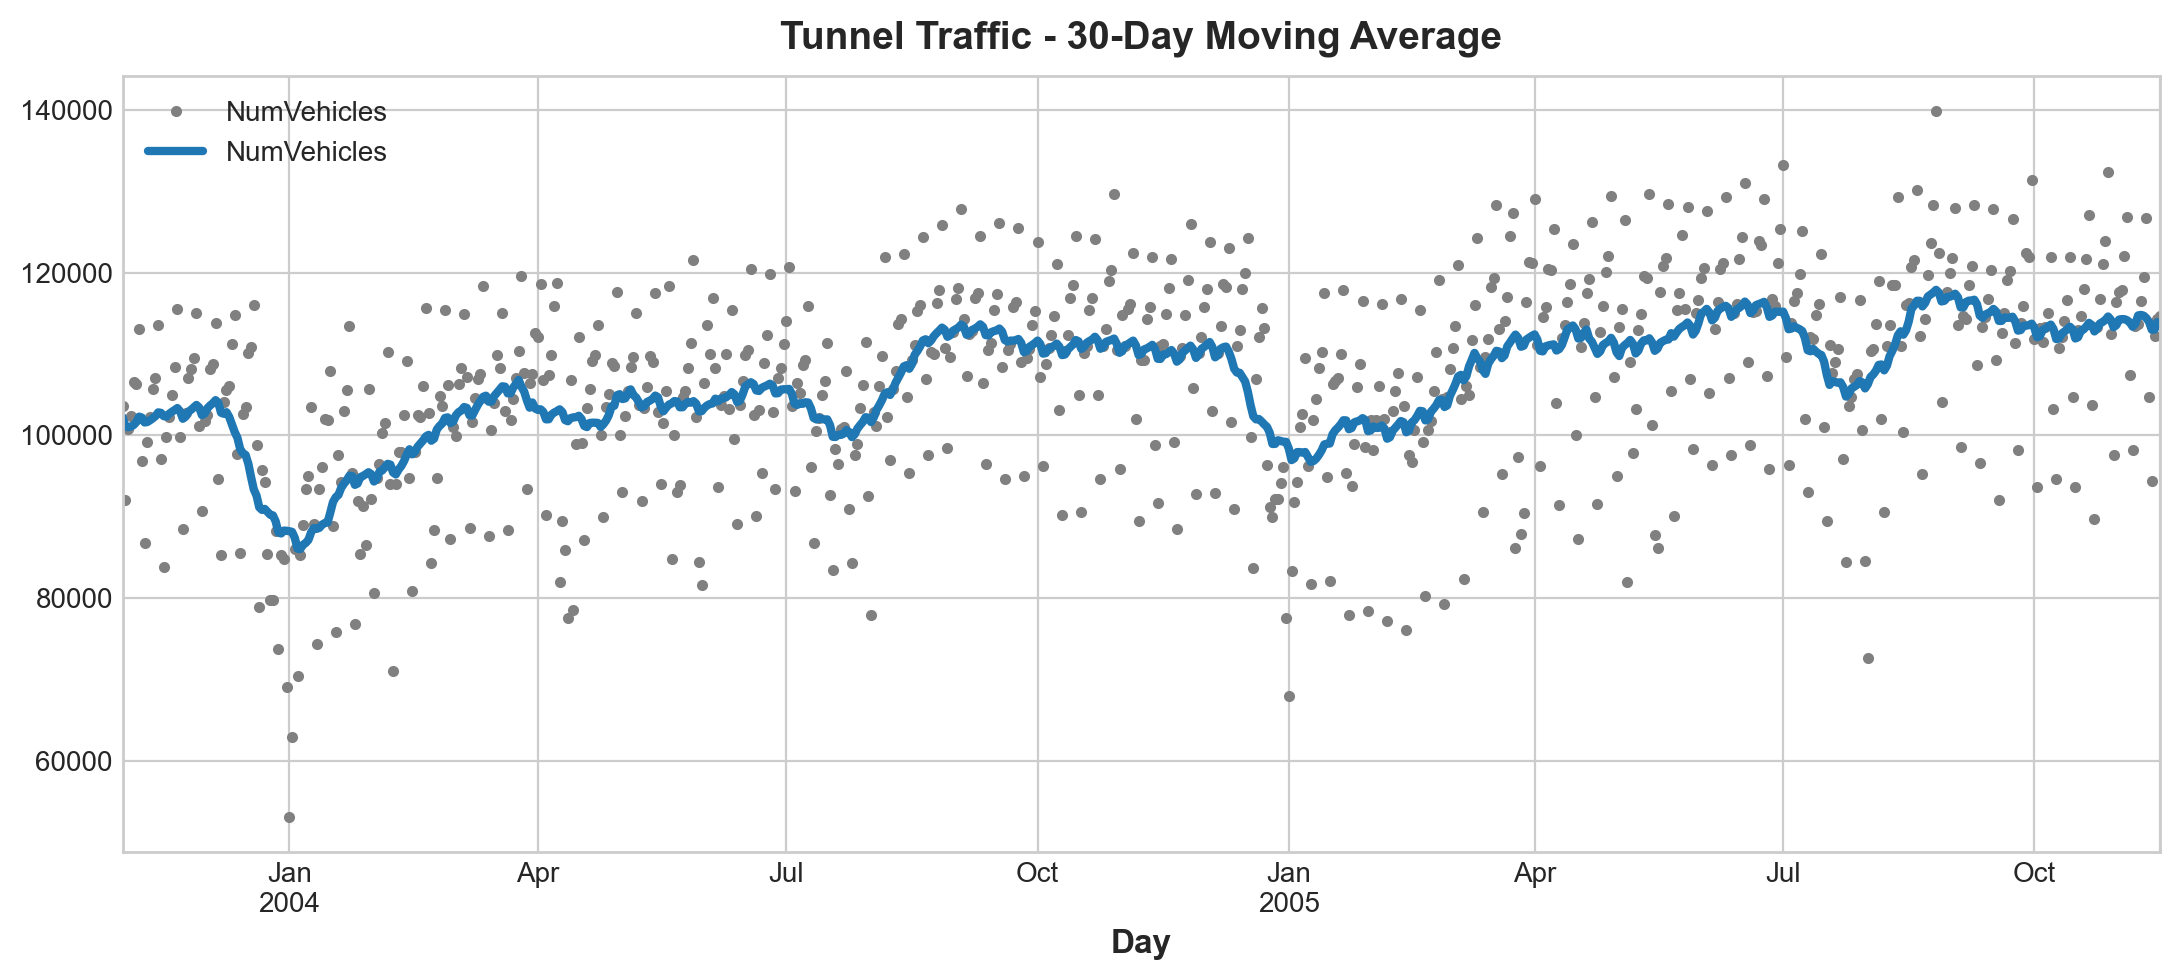

In [318]:
moving_average = tunnel.rolling(
    window=30,       # 30-day window
    center=True,      # puts the average at the center of the window
    min_periods=10,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = tunnel.plot(style=".", color="0.5", label = 'Number of Cars')
moving_average.plot(
     ax=ax, linewidth=3, title="Tunnel Traffic - 30-Day Moving Average", label='Average',
);

Earlier we engineered our time dummy in Pandas directly. From now on, however, we'll use a function from the statsmodels library called `DeterministicProcess`. Using this function will help us avoid some tricky failure cases that can arise with time series and linear regression. The order argument refers to polynomial order: 1 for linear, 2 for quadratic, 3 for cubic, and so on.

In [319]:
dp = DeterministicProcess(
    index=tunnel.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=1,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)
# `in_sample` creates features for the dates given in the `index` argument

X = dp.in_sample()

X

const  trend
Day                     
2003-11-01    1.0    1.0
2003-11-02    1.0    2.0
2003-11-03    1.0    3.0
2003-11-04    1.0    4.0
2003-11-05    1.0    5.0
...           ...    ...
2005-11-12    1.0  743.0
2005-11-13    1.0  744.0
2005-11-14    1.0  745.0
2005-11-15    1.0  746.0
2005-11-16    1.0  747.0

[747 rows x 2 columns]

(A deterministic process, by the way, is a technical term for a time series that is non-random or completely determined, like the const and trend series are. Features derived from the time index will generally be deterministic.)

We create our trend model basically as before, though note the addition of the `fit_intercept=False` argument.

In [320]:
y = tunnel["NumVehicles"]  # the target

# The intercept is the same as the `const` feature from
# DeterministicProcess. LinearRegression behaves badly with duplicated
# features, so we need to be sure to exclude it here.
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_pred

Day
2003-11-01     98176.206344
2003-11-02     98198.703794
2003-11-03     98221.201243
2003-11-04     98243.698693
2003-11-05     98266.196142
                  ...      
2005-11-12    114869.313898
2005-11-13    114891.811347
2005-11-14    114914.308797
2005-11-15    114936.806247
2005-11-16    114959.303696
Freq: D, Length: 747, dtype: float64

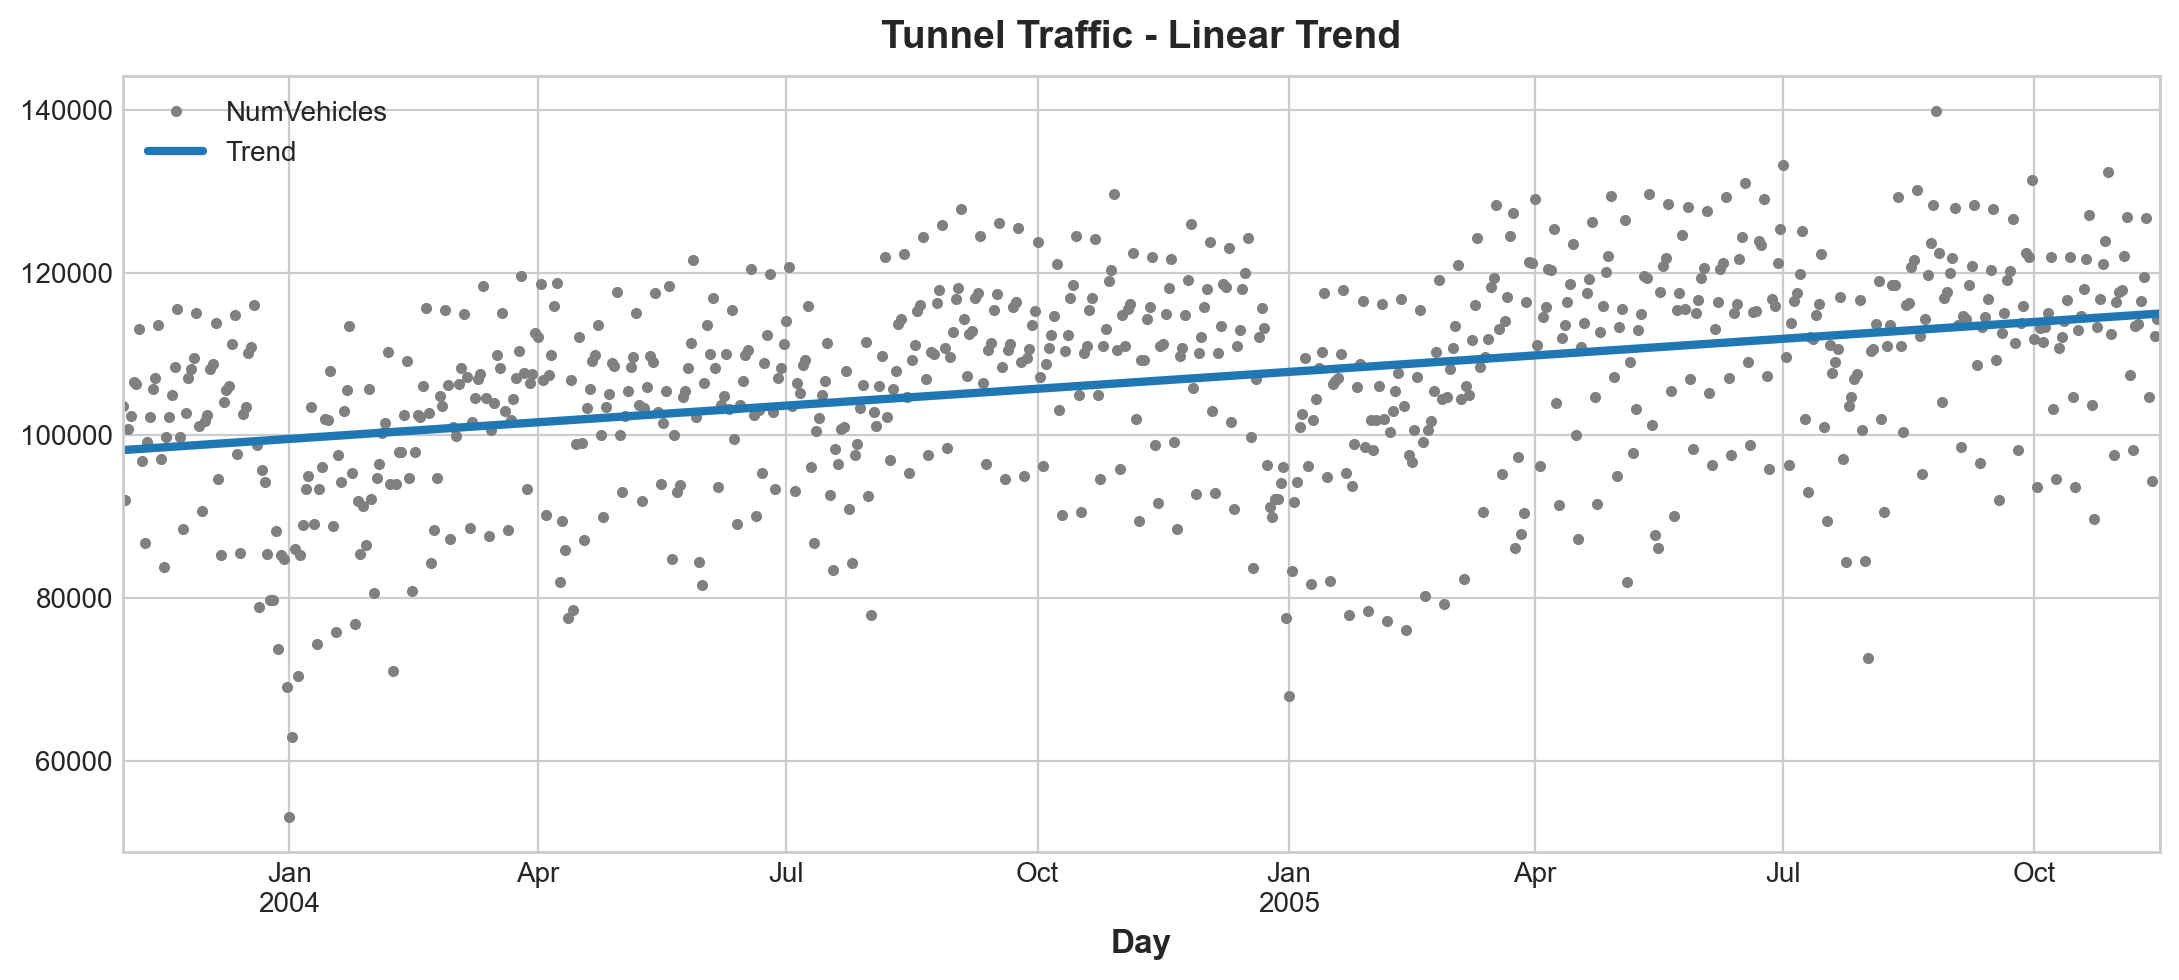

In [321]:
ax = tunnel.plot(style=".", color="0.5", title="Tunnel Traffic - Linear Trend")
_ = y_pred.plot(ax=ax, linewidth=3, label="Trend")
_ = ax.legend()


The trend discovered by our LinearRegression model is almost identical to the moving average plot, which suggests that a linear trend was the right decision in this case.
To make a forecast, we apply our model to "out of sample" features. "Out of sample" refers to times outside of the observation period of the training data. Here's how we could make a 30-day forecast:

In [322]:
X = dp.out_of_sample(steps=30)

y_fore = pd.Series(model.predict(X), index=X.index)

y_fore.head()

2005-11-17    114981.801146
2005-11-18    115004.298595
2005-11-19    115026.796045
2005-11-20    115049.293494
2005-11-21    115071.790944
Freq: D, dtype: float64

Let's plot a portion of the series to see the trend forecast for the next 30 days:

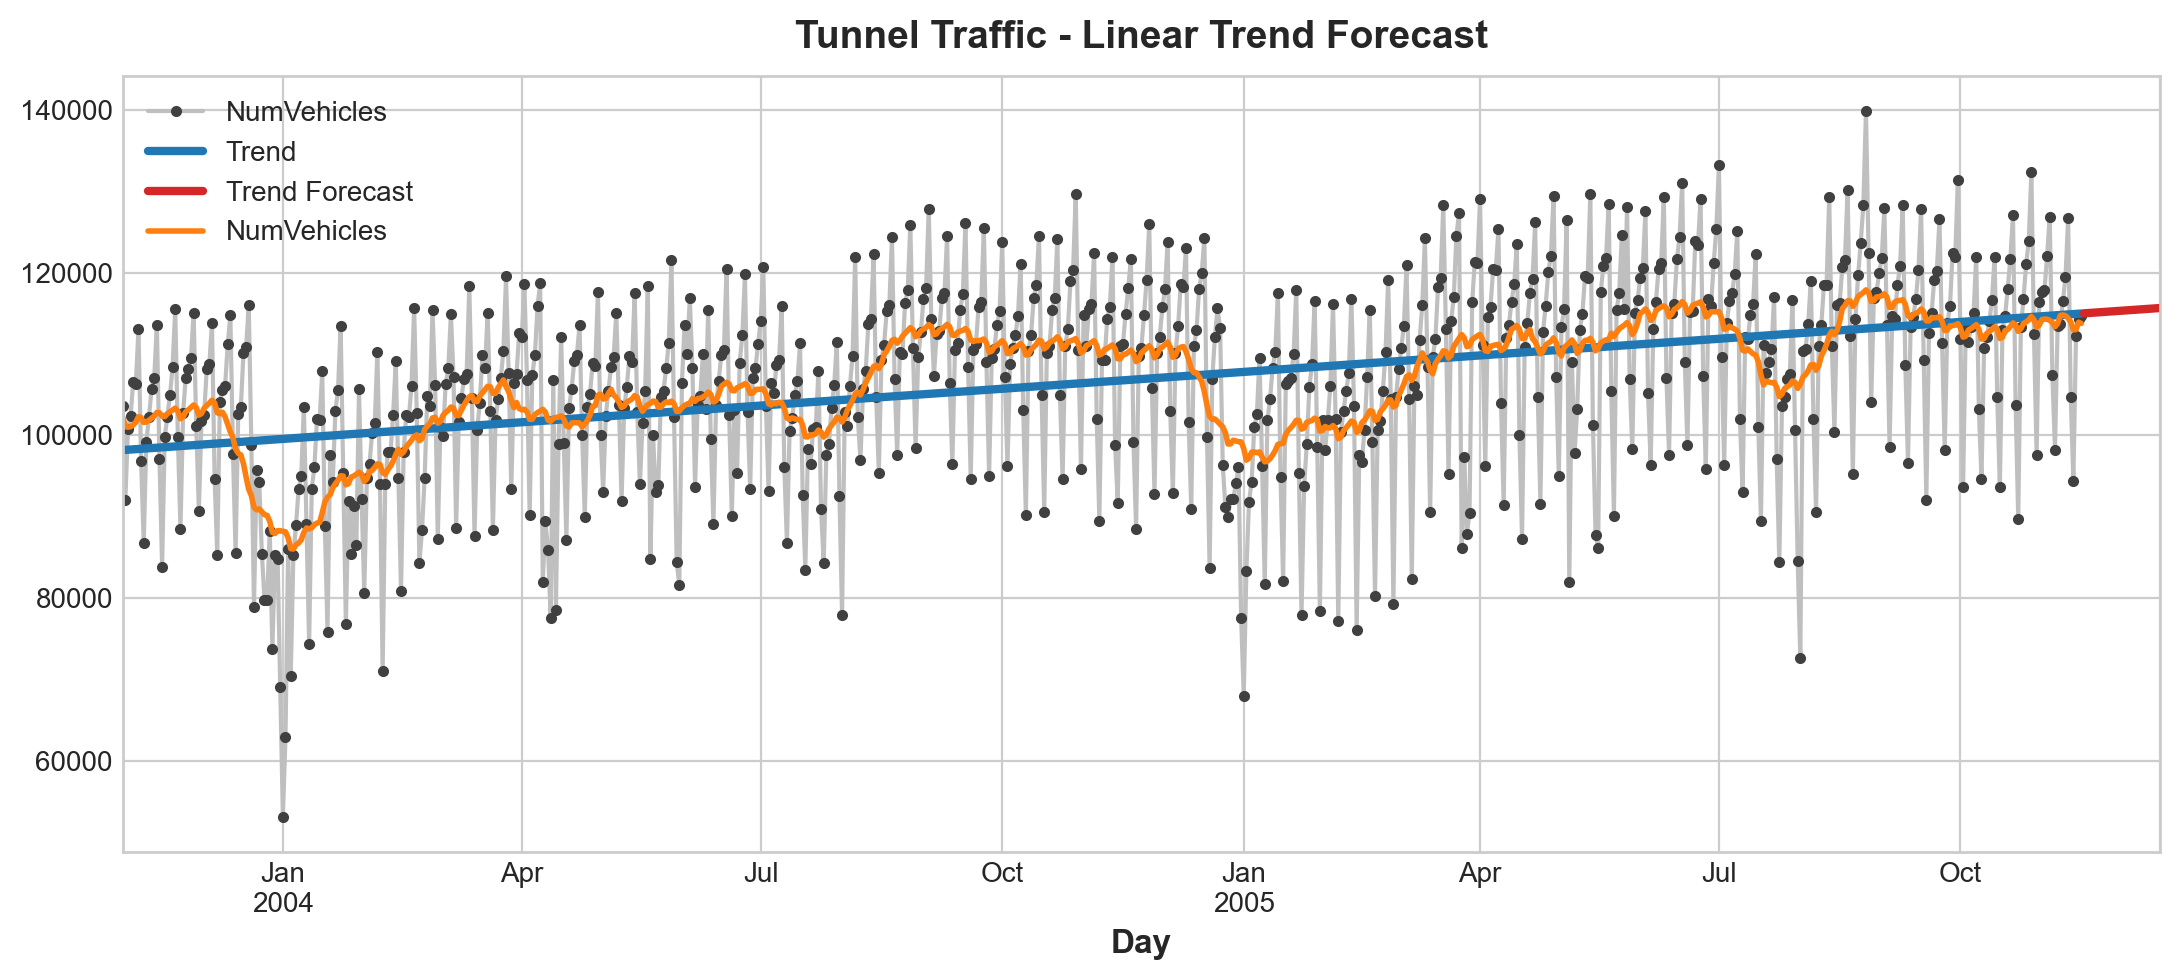

In [323]:
ax = tunnel["2003-01":].plot(title="Tunnel Traffic - Linear Trend Forecast", **plot_params) # Actual number of cars
ax = y_pred["2003-01":].plot(ax=ax, linewidth=3, label="Trend") # Trend
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color="C3") # Forecast
ax = moving_average.plot(ax=ax, linewidth=2, label = 'Moving Average 30 days') # Moving average
_ = ax.legend()


### Some exercise on Trend

In [324]:
retail_sales = pd.read_csv(
    data_dir / "us-retail-sales.csv",
    parse_dates=['Month'],
    index_col='Month',
).to_period('M')
food_sales = retail_sales.loc[:, 'FoodAndBeverage']
auto_sales = retail_sales.loc[:, 'Automobiles']

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

## Determine trend with a moving average plot

The US Retail Sales dataset contains monthly sales data for a number of retail industries in the United States. Let's to see a plot of the Food and Beverage series.

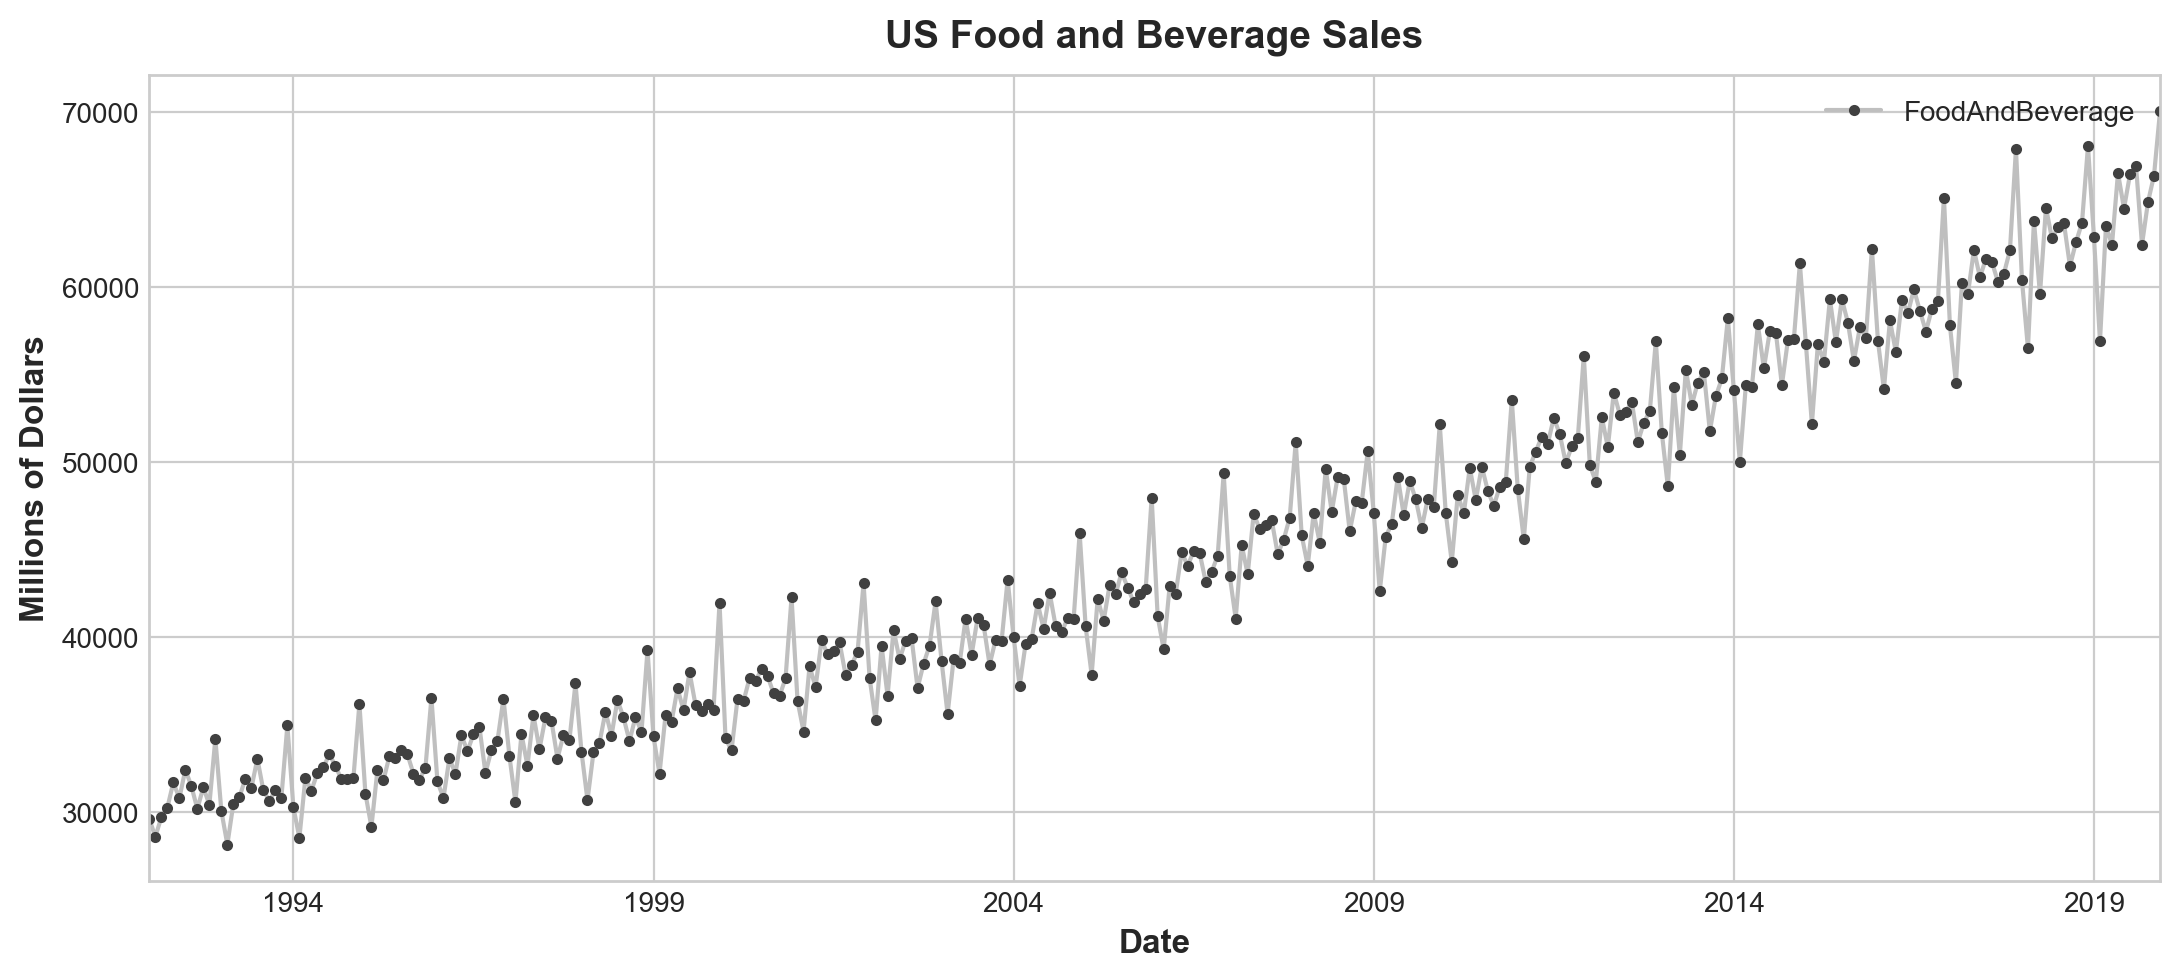

In [325]:
ax = food_sales.plot(**plot_params)
ax.set(title="US Food and Beverage Sales", ylabel="Millions of Dollars", xlabel="Date");

Now let's make a moving average plot to estimate the trend for this series.


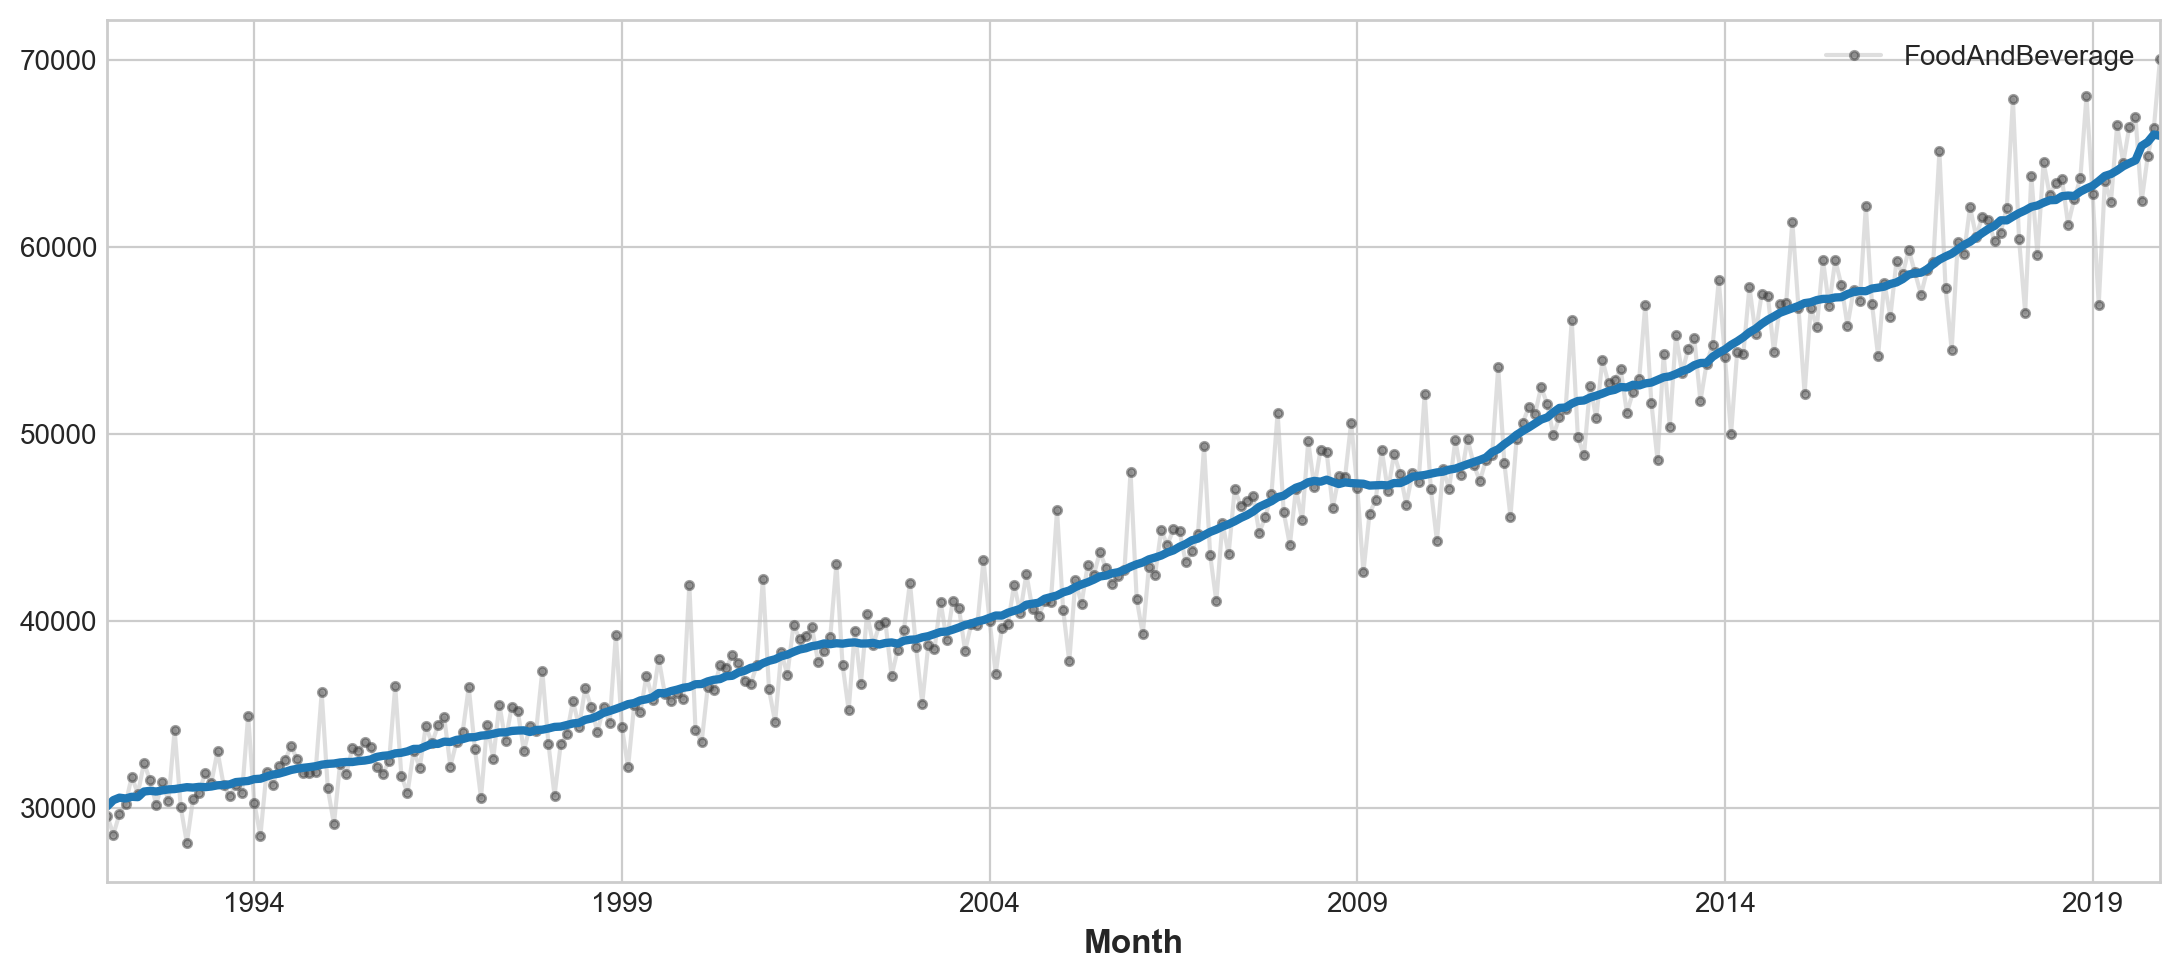

In [326]:
trend = food_sales.rolling(
    window=12,       # 12-day window
    center=True,      # puts the average at the center of the window
    min_periods=6,  # choose about half the window size
).mean()              # compute the mean (could also do median, std, min, max, ...)

ax = food_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

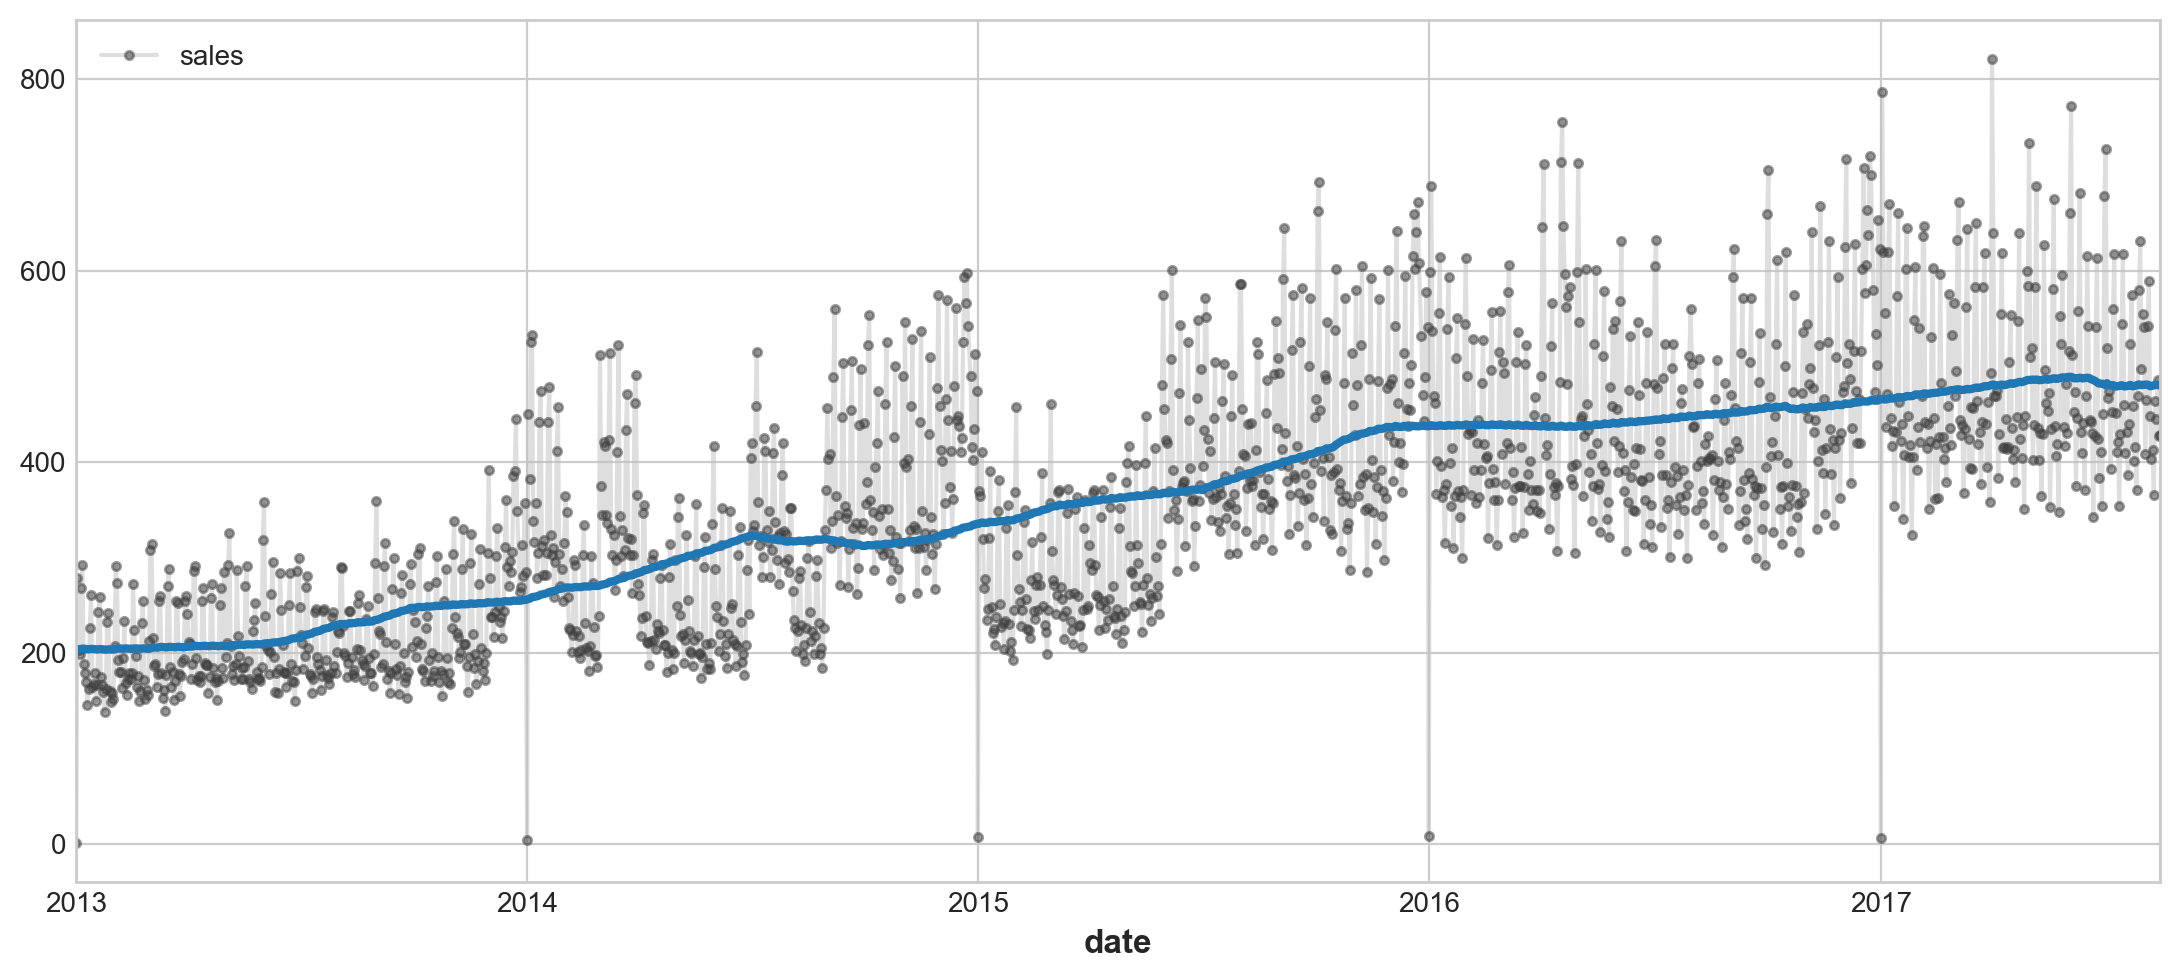

In [327]:
trend = average_sales.rolling(
    window=365,
    center=True,
    min_periods=183,
).mean()

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

### Let's create a Trend Feature

Let'suUse `DeterministicProces`s to create a feature set for a cubic trend model. Also we will create features for a 90-day forecast.

In [328]:
average_sales

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
                 ...    
2017-08-11    463.733856
2017-08-12    444.798279
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 1684, dtype: float32

In [329]:
y = average_sales.copy()  # the target

# Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=average_sales.index,  # dates from the training data
    constant=True,       # dummy feature for the bias (y_intercept)
    order=3,             # the time dummy (trend)
    drop=True,           # drop terms if necessary to avoid collinearity
)

# Create the feature set for the dates given in y.index
X = dp.in_sample()

# Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

print('X: ', X, 'X_fore: ', X_fore)

X:              const   trend  trend_squared   trend_cubed
date                                                  
2013-01-01    1.0     1.0            1.0  1.000000e+00
2013-01-02    1.0     2.0            4.0  8.000000e+00
2013-01-03    1.0     3.0            9.0  2.700000e+01
2013-01-04    1.0     4.0           16.0  6.400000e+01
2013-01-05    1.0     5.0           25.0  1.250000e+02
...           ...     ...            ...           ...
2017-08-11    1.0  1680.0      2822400.0  4.741632e+09
2017-08-12    1.0  1681.0      2825761.0  4.750104e+09
2017-08-13    1.0  1682.0      2829124.0  4.758587e+09
2017-08-14    1.0  1683.0      2832489.0  4.767079e+09
2017-08-15    1.0  1684.0      2835856.0  4.775582e+09

[1684 rows x 4 columns] X_fore:              const   trend  trend_squared   trend_cubed
2017-08-16    1.0  1685.0      2839225.0  4.784094e+09
2017-08-17    1.0  1686.0      2842596.0  4.792617e+09
2017-08-18    1.0  1687.0      2845969.0  4.801150e+09
2017-08-19    1.0  1688.0  

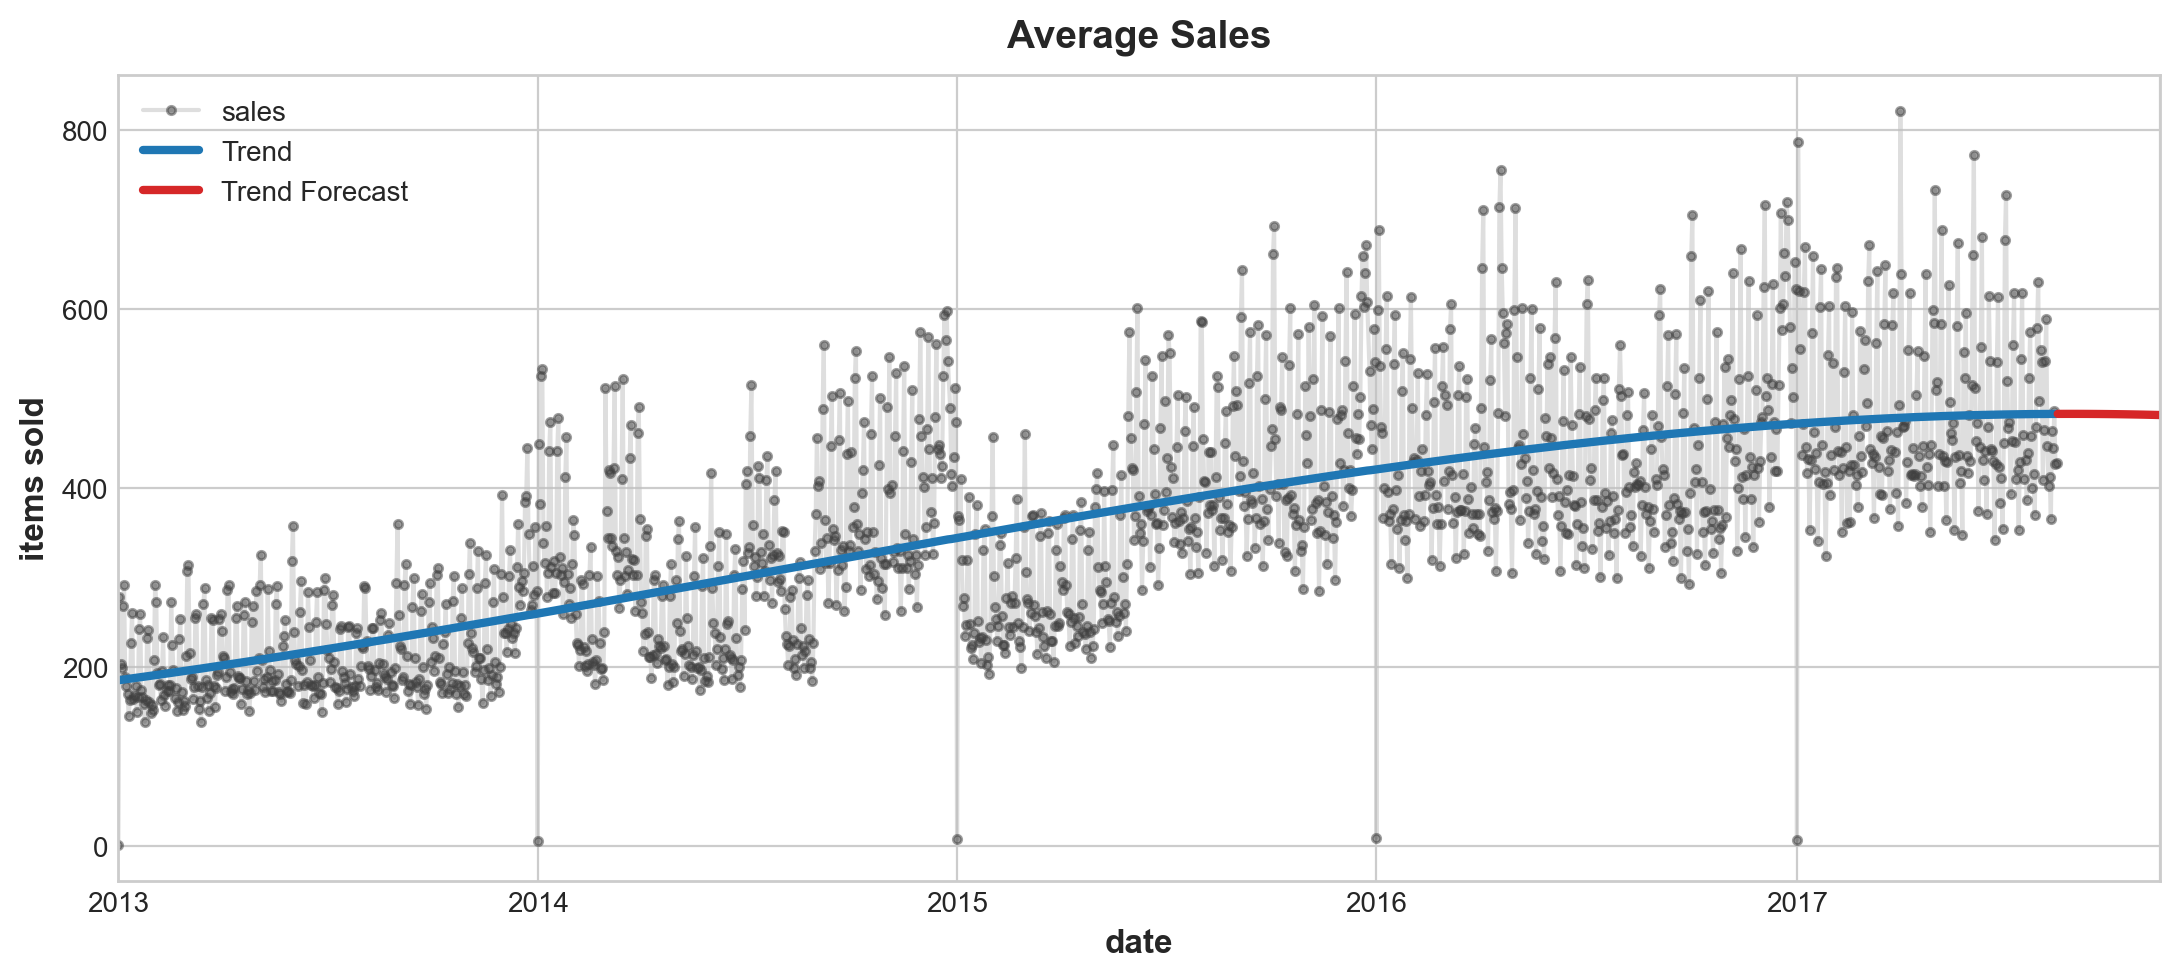

In [330]:
# Let's plot it

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

One way to fit more complicated trends is to increase the order of the polynomial we use. To get a better fit to the somewhat complicated trend in Store Sales, we could try using an order 11 polynomial.

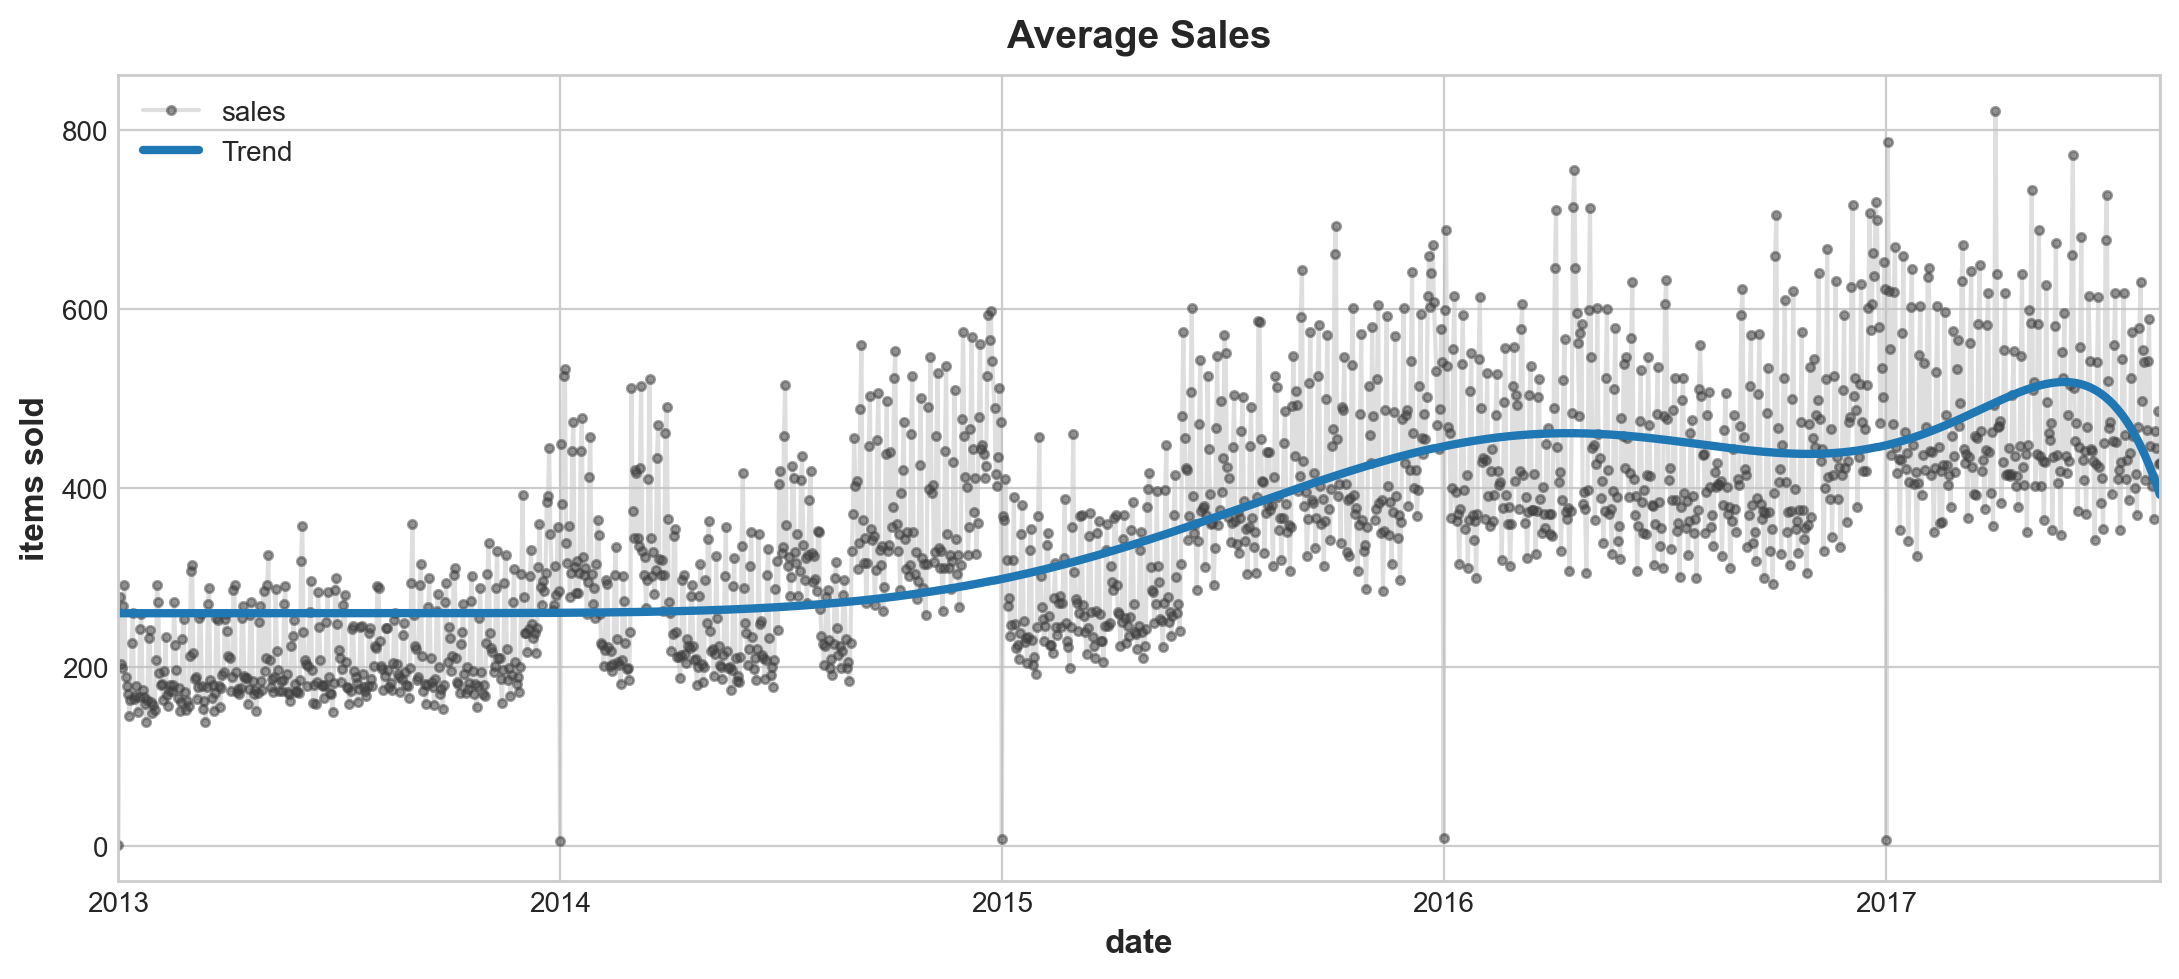

In [331]:
dp = DeterministicProcess(
    index=y.index,  # dates from the training data
    #constant=True,       # dummy feature for the bias (y_intercept)
    order=11,             # the time dummy (trend)
    #drop=True,           # drop terms if necessary to avoid collinearity
)

X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();

Run this cell to see the same 90-day forecast using an order 11 polynomial.


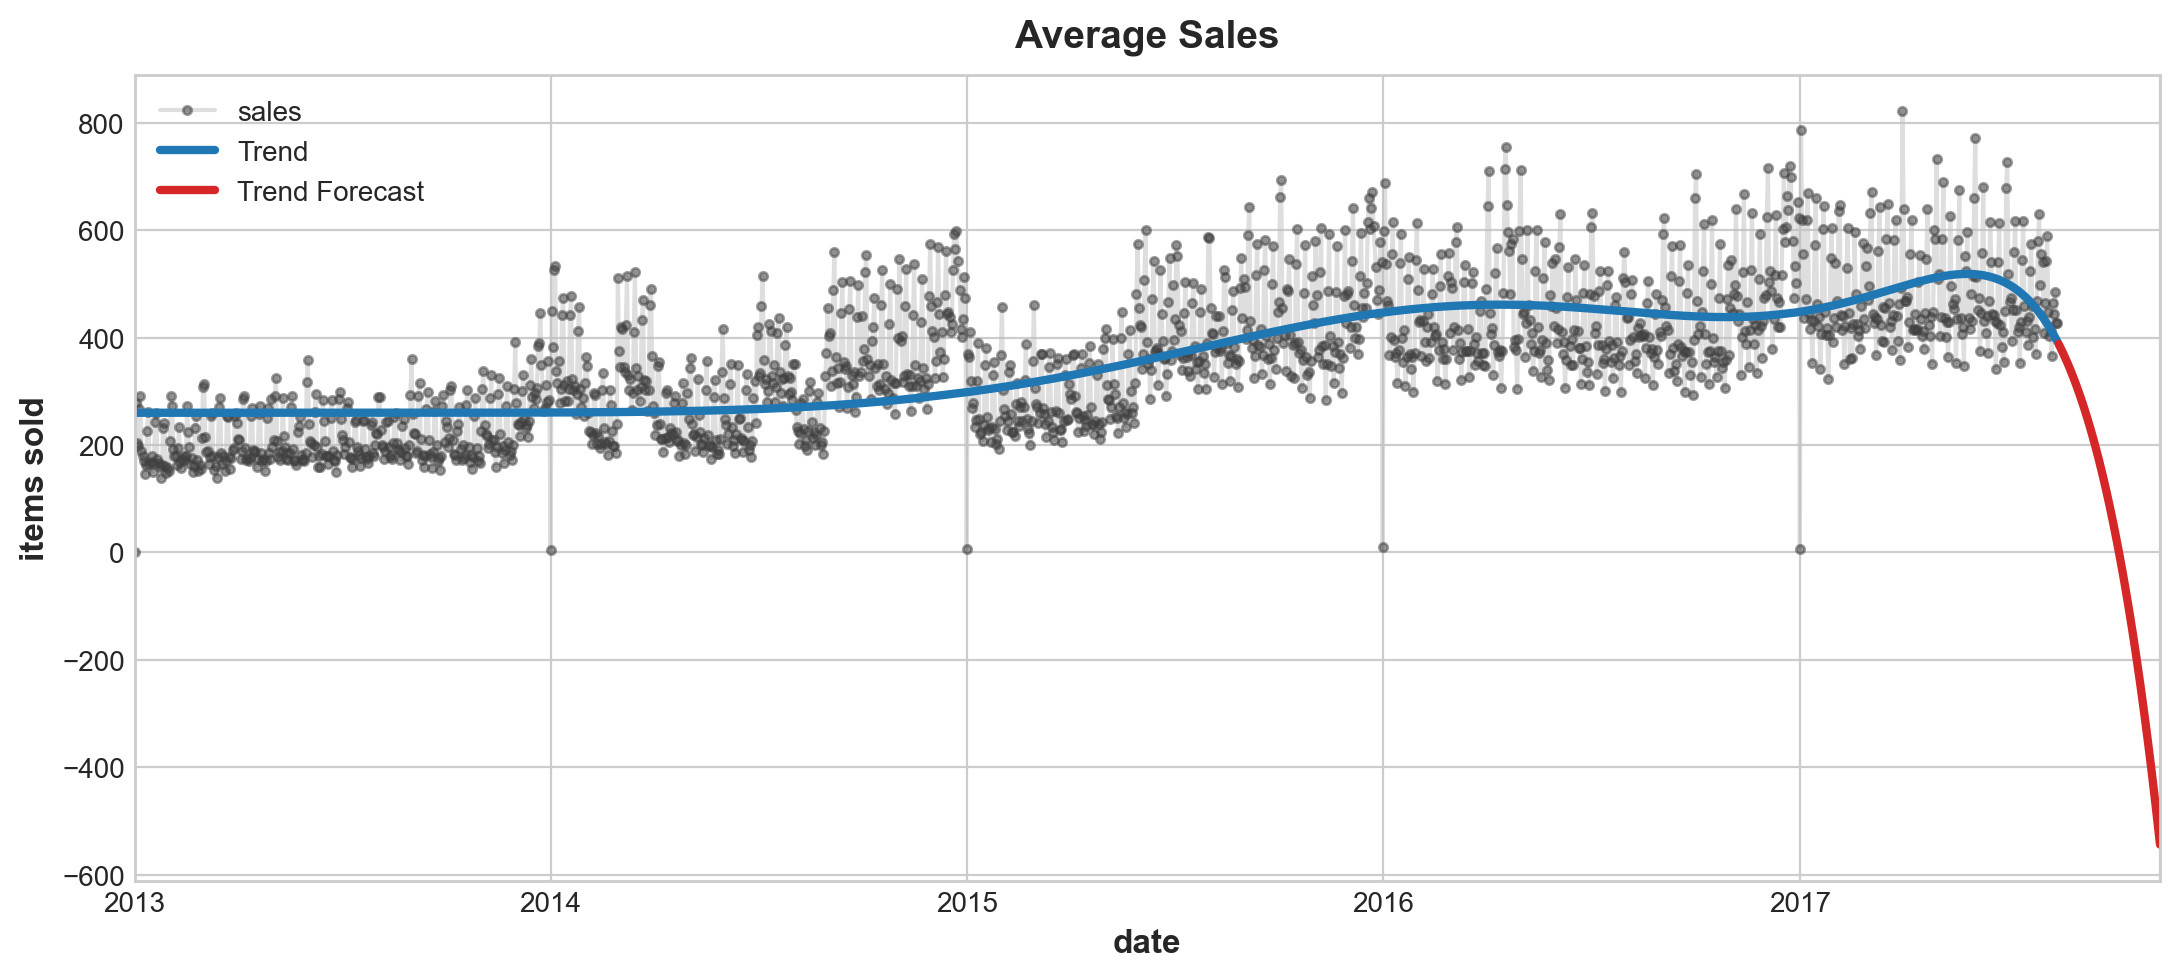

In [332]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

### Seasonality

Seasonal changes generally follow the clock and calendar -- repetitions over a day, a week, or a year are common. Seasonality is often driven by the cycles of the natural world over days and years or by conventions of social behavior surrounding dates and times.
We will learn two kinds of features that model seasonality. The first kind, indicators, is best for a season with few observations, like a weekly season of daily observations. The second kind, Fourier features, is best for a season with many observations, like an annual season of daily observations.



### Seasonal Plots and Seasonal Indicators
Just like we used a moving average plot to discover the trend in a series, we can use a seasonal plot to discover seasonal patterns.

A seasonal plot shows segments of the time series plotted against some common period, the period being the "season" you want to observe. 

### Fourier Features and the Periodogram - Tunnel Traffic

The kind of feature we discuss now are better suited for long seasons over many observations where indicators would be impractical. Instead of creating a feature for each date, Fourier features try to capture the overall shape of the seasonal curve with just a few features.

### Let's take a look at seasonal plots over a week and over a year.

We'll continue once more with the Tunnel Traffic dataset. The cell loads the data and defines two functions: `seasonal_plot` and `plot_periodogram`

In [333]:
# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax


tunnel = pd.read_csv(data_dir / "tunnel.csv", parse_dates=["Day"])
tunnel = tunnel.set_index("Day").to_period("D")

In [334]:
X

trend  trend_squared   trend_cubed      trend**4      trend**5  \
date                                                                          
2013-01-01     1.0            1.0  1.000000e+00  1.000000e+00  1.000000e+00   
2013-01-02     2.0            4.0  8.000000e+00  1.600000e+01  3.200000e+01   
2013-01-03     3.0            9.0  2.700000e+01  8.100000e+01  2.430000e+02   
2013-01-04     4.0           16.0  6.400000e+01  2.560000e+02  1.024000e+03   
2013-01-05     5.0           25.0  1.250000e+02  6.250000e+02  3.125000e+03   
...            ...            ...           ...           ...           ...   
2017-08-11  1680.0      2822400.0  4.741632e+09  7.965942e+12  1.338278e+16   
2017-08-12  1681.0      2825761.0  4.750104e+09  7.984925e+12  1.342266e+16   
2017-08-13  1682.0      2829124.0  4.758587e+09  8.003943e+12  1.346263e+16   
2017-08-14  1683.0      2832489.0  4.767079e+09  8.022994e+12  1.350270e+16   
2017-08-15  1684.0      2835856.0  4.775582e+09  8.042079e+12  1.354286e+16   

                trend**6      trend**7      trend**8      trend**9  \
date                                                                 
2013-01-01  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
2013-01-02  6.400000e+01  1.280000e+02  2.560000e+02  5.120000e+02   
2013-01-03  7.290000e+02  2.187000e+03  6.561000e+03  1.968300e+04   
2013-01-04  4.096000e+03  1.638400e+04  6.553600e+04  2.621440e+05   
2013-01-05  1.562500e+04  7.812500e+04  3.906250e+05  1.953125e+06   
...                  ...           ...           ...           ...   
2017-08-11  2.248307e+19  3.777156e+22  6.345623e+25  1.066065e+29   
2017-08-12  2.256349e+19  3.792923e+22  6.375903e+25  1.071789e+29   
2017-08-13  2.264415e+19  3.808745e+22  6.406310e+25  1.077541e+29   
2017-08-14  2.272504e+19  3.824625e+22  6.436843e+25  1.083321e+29   
2017-08-15  2.280618e+19  3.840560e+22  6.467504e+25  1.089128e+29   

               trend**10     trend**11  
date                                    
2013-01-01  1.000000e+00  1.000000e+00  
2013-01-02  1.024000e+03  2.048000e+03  
2013-01-03  5.904900e+04  1.771470e+05  
2013-01-04  1.048576e+06  4.194304e+06  
2013-01-05  9.765625e+06  4.882812e+07  
...                  ...           ...  
2017-08-11  1.790989e+32  3.008861e+35  
2017-08-12  1.801678e+32  3.028620e+35  
2017-08-13  1.812424e+32  3.048498e+35  
2017-08-14  1.823229e+32  3.068494e+35  
2017-08-15  1.834091e+32  3.088609e+35  

[1684 rows x 11 columns]

Let's take a look at seasonal plots over a week and over a year.

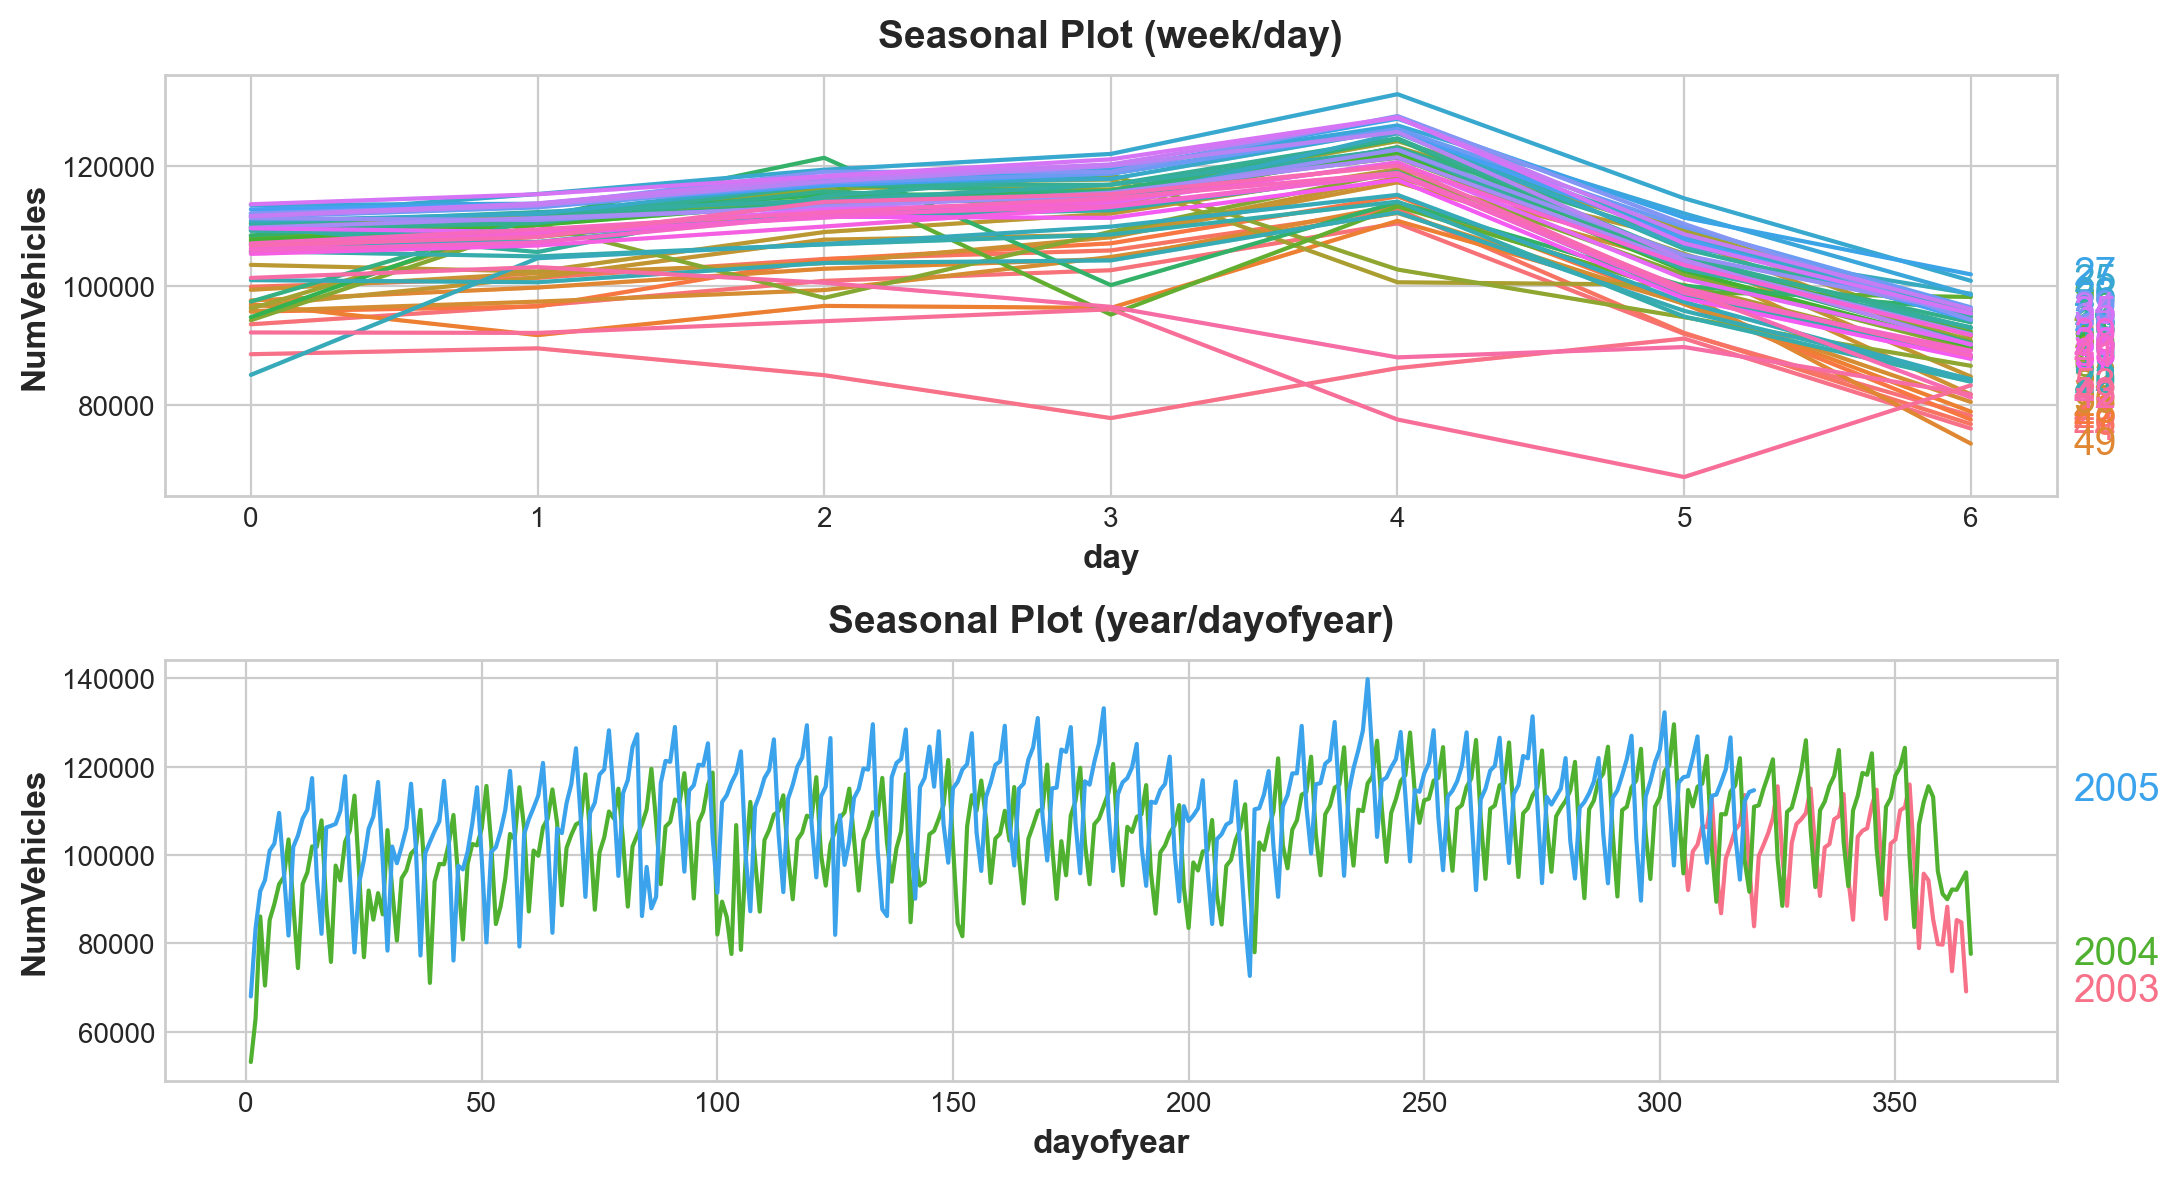

In [335]:
X = tunnel.copy()

# days within a week
X["day"] = X.index.dayofweek  # the x-axis (freq)
X["week"] = X.index.week  # the seasonal period (period)

# days within a year
X["dayofyear"] = X.index.dayofyear
X["year"] = X.index.year
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(11, 6))
seasonal_plot(X, y="NumVehicles", period="week", freq="day", ax=ax0)
seasonal_plot(X, y="NumVehicles", period="year", freq="dayofyear", ax=ax1);

Now let's look at the periodogram:

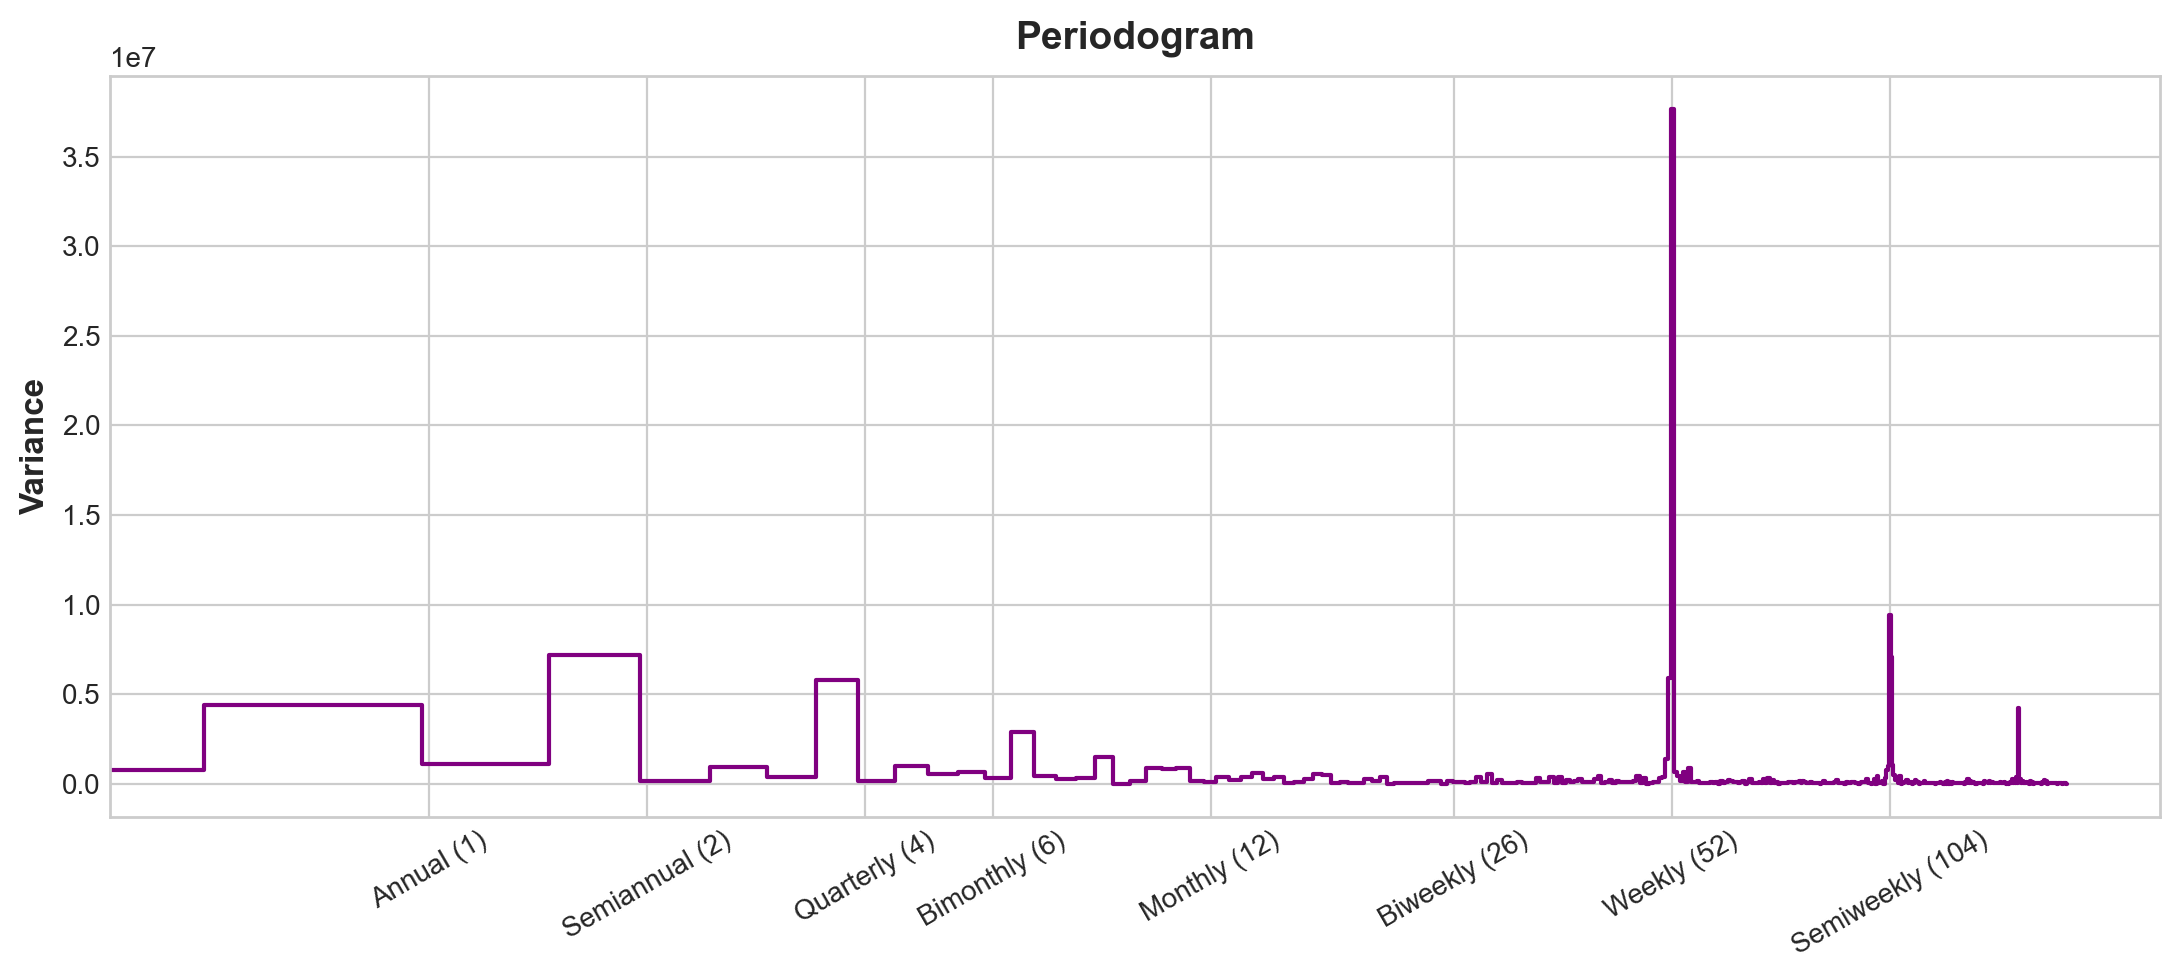

In [336]:
plot_periodogram(tunnel.NumVehicles);

The periodogram agrees with the seasonal plots above: a strong weekly season and a weaker annual season. The weekly season we'll model with indicators and the annual season with Fourier features. From right to left, the periodogram falls off between `Bimonthly` (6) and `Monthly` (12), so let's use `10` Fourier pairs.

We'll create our seasonal features using `DeterministicProcess`, the same utility we used earlier 2 to create trend features. To use two seasonal periods (weekly and annual), we'll need to instantiate one of them as an "additional term":

In [337]:
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

fourier = CalendarFourier(freq="A", order=10)  # 10 sin/cos pairs for "A"nnual seasonality

dp = DeterministicProcess(
    index=tunnel.index,
    constant=True,               # dummy feature for bias (y-intercept)
    order=1,                     # trend (order 1 means linear)
    seasonal=True,               # weekly seasonality (indicators)
    additional_terms=[fourier],  # annual seasonality (fourier)
    drop=True,                   # drop terms to avoid collinearity
)

X = dp.in_sample()  # create features for dates in tunnel.index

With our feature set created, we're ready to fit the model and make predictions. We'll add a 90-day forecast to see how our model extrapolates beyond the training data. The code here is the same as that in earlier.

In [338]:
X.columns

Index(['const', 'trend', 's(2,7)', 's(3,7)', 's(4,7)', 's(5,7)', 's(6,7)',
       's(7,7)', 'sin(1,freq=A-DEC)', 'cos(1,freq=A-DEC)', 'sin(2,freq=A-DEC)',
       'cos(2,freq=A-DEC)', 'sin(3,freq=A-DEC)', 'cos(3,freq=A-DEC)',
       'sin(4,freq=A-DEC)', 'cos(4,freq=A-DEC)', 'sin(5,freq=A-DEC)',
       'cos(5,freq=A-DEC)', 'sin(6,freq=A-DEC)', 'cos(6,freq=A-DEC)',
       'sin(7,freq=A-DEC)', 'cos(7,freq=A-DEC)', 'sin(8,freq=A-DEC)',
       'cos(8,freq=A-DEC)', 'sin(9,freq=A-DEC)', 'cos(9,freq=A-DEC)',
       'sin(10,freq=A-DEC)', 'cos(10,freq=A-DEC)'],
      dtype='object')

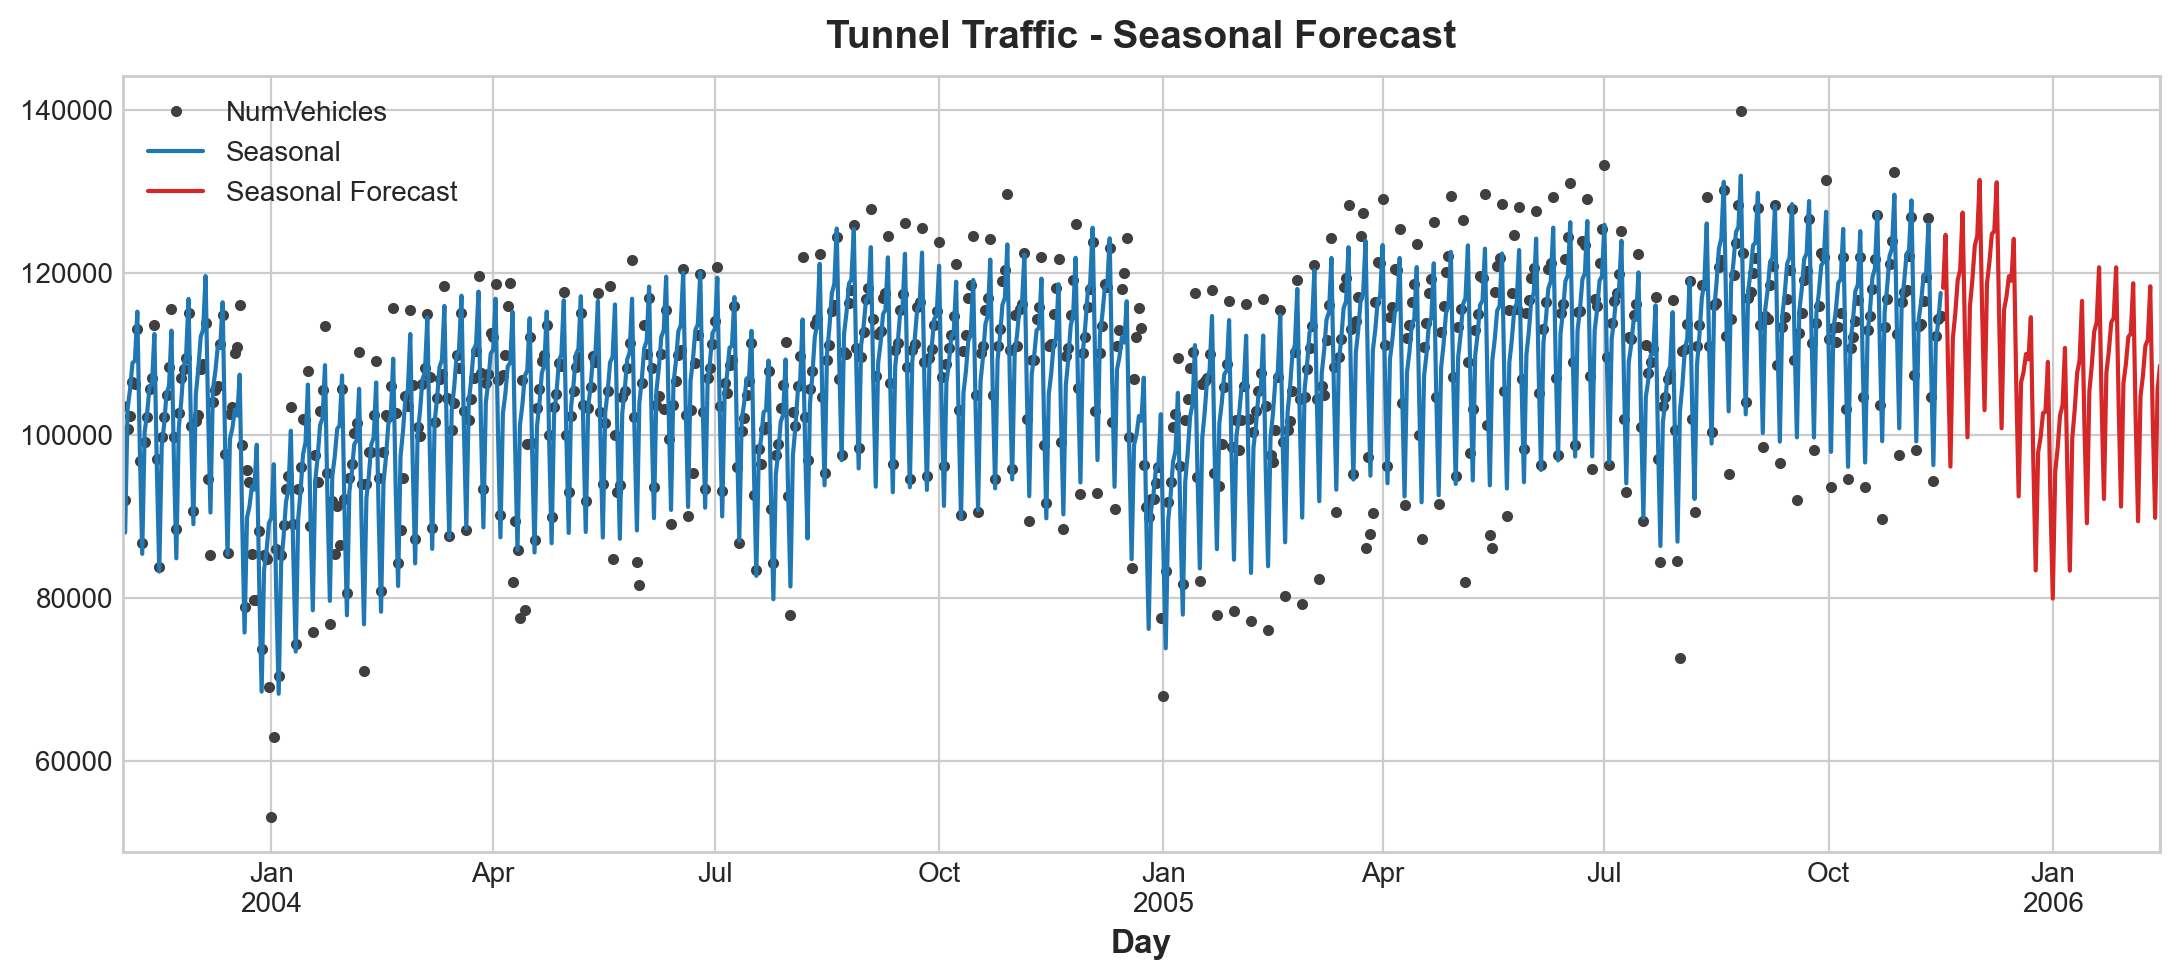

In [339]:
y = tunnel["NumVehicles"]

model = LinearRegression(fit_intercept=False)
_ = model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=y.index)
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(color='0.25', style='.', title="Tunnel Traffic - Seasonal Forecast")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax = y_fore.plot(ax=ax, label="Seasonal Forecast", color='C3')
_ = ax.legend()

### Some Exercise on Seasonability

In [340]:
# Setup feedback system

# Setup notebook
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


comp_dir = Path('./data/store-sales-time-series-forecasting')

holidays_events = pd.read_csv(
    comp_dir / "holidays_events.csv",
    dtype={
        'type': 'category',
        'locale': 'category',
        'locale_name': 'category',
        'description': 'category',
        'transferred': 'bool',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
holidays_events = holidays_events.set_index('date').to_period('D')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()
average_sales = (
    store_sales
    .groupby('date').mean()
    .squeeze()
    .loc['2017']
)

Examine the following seasonal plot:

sales  week  day
date                             
2017-01-01    6.780303    52    6
2017-01-02  786.928406     1    0
2017-01-03  619.740234     1    1
2017-01-04  555.608032     1    2
2017-01-05  436.375397     1    3
...                ...   ...  ...
2017-08-11  463.733856    32    4
2017-08-12  444.798279    32    5
2017-08-13  485.768616    32    6
2017-08-14  427.004730    33    0
2017-08-15  427.980896    33    1

[227 rows x 3 columns]

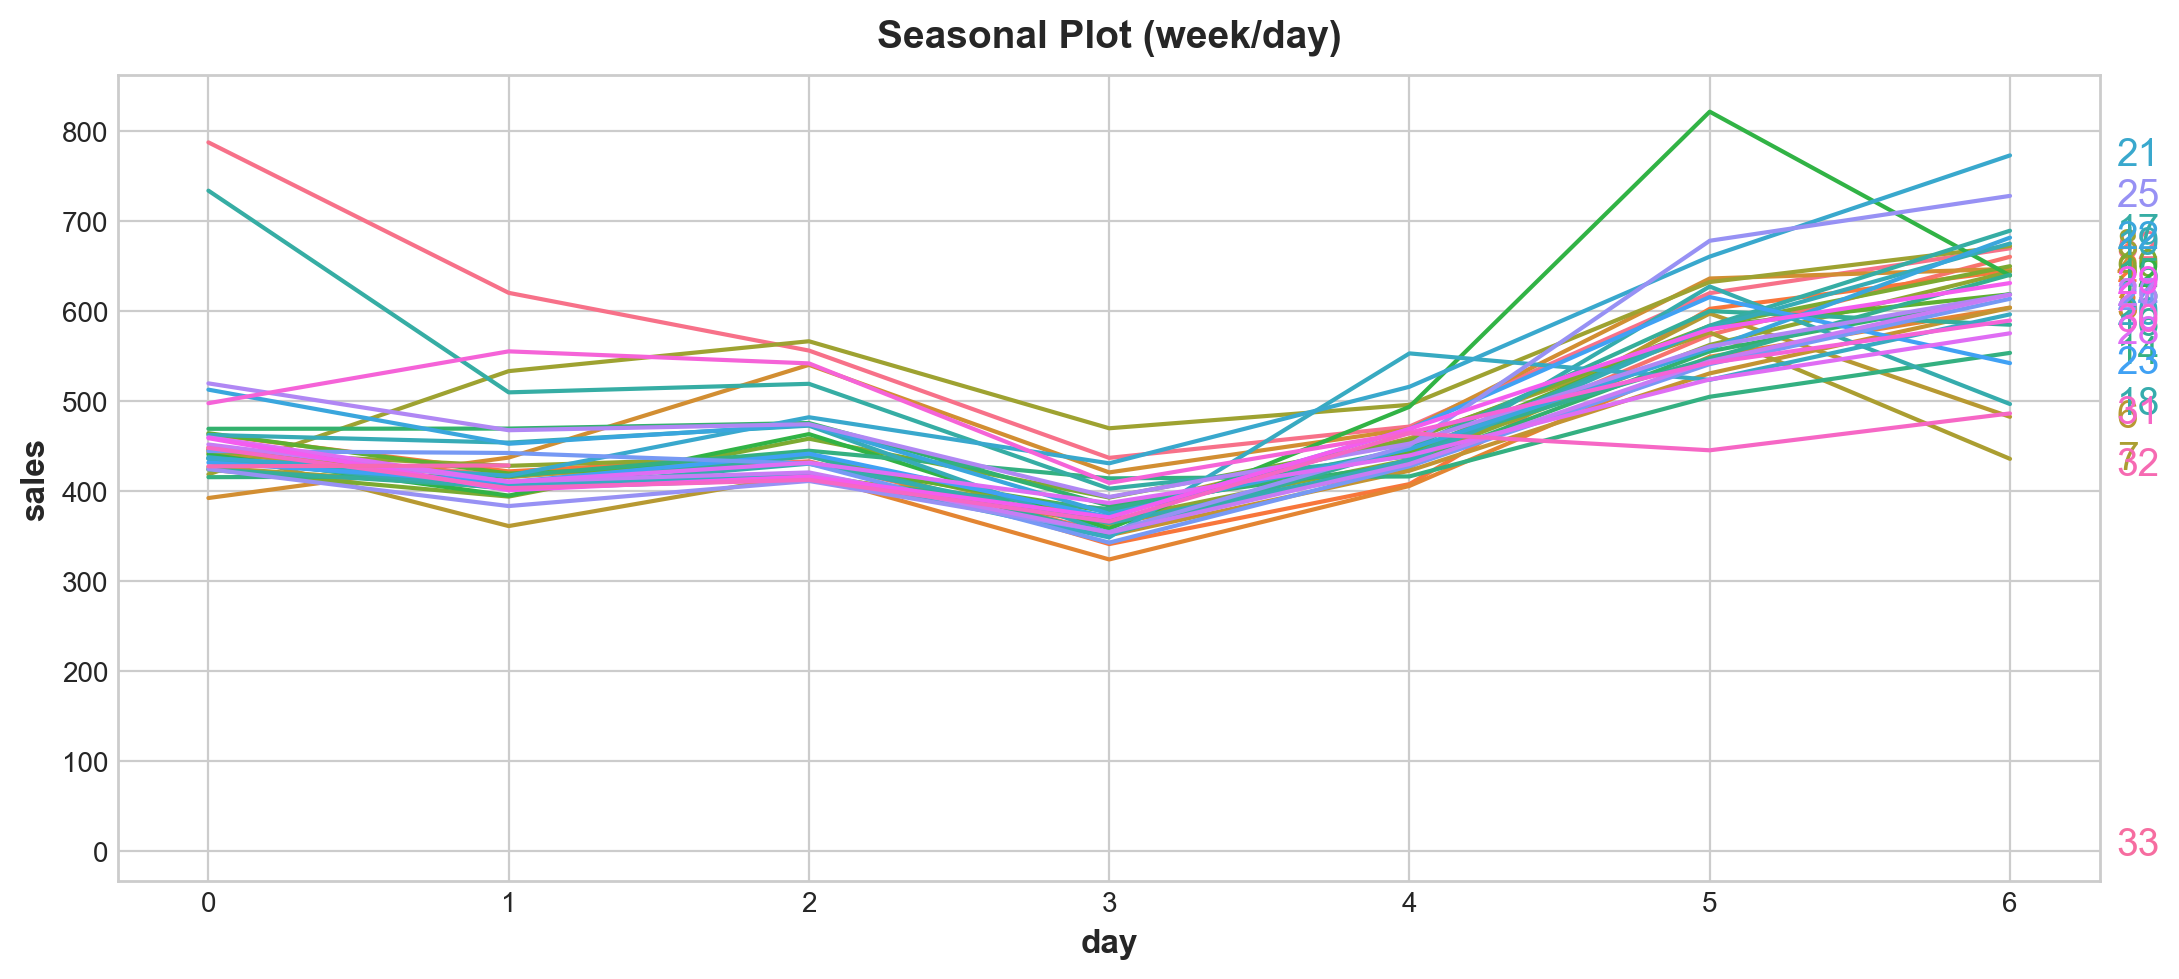

In [341]:
X = average_sales.to_frame()
X["week"] = X.index.week
X["day"] = X.index.dayofweek
seasonal_plot(X, y='sales', period='week', freq='day');
X

And also the periodogram:


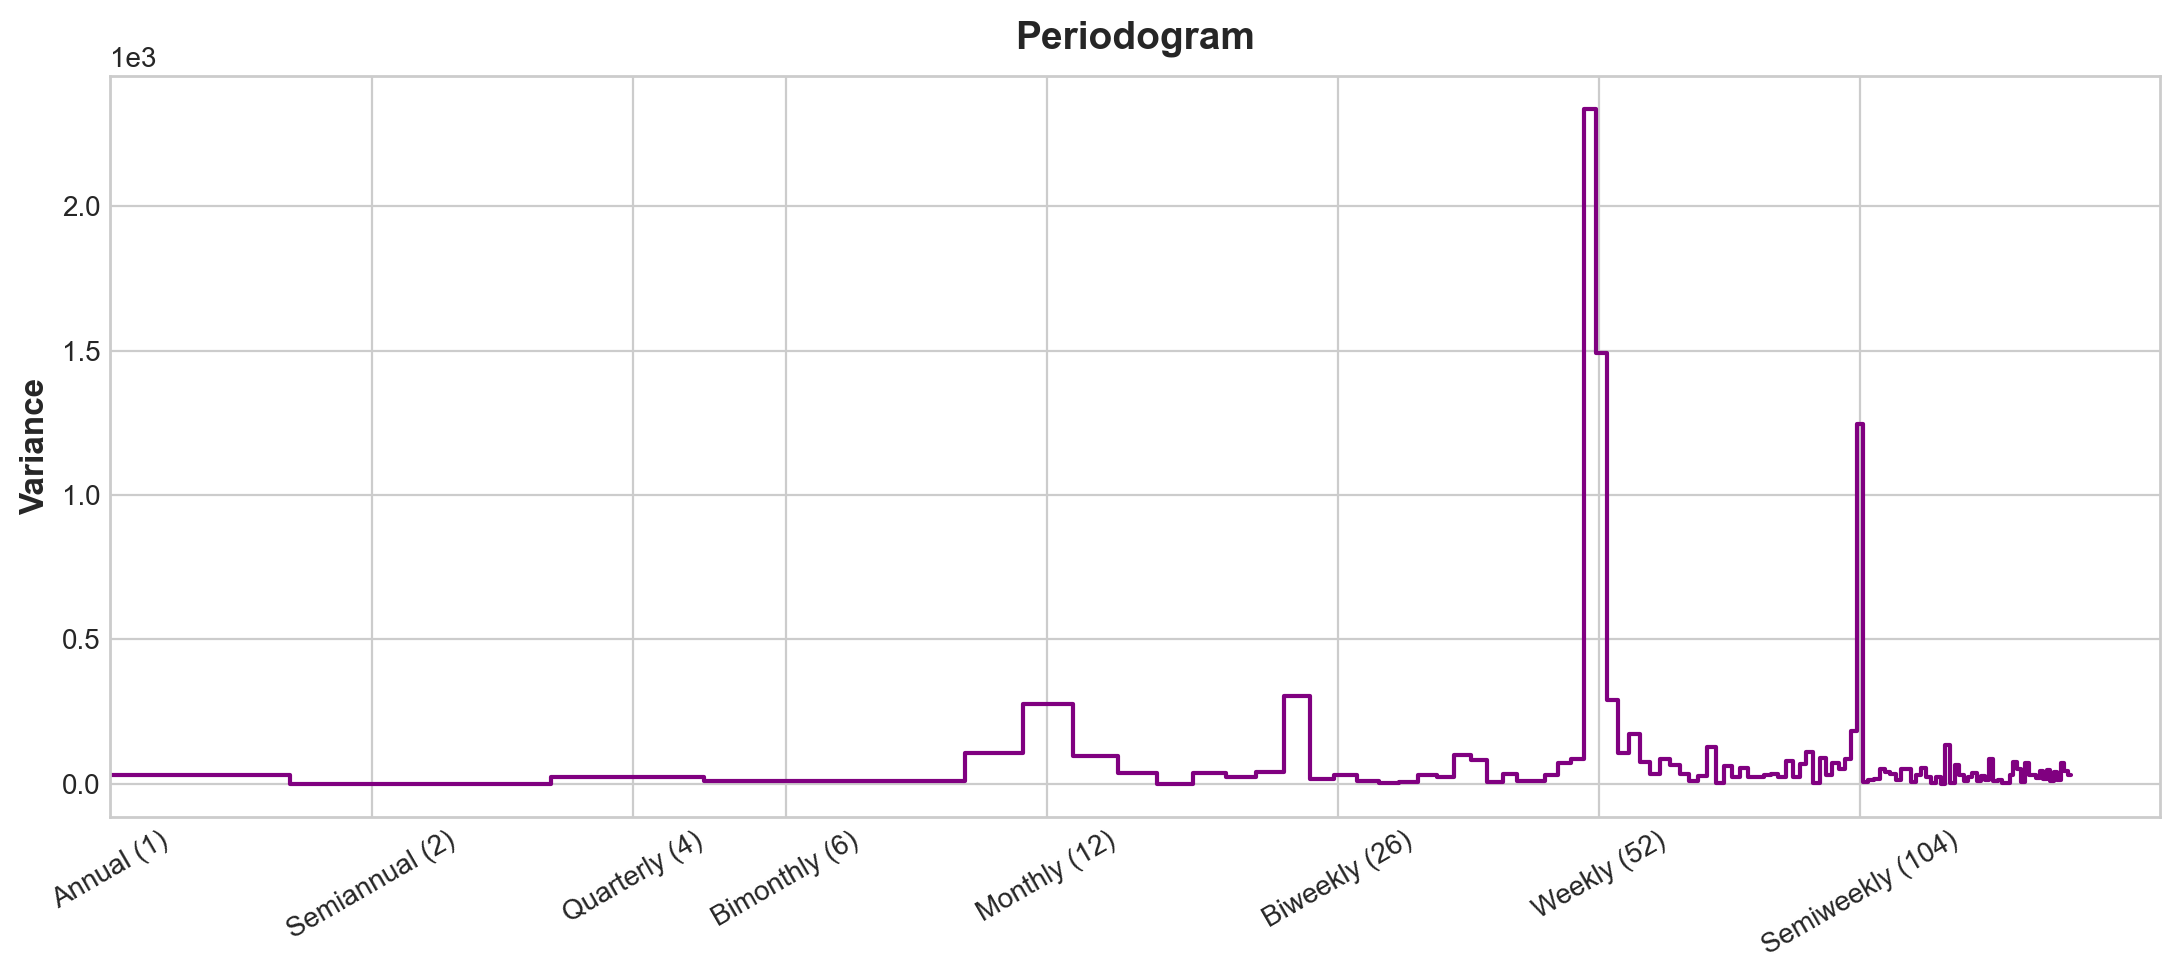

In [342]:
plot_periodogram(average_sales);

1) Determine seasonality

What kind of seasonality do you see evidence of? 
Both the seasonal plot and the periodogram suggest a strong weekly seasonality. From the periodogram, it appears there may be some monthly and biweekly components as well. In fact, the notes to the Store Sales dataset say wages in the public sector are paid out biweekly, on the 15th and last day of the month -- a possible origin for these seasons.

2) Create seasonal features
Let's use `DeterministicProcess` and `CalendarFourier` to create:
Indicators for weekly seasons and Fourier features of order 4 for monthly seasons.

In [343]:
y = average_sales.copy()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()
X

const  trend  s(2,7)  s(3,7)  s(4,7)  s(5,7)  s(6,7)  s(7,7)  \
date                                                                       
2017-01-01    1.0    1.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-01-02    1.0    2.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-01-03    1.0    3.0     0.0     1.0     0.0     0.0     0.0     0.0   
2017-01-04    1.0    4.0     0.0     0.0     1.0     0.0     0.0     0.0   
2017-01-05    1.0    5.0     0.0     0.0     0.0     1.0     0.0     0.0   
...           ...    ...     ...     ...     ...     ...     ...     ...   
2017-08-11    1.0  223.0     0.0     0.0     0.0     0.0     1.0     0.0   
2017-08-12    1.0  224.0     0.0     0.0     0.0     0.0     0.0     1.0   
2017-08-13    1.0  225.0     0.0     0.0     0.0     0.0     0.0     0.0   
2017-08-14    1.0  226.0     1.0     0.0     0.0     0.0     0.0     0.0   
2017-08-15    1.0  227.0     0.0     1.0     0.0     0.0     0.0     0.0   

            sin(1,freq=M)  cos(1,freq=M)  sin(2,freq=M)  cos(2,freq=M)  \
date                                                                     
2017-01-01       0.000000       1.000000       0.000000       1.000000   
2017-01-02       0.201299       0.979530       0.394356       0.918958   
2017-01-03       0.394356       0.918958       0.724793       0.688967   
2017-01-04       0.571268       0.820763       0.937752       0.347305   
2017-01-05       0.724793       0.688967       0.998717      -0.050649   
...                   ...            ...            ...            ...   
2017-08-11       0.897805      -0.440394      -0.790776      -0.612106   
2017-08-12       0.790776      -0.612106      -0.968077      -0.250653   
2017-08-13       0.651372      -0.758758      -0.988468       0.151428   
2017-08-14       0.485302      -0.874347      -0.848644       0.528964   
2017-08-15       0.299363      -0.954139      -0.571268       0.820763   

            sin(3,freq=M)  cos(3,freq=M)  sin(4,freq=M)  cos(4,freq=M)  
date                                                                    
2017-01-01       0.000000       1.000000       0.000000       1.000000  
2017-01-02       0.571268       0.820763       0.724793       0.688967  
2017-01-03       0.937752       0.347305       0.998717      -0.050649  
2017-01-04       0.968077      -0.250653       0.651372      -0.758758  
2017-01-05       0.651372      -0.758758      -0.101168      -0.994869  
...                   ...            ...            ...            ...  
2017-08-11      -0.201299       0.979530       0.968077      -0.250653  
2017-08-12       0.394356       0.918958       0.485302      -0.874347  
2017-08-13       0.848644       0.528964      -0.299363      -0.954139  
2017-08-14       0.998717      -0.050649      -0.897805      -0.440394  
2017-08-15       0.790776      -0.612106      -0.937752       0.347305  

[227 rows x 16 columns]

Let's fit the model

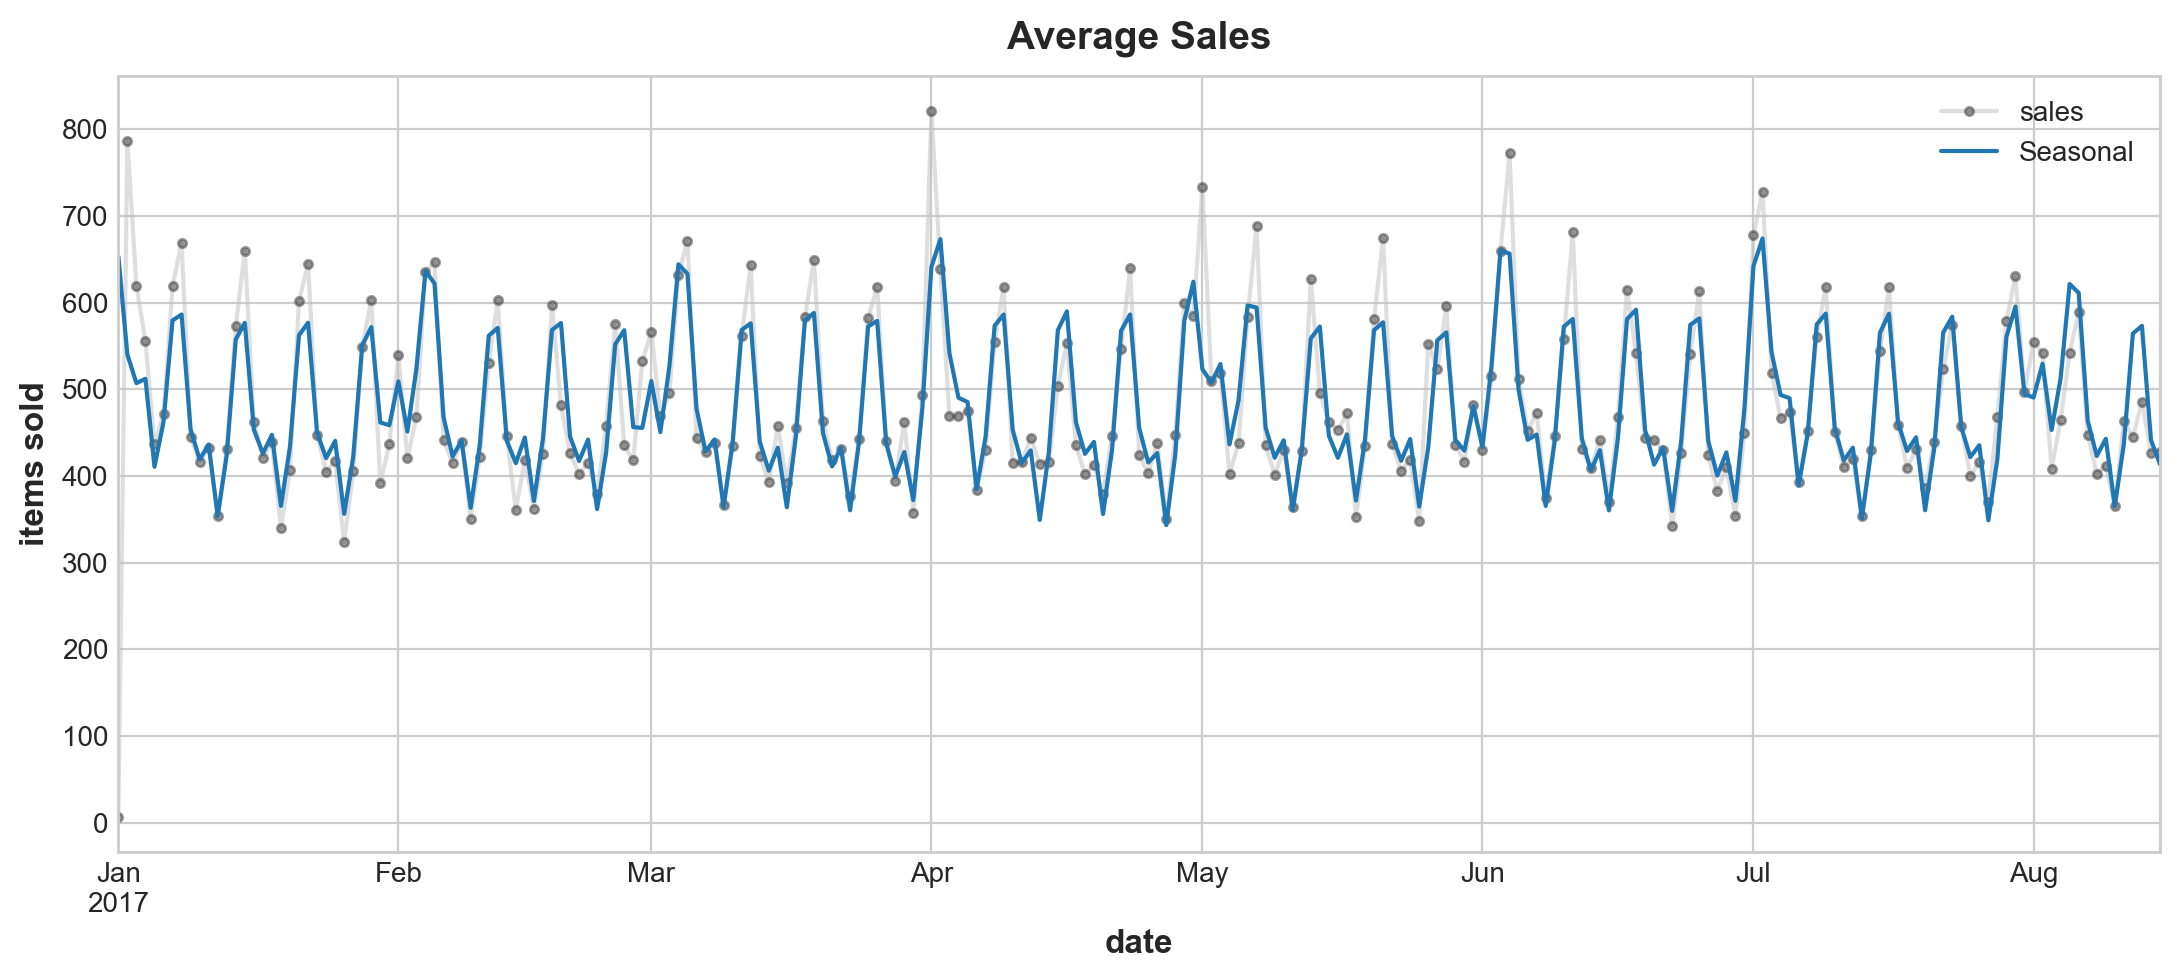

In [344]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(
    model.predict(X),
    index=X.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X), index=X.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

Removing from a series its trend or seasons is called detrending or deseasonalizing the series.

Look at the periodogram of the deseasonalized series.

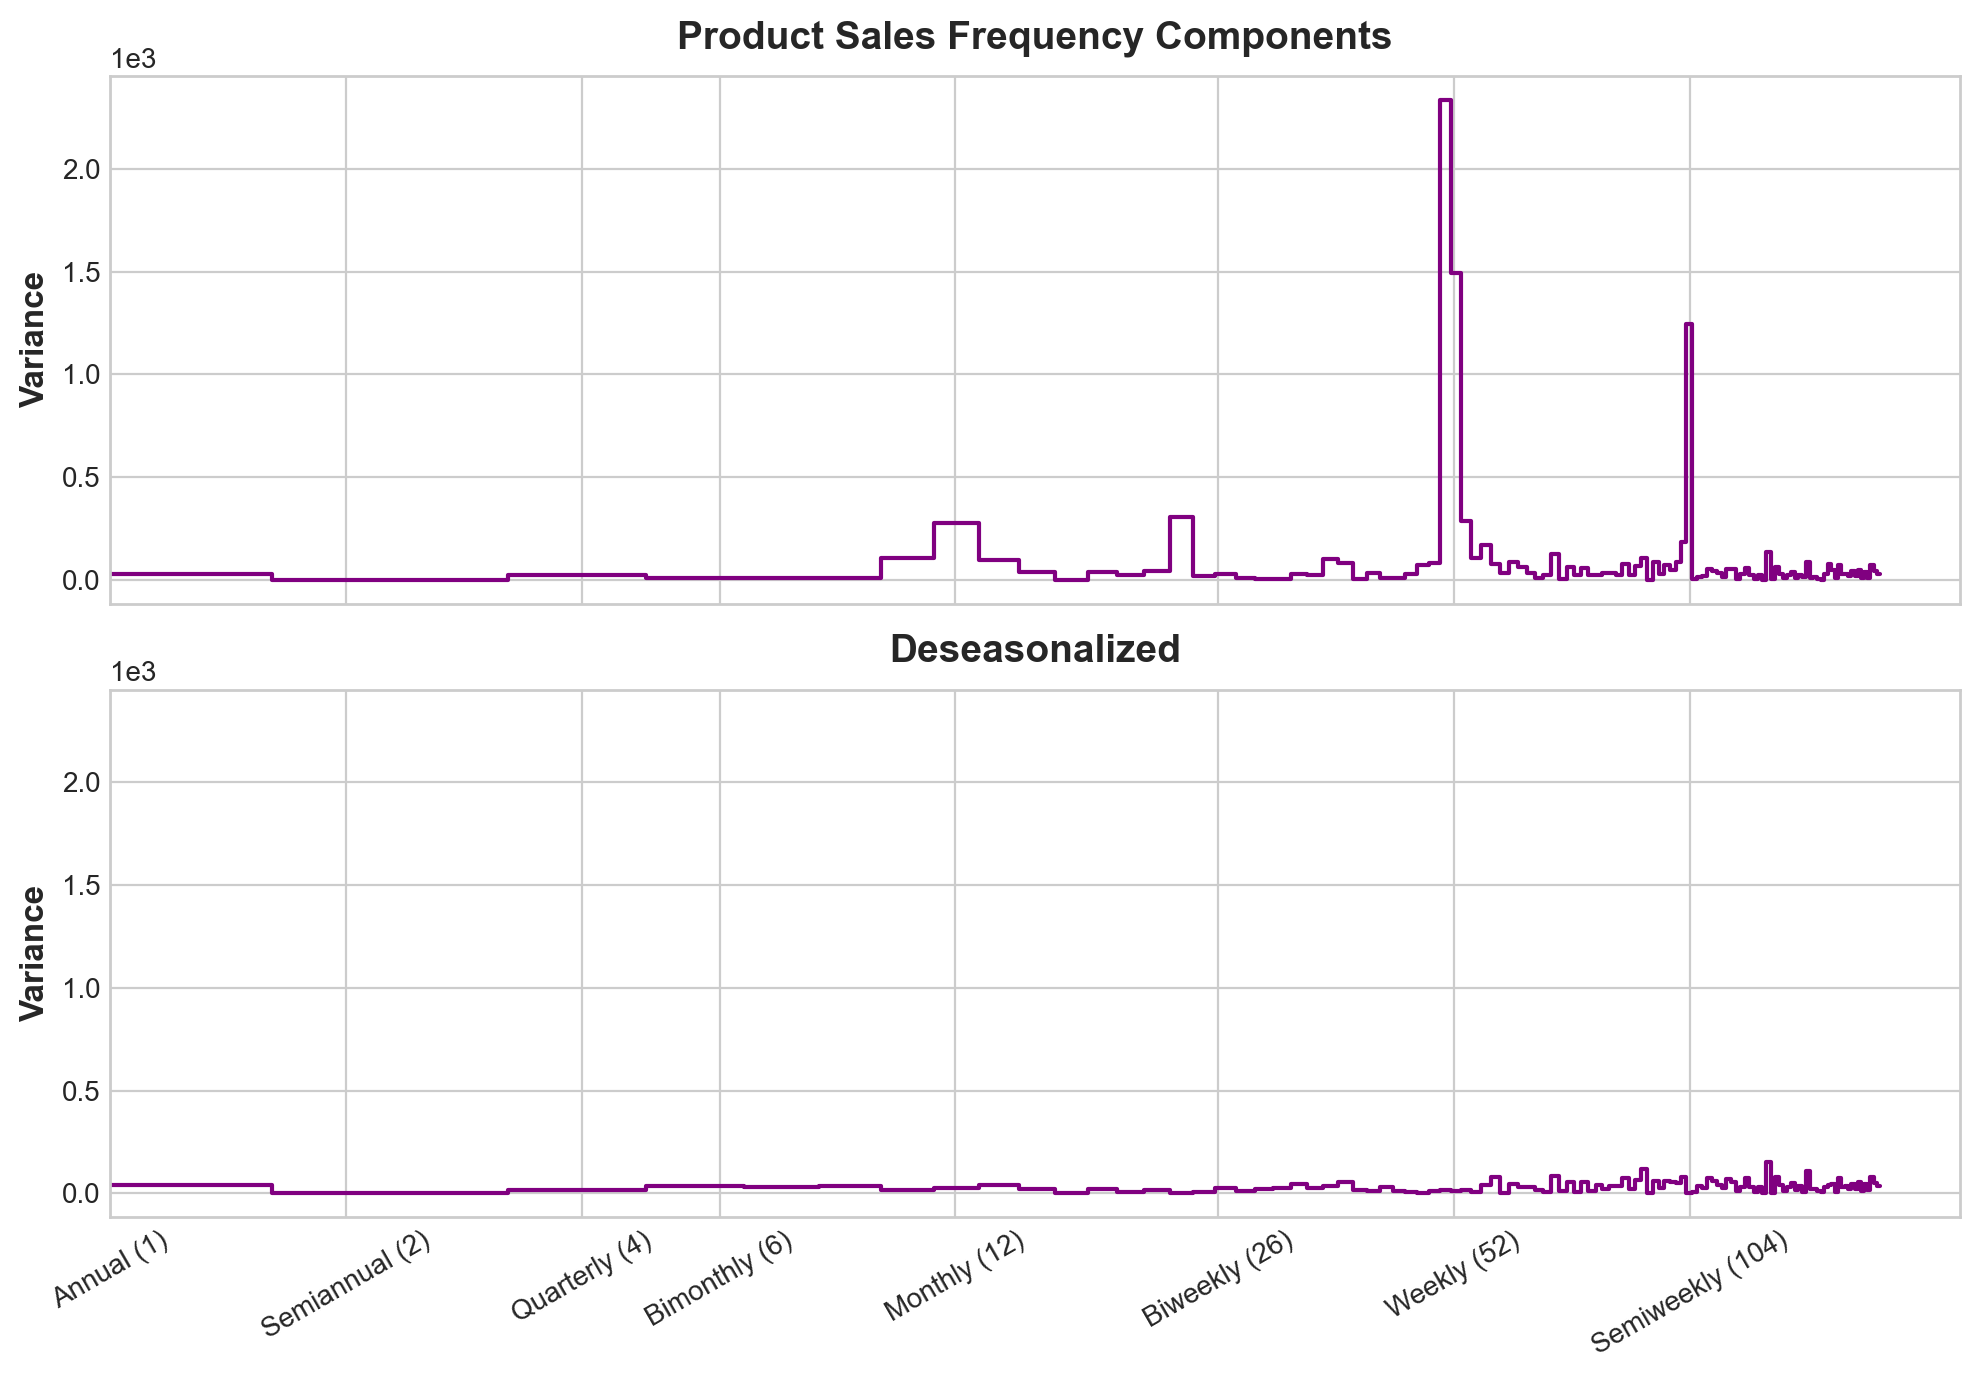

In [345]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

Based on these periodograms, we can see that the periodogram for the deseasonalized series lacks any large values. By comparing it to the periodogram for the original series, we can see that our model was able to capture the seasonal variation in Average Sales.

The *Store Sales* dataset includes a table of Ecuadorian holidays.

In [346]:
# National and regional holidays in the training set
holidays = (
    holidays_events
    .query("locale in ['National', 'Regional']")
    .loc['2017':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)

holidays

description
date                                              
2017-01-01                      Primer dia del ano
2017-01-02             Traslado Primer dia del ano
2017-02-27                                Carnaval
2017-02-28                                Carnaval
2017-04-01           Provincializacion de Cotopaxi
2017-04-14                           Viernes Santo
2017-05-01                         Dia del Trabajo
2017-05-13                       Dia de la Madre-1
2017-05-14                         Dia de la Madre
2017-05-24                    Batalla de Pichincha
2017-05-26           Traslado Batalla de Pichincha
2017-06-25           Provincializacion de Imbabura
2017-08-10           Primer Grito de Independencia
2017-08-11  Traslado Primer Grito de Independencia

From a plot of the deseasonalized Average Sales, it appears these holidays could have some predictive power.

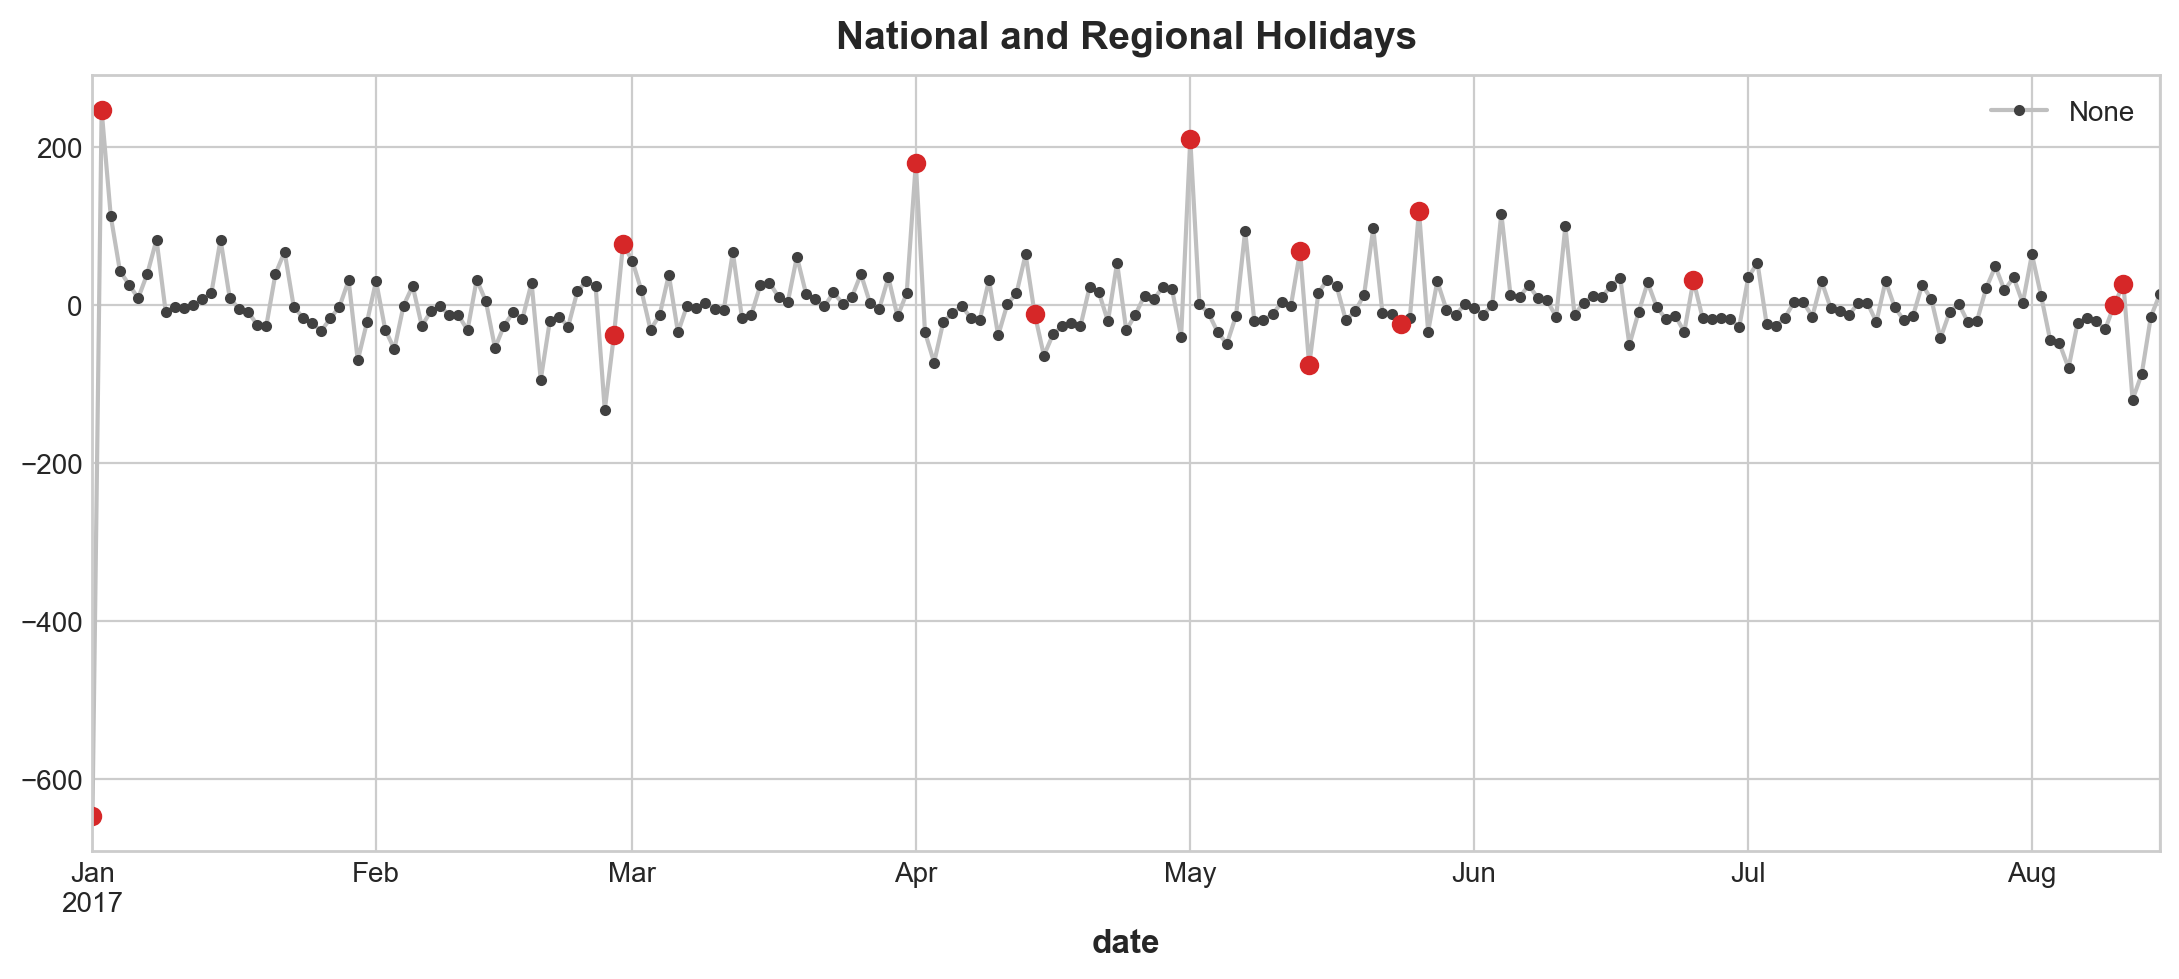

In [347]:
ax = y_deseason.plot(**plot_params)
plt.plot_date(holidays.index, y_deseason[holidays.index], color='C3')
ax.set_title('National and Regional Holidays');

## Create holiday features

In [348]:
# Scikit-learn solution
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder(sparse=False)

X_holidays = pd.DataFrame(
    ohe.fit_transform(holidays),
    index=holidays.index,
    columns=holidays.description.unique(),
)

# Join to training data
X2 = X.join(X_holidays, on='date').fillna(0.0)

Let's fit the seasonal model with holiday features added. Do the fitted values seem to have improved?

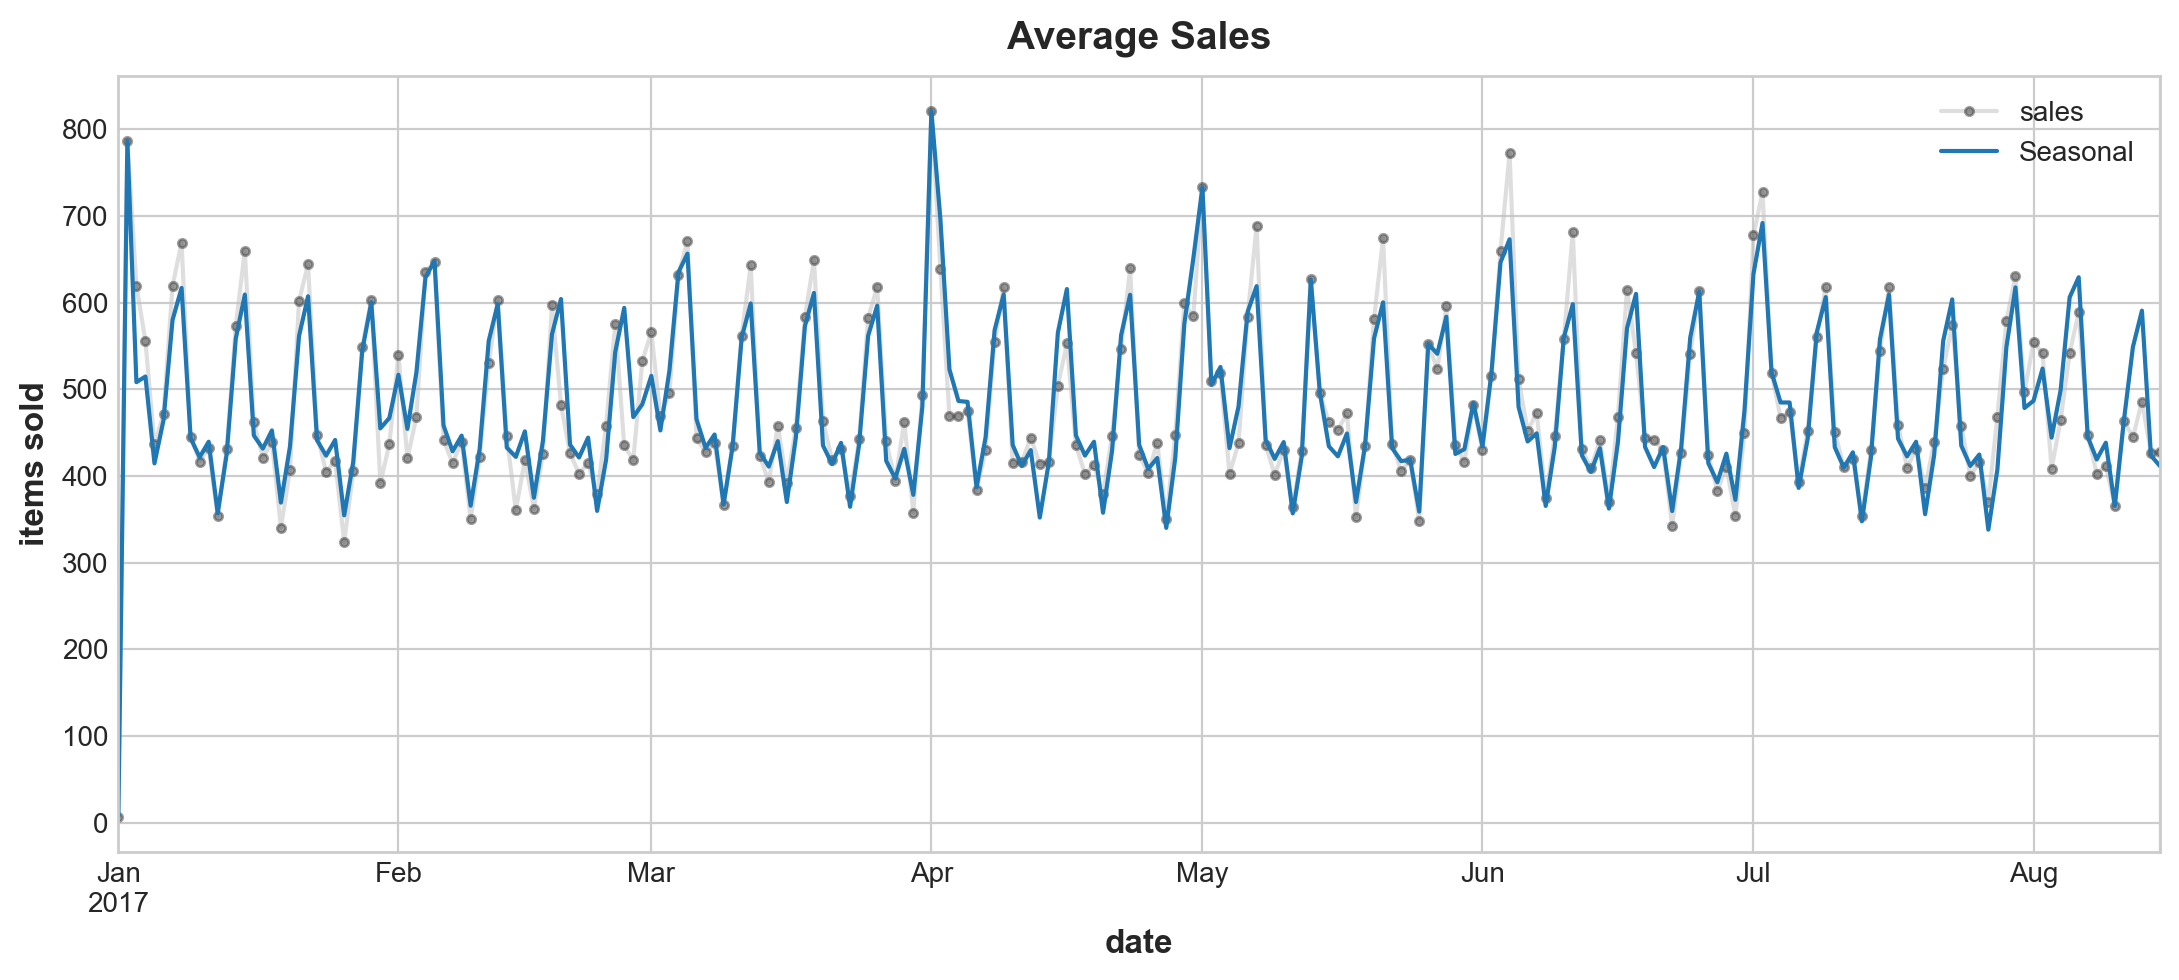

In [349]:
model = LinearRegression().fit(X2, y)
y_pred = pd.Series(
    model.predict(X2),
    index=X2.index,
    name='Fitted',
)

y_pred = pd.Series(model.predict(X2), index=X2.index)
ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Seasonal")
ax.legend();

## Cycles

One especially common way for serial dependence to manifest is in cycles. Cycles are patterns of growth and decay in a time series associated with how the value in a series at one time depends on values at previous times, but not necessarily on the time step itself. Cyclic behavior is characteristic of systems that can affect themselves or whose reactions persist over time. Economies, epidemics, animal populations, volcano eruptions, and similar natural phenomena often display cyclic behavior.

What distinguishes cyclic behavior from seasonality is that cycles are not necessarily time dependent, as seasons are. What happens in a cycle is less about the particular date of occurence, and more about what has happened in the recent past. The (at least relative) independence from time means that cyclic behavior can be much more irregular than seasonality

### Lagged Series and Lag Plots
To investigate possible serial dependence (like cycles) in a time series, we need to create "lagged" copies of the series. Lagging a time series means to shift its values forward one or more time steps, or equivalently, to shift the times in its index backward one or more steps. In either case, the effect is that the observations in the lagged series will appear to have happened later in time.

In [350]:
# Federal Reserve dataset: https://www.kaggle.com/federalreserve/interest-rates
reserve = pd.read_csv(
    "./data/reserve.csv",
    parse_dates={'Date': ['Year', 'Month', 'Day']},
    index_col='Date',
)

y = reserve.loc[:, 'Unemployment Rate'].dropna().to_period('M')
df = pd.DataFrame({
    'y': y,
    'y_lag_1': y.shift(1),
    'y_lag_2': y.shift(2),    
})

df

y  y_lag_1  y_lag_2
Date                          
1954-07  5.8      NaN      NaN
1954-08  6.0      5.8      NaN
1954-09  6.1      6.0      5.8
1954-10  5.7      6.1      6.0
1954-11  5.3      5.7      6.1
...      ...      ...      ...
2016-10  4.8      4.9      4.9
2016-11  4.6      4.8      4.9
2016-12  4.7      4.6      4.8
2017-01  4.8      4.7      4.6
2017-02  4.7      4.8      4.7

[752 rows x 3 columns]

By lagging a time series, we can make its past values appear contemporaneous with the values we are trying to predict (in the same row, in other words). This makes lagged series useful as features for modeling serial dependence. To forecast the US unemployment rate series, we could use y_lag_1 and y_lag_2 as features to predict the target y. This would forecast the future unemployment rate as a function of the unemployment rate in the prior two months.

Exarceise on the Cycles - Flu Trends

The Flu Trends dataset contains records of doctor's visits for the flu for weeks between 2009 and 2016. Our goal is to forecast the number of flu cases for the coming weeks.

We will take two approaches. In the first we'll forecast doctor's visits using lag features. Our second approach will be to forecast doctor's visits using lags of another set of time series: flu-related search terms as captured by Google Trends.

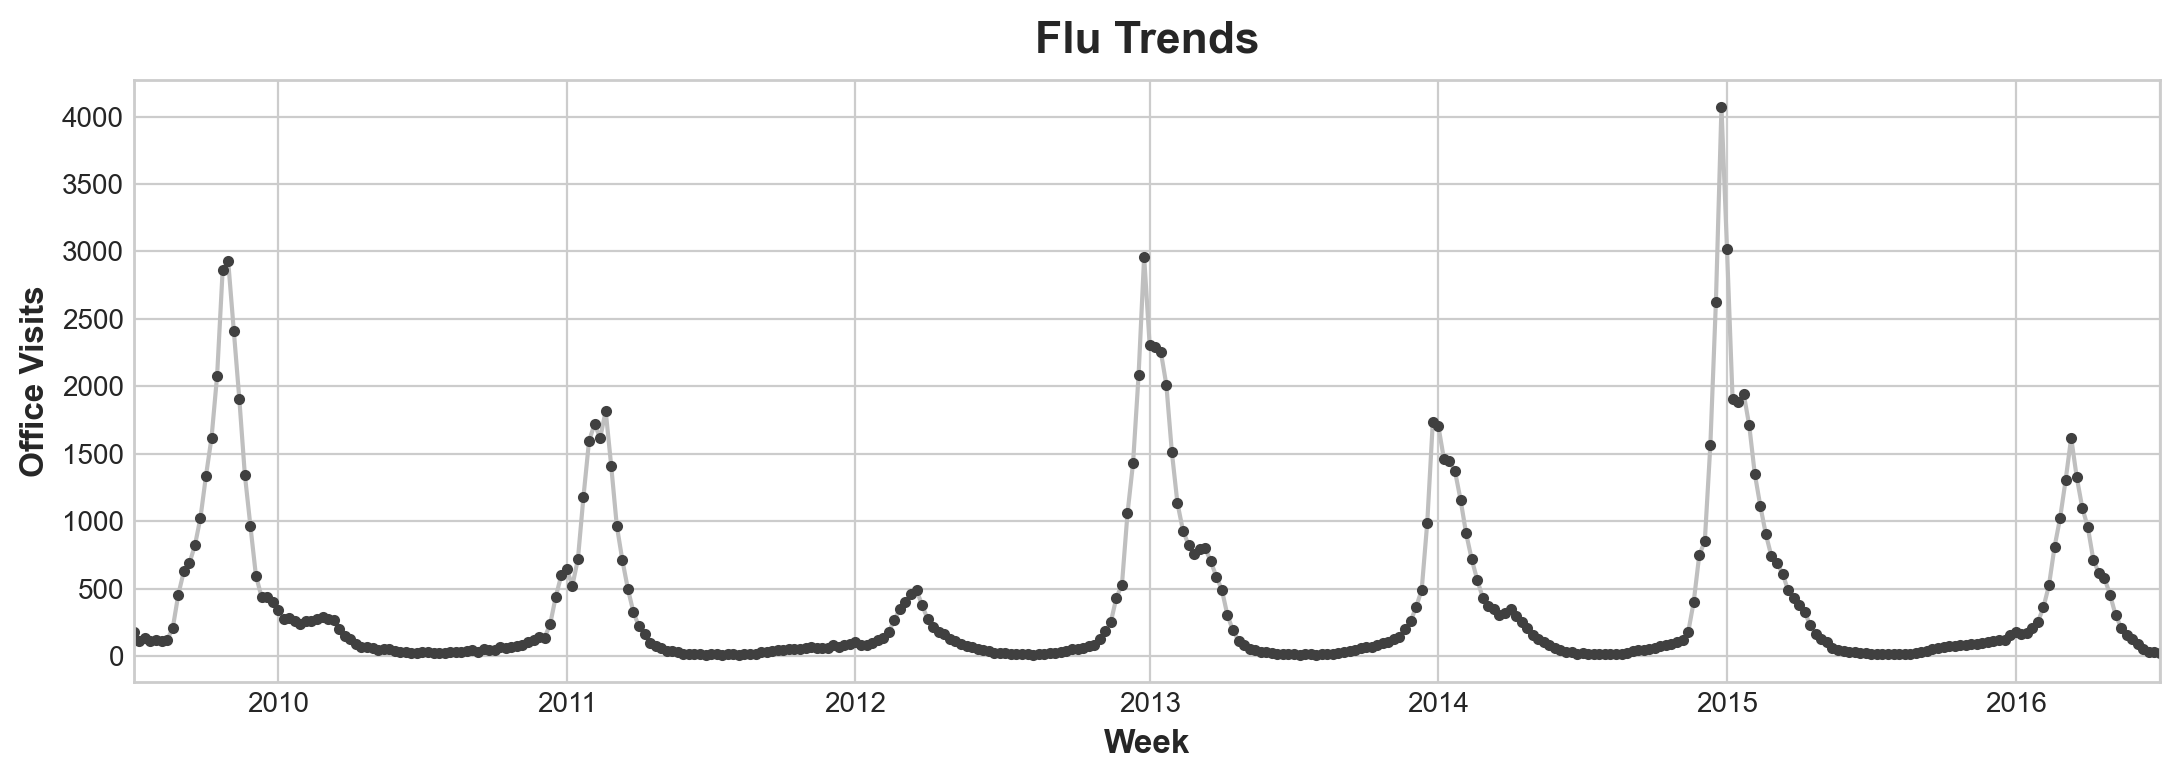

In [351]:
from pathlib import Path
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.signal import periodogram
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf

simplefilter("ignore")

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4))
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=16,
    titlepad=10,
)
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
)
%config InlineBackend.figure_format = 'retina'


def lagplot(x, y=None, lag=1, standardize=False, ax=None, **kwargs):
    from matplotlib.offsetbox import AnchoredText
    x_ = x.shift(lag)
    if standardize:
        x_ = (x_ - x_.mean()) / x_.std()
    if y is not None:
        y_ = (y - y.mean()) / y.std() if standardize else y
    else:
        y_ = x
    corr = y_.corr(x_)
    if ax is None:
        fig, ax = plt.subplots()
    scatter_kws = dict(
        alpha=0.75,
        s=3,
    )
    line_kws = dict(color='C3', )
    ax = sns.regplot(x=x_,
                     y=y_,
                     scatter_kws=scatter_kws,
                     line_kws=line_kws,
                     lowess=True,
                     ax=ax,
                     **kwargs)
    at = AnchoredText(
        f"{corr:.2f}",
        prop=dict(size="large"),
        frameon=True,
        loc="upper left",
    )
    at.patch.set_boxstyle("square, pad=0.0")
    ax.add_artist(at)
    ax.set(title=f"Lag {lag}", xlabel=x_.name, ylabel=y_.name)
    return ax


def plot_lags(x, y=None, lags=6, nrows=1, lagplot_kwargs={}, **kwargs):
    import math
    kwargs.setdefault('nrows', nrows)
    kwargs.setdefault('ncols', math.ceil(lags / nrows))
    kwargs.setdefault('figsize', (kwargs['ncols'] * 2, nrows * 2 + 0.5))
    fig, axs = plt.subplots(sharex=True, sharey=True, squeeze=False, **kwargs)
    for ax, k in zip(fig.get_axes(), range(kwargs['nrows'] * kwargs['ncols'])):
        if k + 1 <= lags:
            ax = lagplot(x, y, lag=k + 1, ax=ax, **lagplot_kwargs)
            ax.set_title(f"Lag {k + 1}", fontdict=dict(fontsize=14))
            ax.set(xlabel="", ylabel="")
        else:
            ax.axis('off')
    plt.setp(axs[-1, :], xlabel=x.name)
    plt.setp(axs[:, 0], ylabel=y.name if y is not None else x.name)
    fig.tight_layout(w_pad=0.1, h_pad=0.1)
    return fig


data_dir = Path("./data")
flu_trends = pd.read_csv(data_dir / "flu-trends.csv")
flu_trends.set_index(
    pd.PeriodIndex(flu_trends.Week, freq="W"),
    inplace=True,
)
flu_trends.drop("Week", axis=1, inplace=True)

ax = flu_trends.FluVisits.plot(title='Flu Trends', **plot_params)
_ = ax.set(ylabel="Office Visits")

Our Flu Trends data shows irregular cycles instead of a regular seasonality: the peak tends to occur around the new year, but sometimes earlier or later, sometimes larger or smaller. Modeling these cycles with lag features will allow our forecaster to react dynamically to changing conditions instead of being constrained to exact dates and times as with seasonal features.

Let's take a look at the lag and autocorrelation plots first:

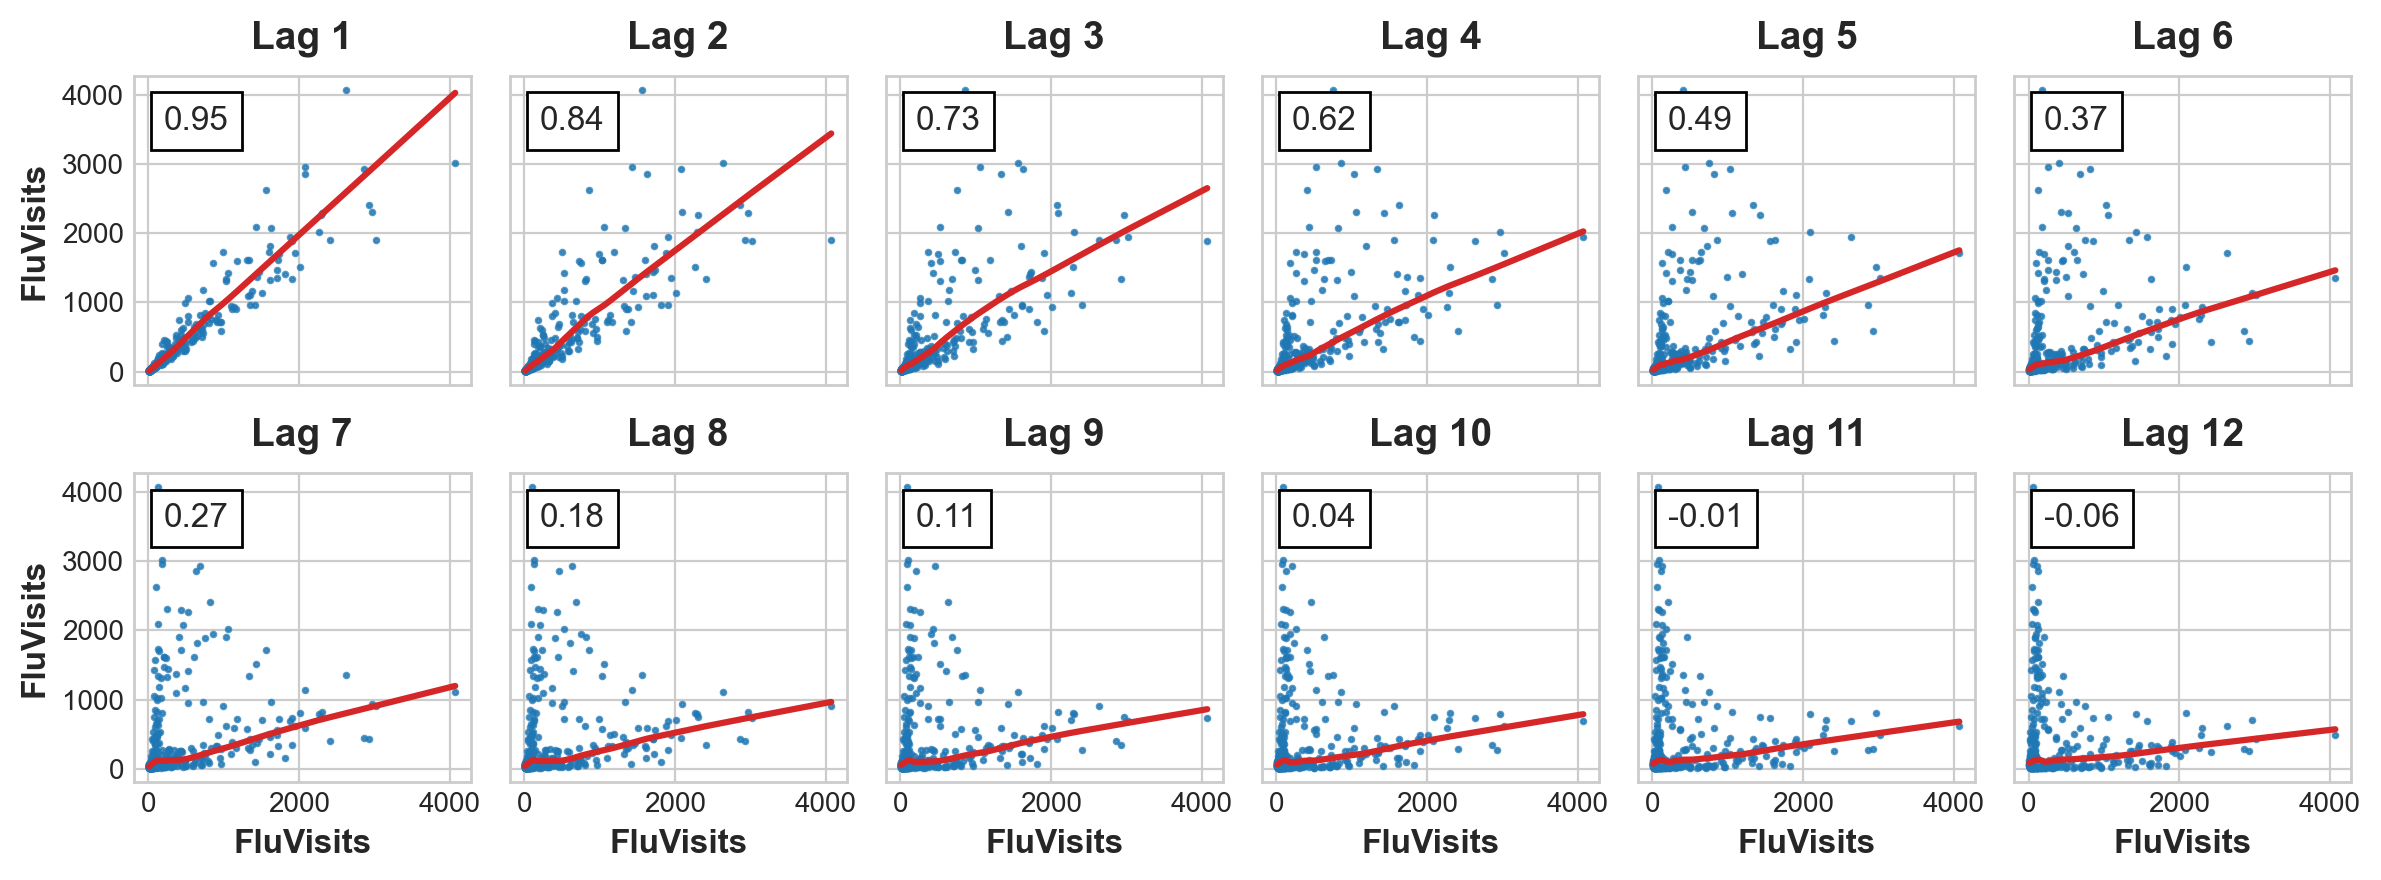

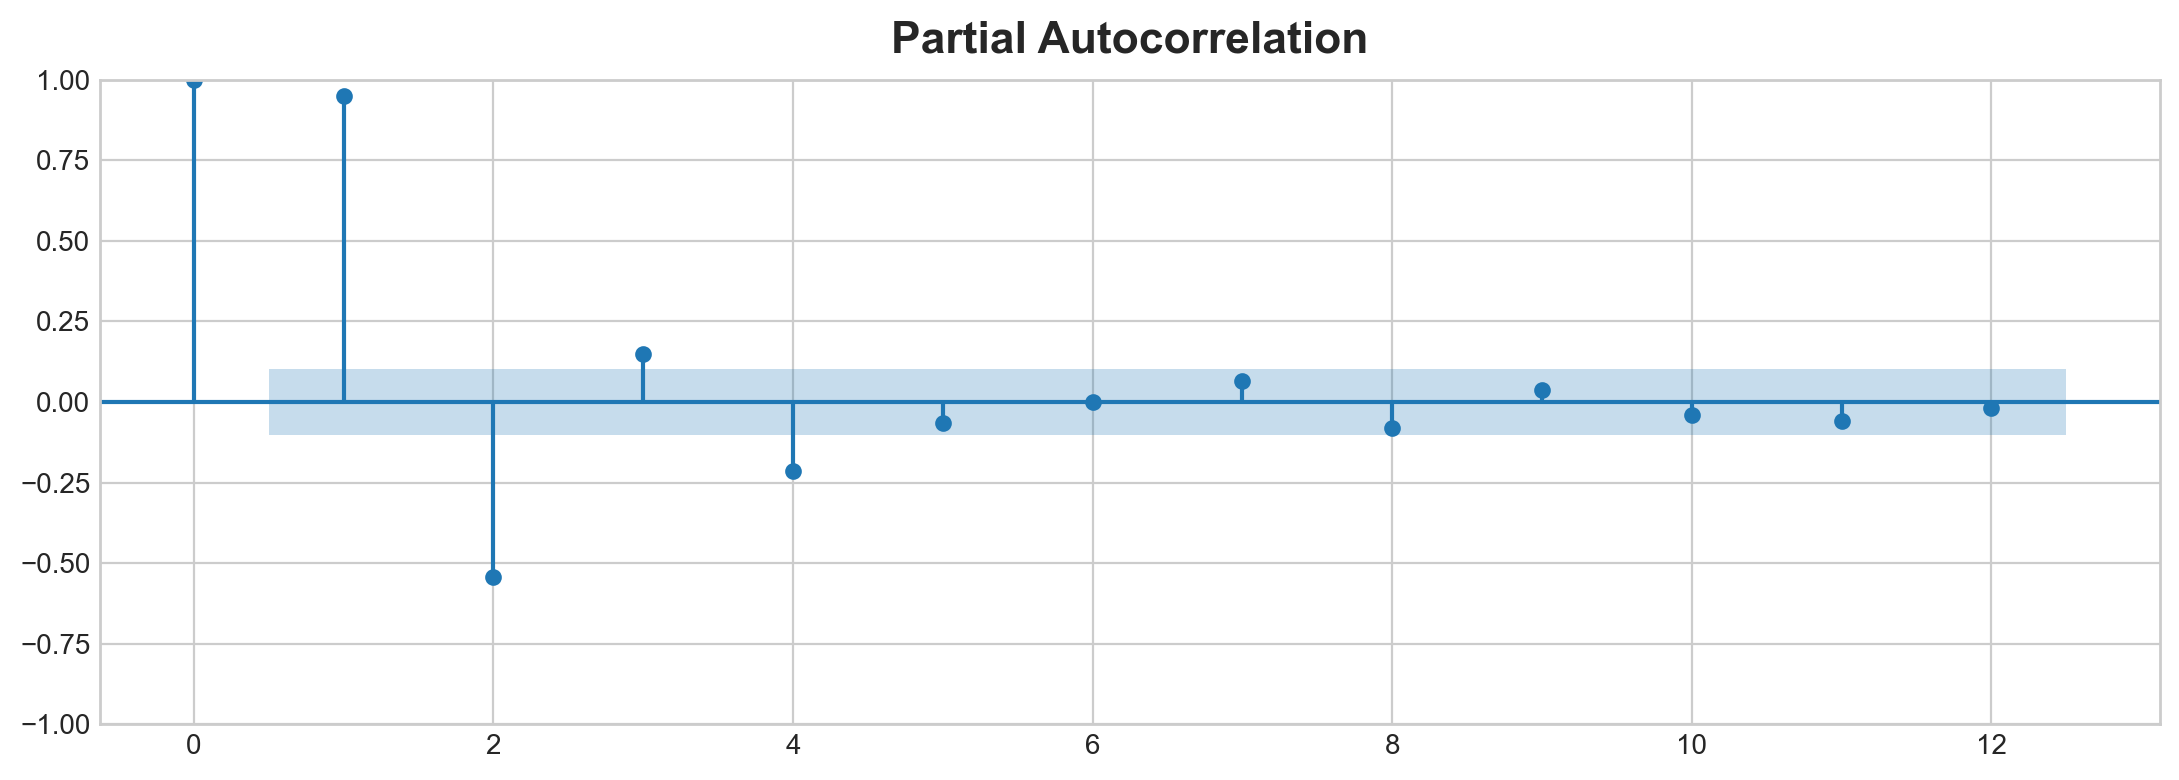

In [352]:
_ = plot_lags(flu_trends.FluVisits, lags=12, nrows=2)
_ = plot_pacf(flu_trends.FluVisits, lags=12)

The lag plots indicate that the relationship of FluVisits to its lags is mostly linear, while the partial autocorrelations suggest the dependence can be captured using lags 1, 2, 3, and 4. We can lag a time series in Pandas with the shift method. For this problem, we'll fill in the missing values the lagging creates with 0.0.

In [353]:
def make_lags(ts, lags):
    return pd.concat(
        {
            f'y_lag_{i}': ts.shift(i)
            for i in range(1, lags + 1)
        },
        axis=1)


X = make_lags(flu_trends.FluVisits, lags=4)
X = X.fillna(0.0)

In [354]:
X

y_lag_1  y_lag_2  y_lag_3  y_lag_4
Week                                                     
2009-06-29/2009-07-05      0.0      0.0      0.0      0.0
2009-07-06/2009-07-12    180.0      0.0      0.0      0.0
2009-07-13/2009-07-19    115.0    180.0      0.0      0.0
2009-07-20/2009-07-26    132.0    115.0    180.0      0.0
2009-07-27/2009-08-02    109.0    132.0    115.0    180.0
...                        ...      ...      ...      ...
2016-05-30/2016-06-05    124.0    156.0    211.0    305.0
2016-06-06/2016-06-12     90.0    124.0    156.0    211.0
2016-06-13/2016-06-19     55.0     90.0    124.0    156.0
2016-06-20/2016-06-26     33.0     55.0     90.0    124.0
2016-06-27/2016-07-03     27.0     33.0     55.0     90.0

[366 rows x 4 columns]

Let's make forecasts

In [355]:
# Create target series and data splits
y = flu_trends.FluVisits.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

# Fit and predict
model = LinearRegression()  # `fit_intercept=True` since we didn't use DeterministicProcess
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

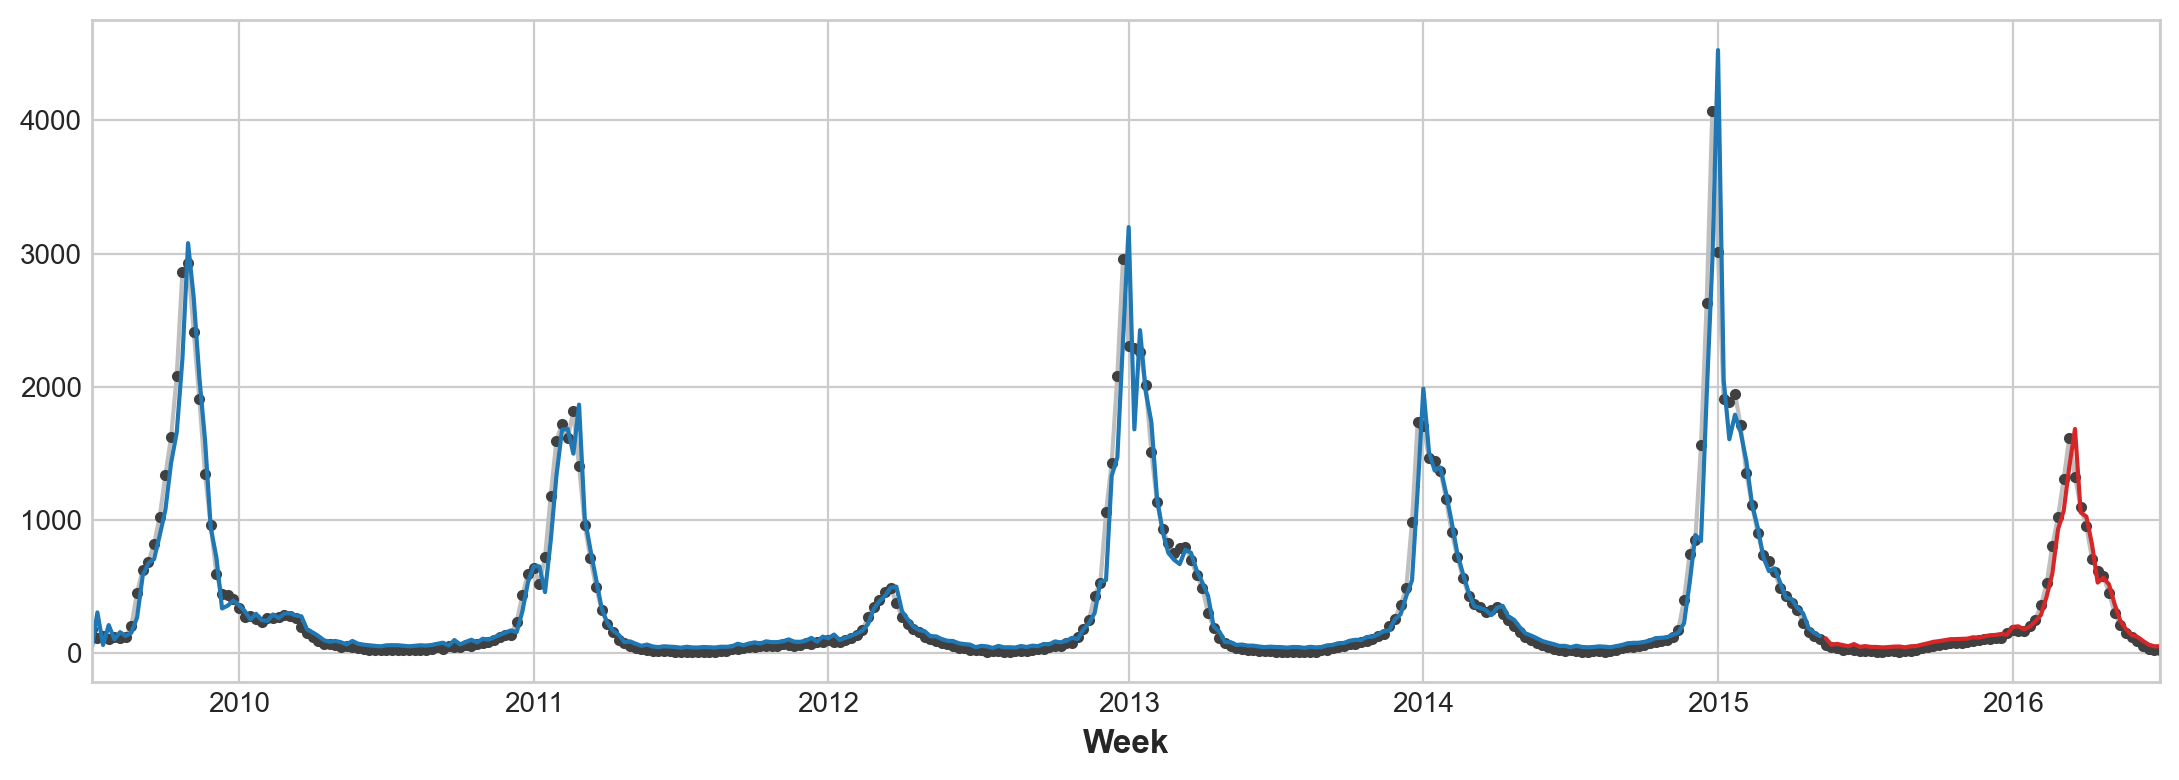

In [356]:
ax = y_train.plot(**plot_params)
ax = y_test.plot(**plot_params)
ax = y_pred.plot(ax=ax)
_ = y_fore.plot(ax=ax, color='C3')


Looking just at the forecast values, we can see how our model needs a time step to react to sudden changes in the target series. This is a common limitation of models using only lags of the target series as features.

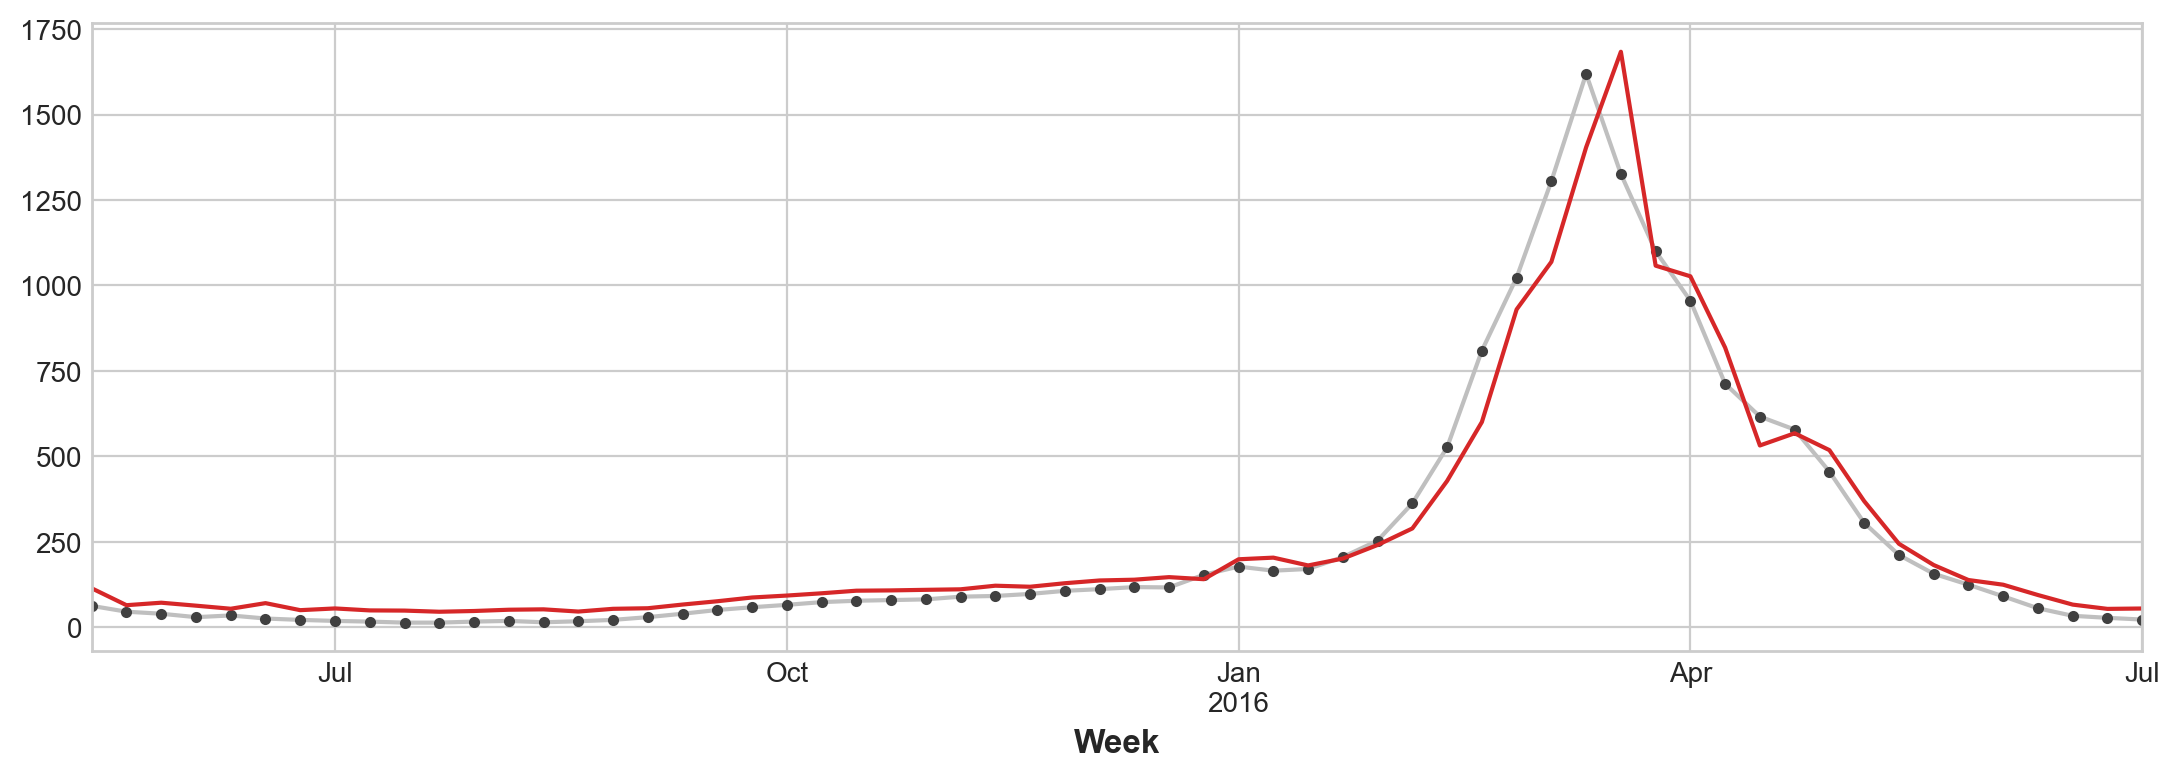

In [357]:
ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')

To improve the forecast we could try to find leading indicators, time series that could provide an "early warning" for changes in flu cases. For our second approach then we'll add to our training data the popularity of some flu-related search terms as measured by Google Trends.

Plotting the search phrase 'FluCough' against the target 'FluVisits' suggests such search terms could be useful as leading indicators: flu-related searches tend to become more popular in the weeks prior to office visits.

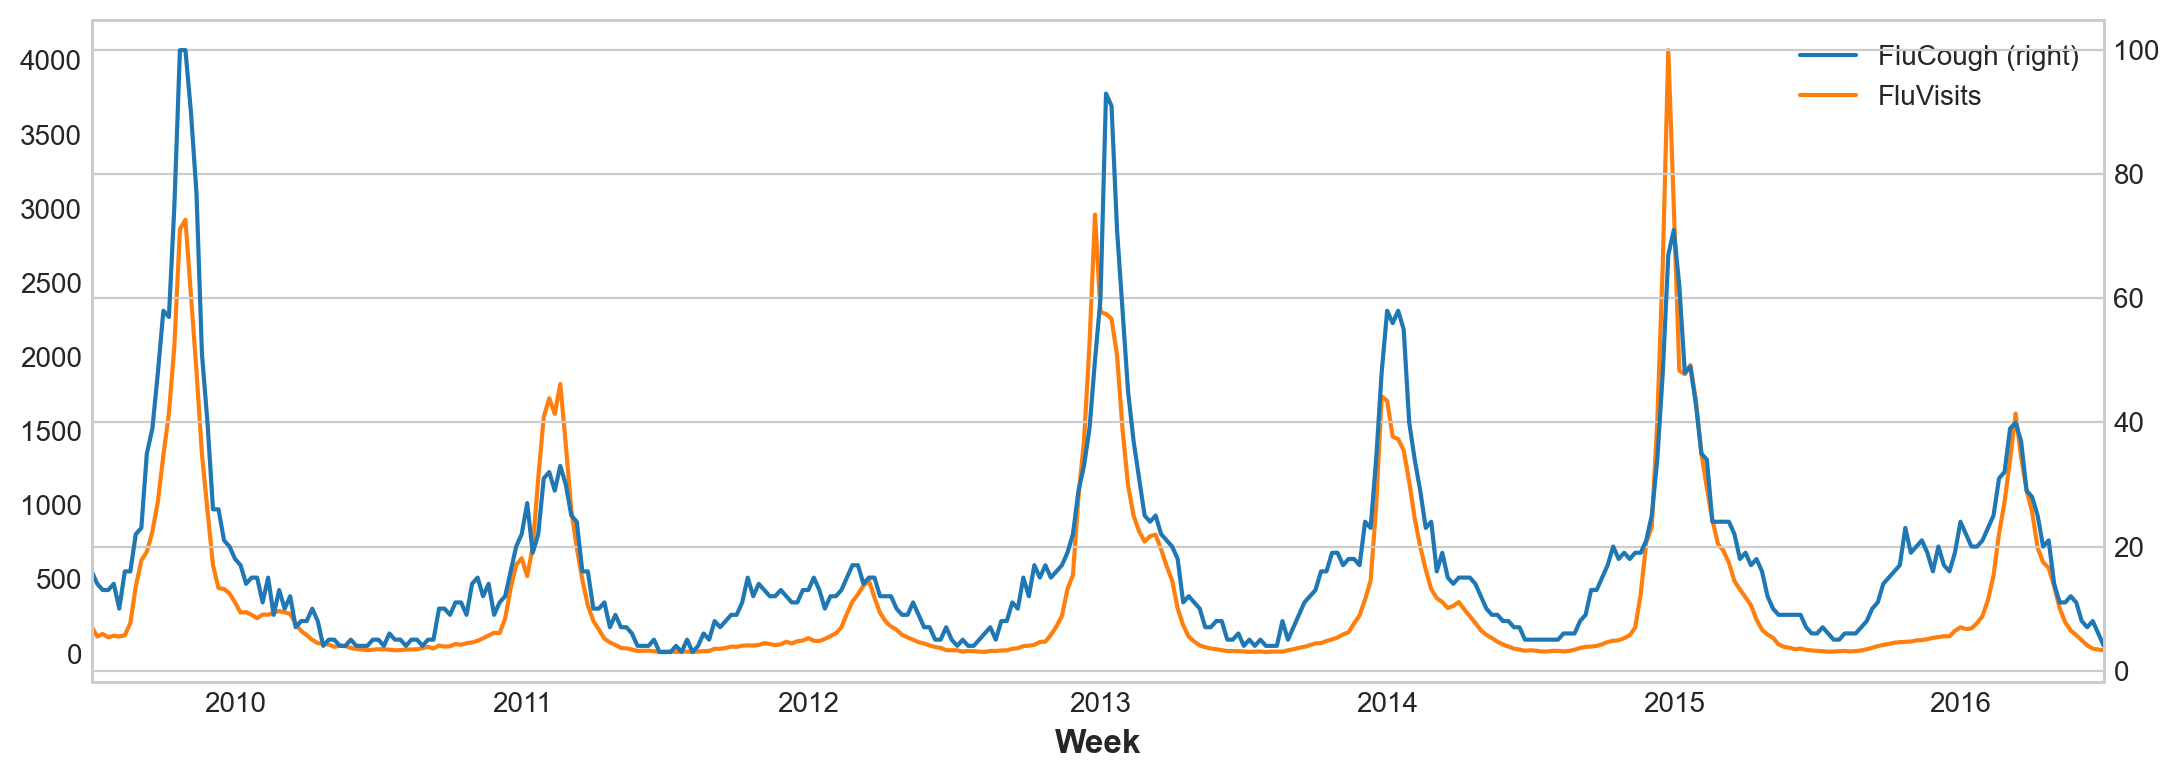

In [358]:
ax = flu_trends.plot(
    y=["FluCough", "FluVisits"],
    secondary_y="FluCough",
)

The dataset contains 129 such terms, but we'll just use a few.

In [359]:
search_terms = ["FluContagious", "FluCough", "FluFever", "InfluenzaA", "TreatFlu", "IHaveTheFlu", "OverTheCounterFlu", "HowLongFlu"]

# Create three lags for each search term
X0 = make_lags(flu_trends[search_terms], lags=3)

# Create four lags for the target, as before
X1 = make_lags(flu_trends['FluVisits'], lags=4)

# Combine to create the training data
X = pd.concat([X0, X1], axis=1).fillna(0.0)

Our forecasts are a bit rougher, but our model appears to be better able to anticipate sudden increases in flu visits, suggesting that the several time series of search popularity were indeed effective as leading indicators.

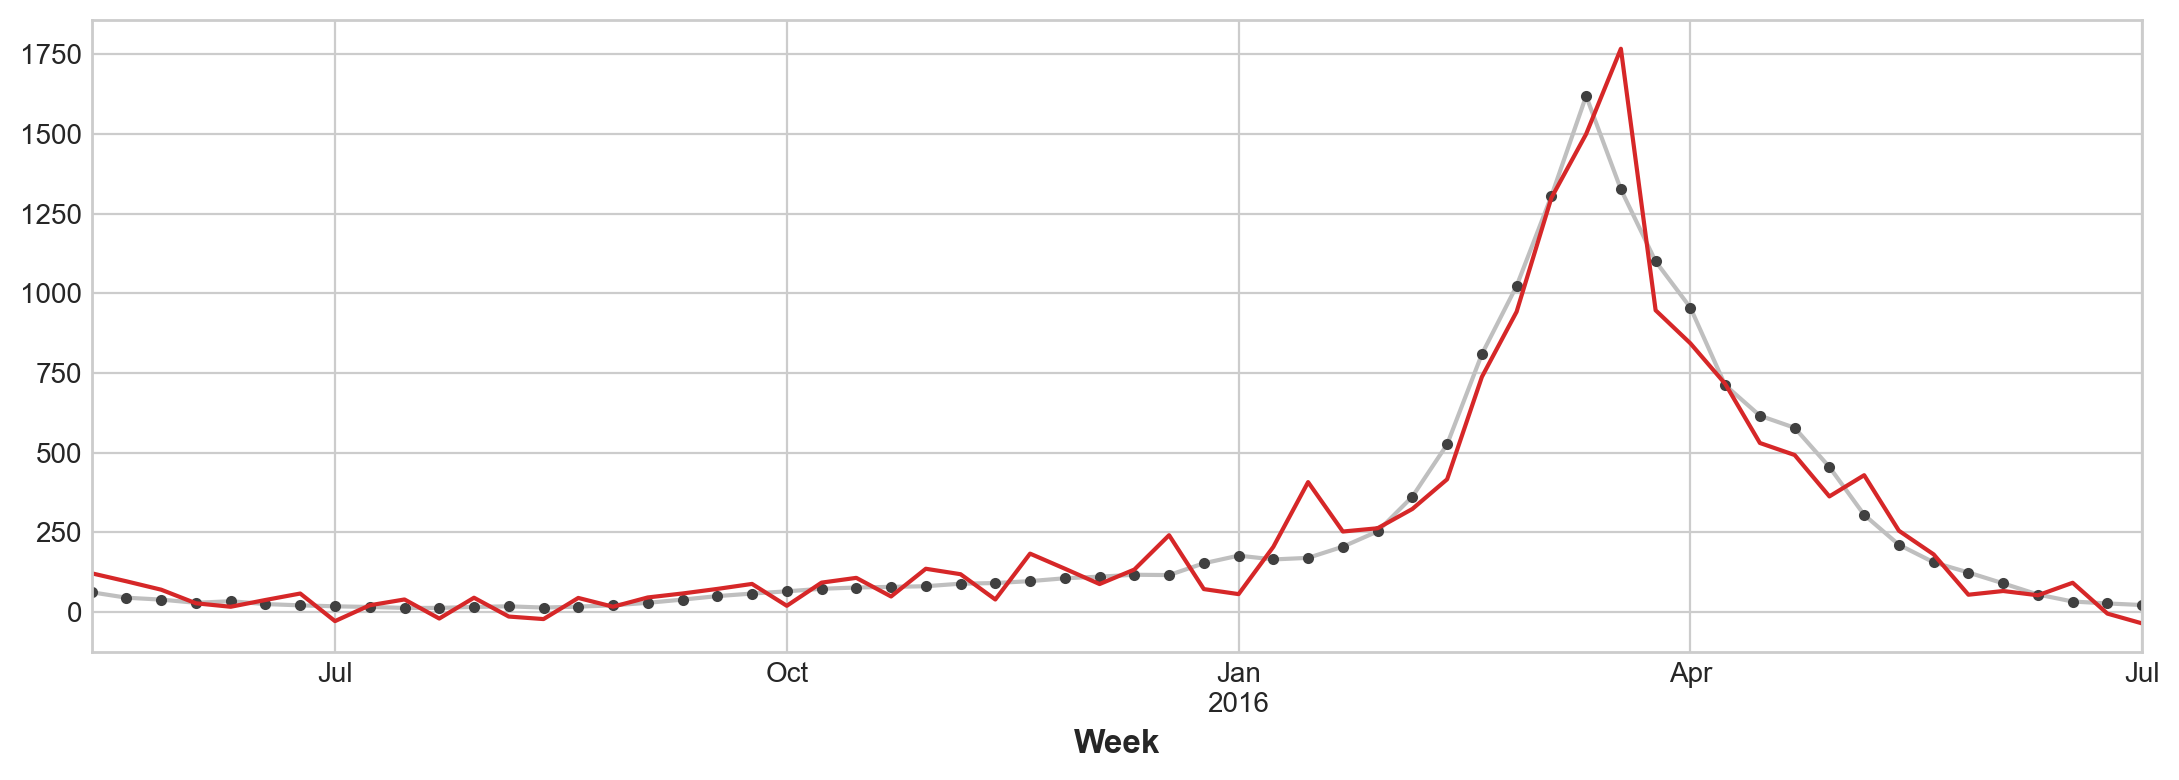

In [360]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, shuffle=False)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = pd.Series(model.predict(X_train), index=y_train.index)
y_fore = pd.Series(model.predict(X_test), index=y_test.index)

ax = y_test.plot(**plot_params)
_ = y_fore.plot(ax=ax, color='C3')



The time series illustrated in part are what you might call "purely cyclic": they have no obvious trend or seasonality. It's not uncommon though for time series to possess trend, seasonality, and cycles -- all three components at once. You could model such series with linear regression by just adding the appropriate features for each component. We can even combine models trained to learn the components separately, which we'll study further.

## Exercise on the Cycles

In [361]:
# Setup feedback system


# Setup notebook
from pathlib import Path

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess


comp_dir = Path('./data/store-sales-time-series-forecasting')

store_sales = pd.read_csv(
    comp_dir / 'train.csv',
    usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
    dtype={
        'store_nbr': 'category',
        'family': 'category',
        'sales': 'float32',
        'onpromotion': 'uint32',
    },
    parse_dates=['date'],
    infer_datetime_format=True,
)
store_sales['date'] = store_sales.date.dt.to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    store_sales
    .groupby(['family', 'date'])
    .mean() 
    .unstack('family')
    .loc['2017', ['sales', 'onpromotion']]
)


Not every product family has sales showing cyclic behavior, and neither does the series of average sales. Sales of school and office supplies, however, show patterns of growth and decay not well characterized by trend or seasons. We'll model cycles in sales of school and office supplies using lag features.

Trend and seasonality will both create serial dependence that shows up in correlograms and lag plots. To isolate any purely cyclic behavior, we'll start by deseasonalizing the series. The code in the next cell will deseasonalize Supply Sales. We'll store the result in a variable `y_deseason`.

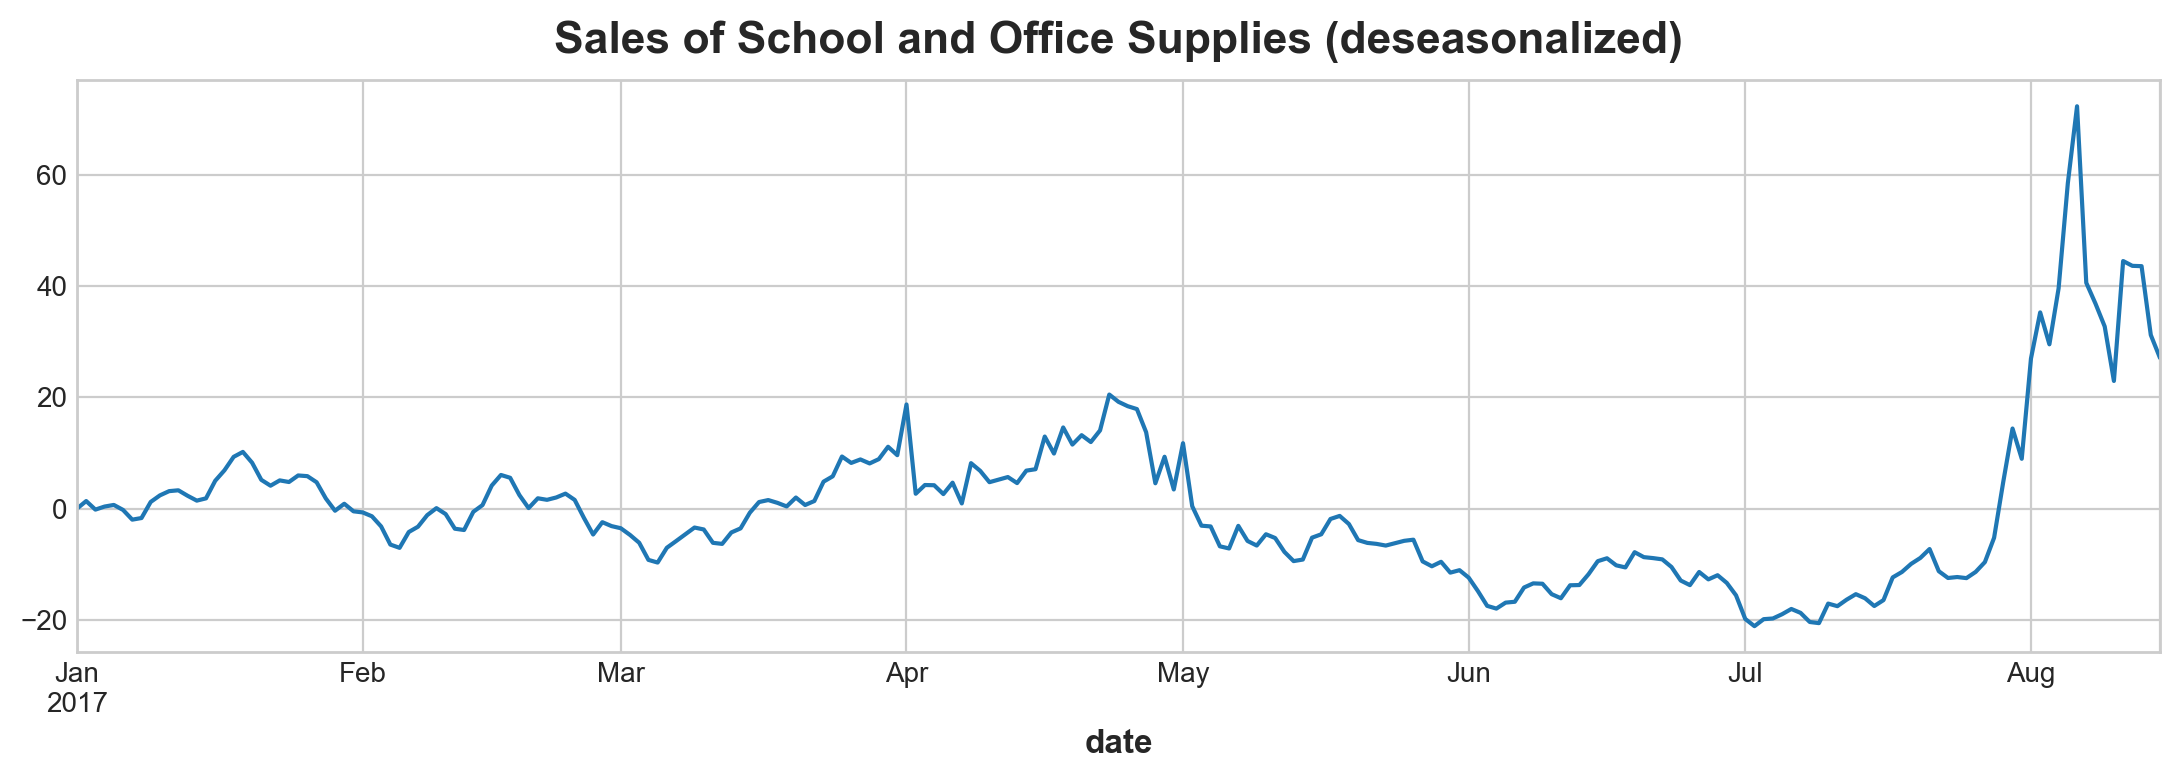

In [362]:
supply_sales = family_sales.loc(axis=1)[:, 'SCHOOL AND OFFICE SUPPLIES']
y = supply_sales.loc[:, 'sales'].squeeze()

fourier = CalendarFourier(freq='M', order=4)
dp = DeterministicProcess(
    constant=True,
    index=y.index,
    order=1,
    seasonal=True,
    drop=True,
    additional_terms=[fourier],
)
X_time = dp.in_sample()
X_time['NewYearsDay'] = (X_time.index.dayofyear == 1)

model = LinearRegression(fit_intercept=False)
model.fit(X_time, y)
y_deseason = y - model.predict(X_time)
y_deseason.name = 'sales_deseasoned'

ax = y_deseason.plot()
ax.set_title("Sales of School and Office Supplies (deseasonalized)");

Does this deseasonalized series show cyclic patterns? To confirm our intuition, we can try to isolate cyclic behavior using a moving-average plot just like we did with trend. The idea is to choose a window long enough to smooth over short-term seasonality, but short enough to still preserve the cycles.



Create a seven-day moving average from y, the series of supply sales. Use a centered window, but don't set the min_periods argument.

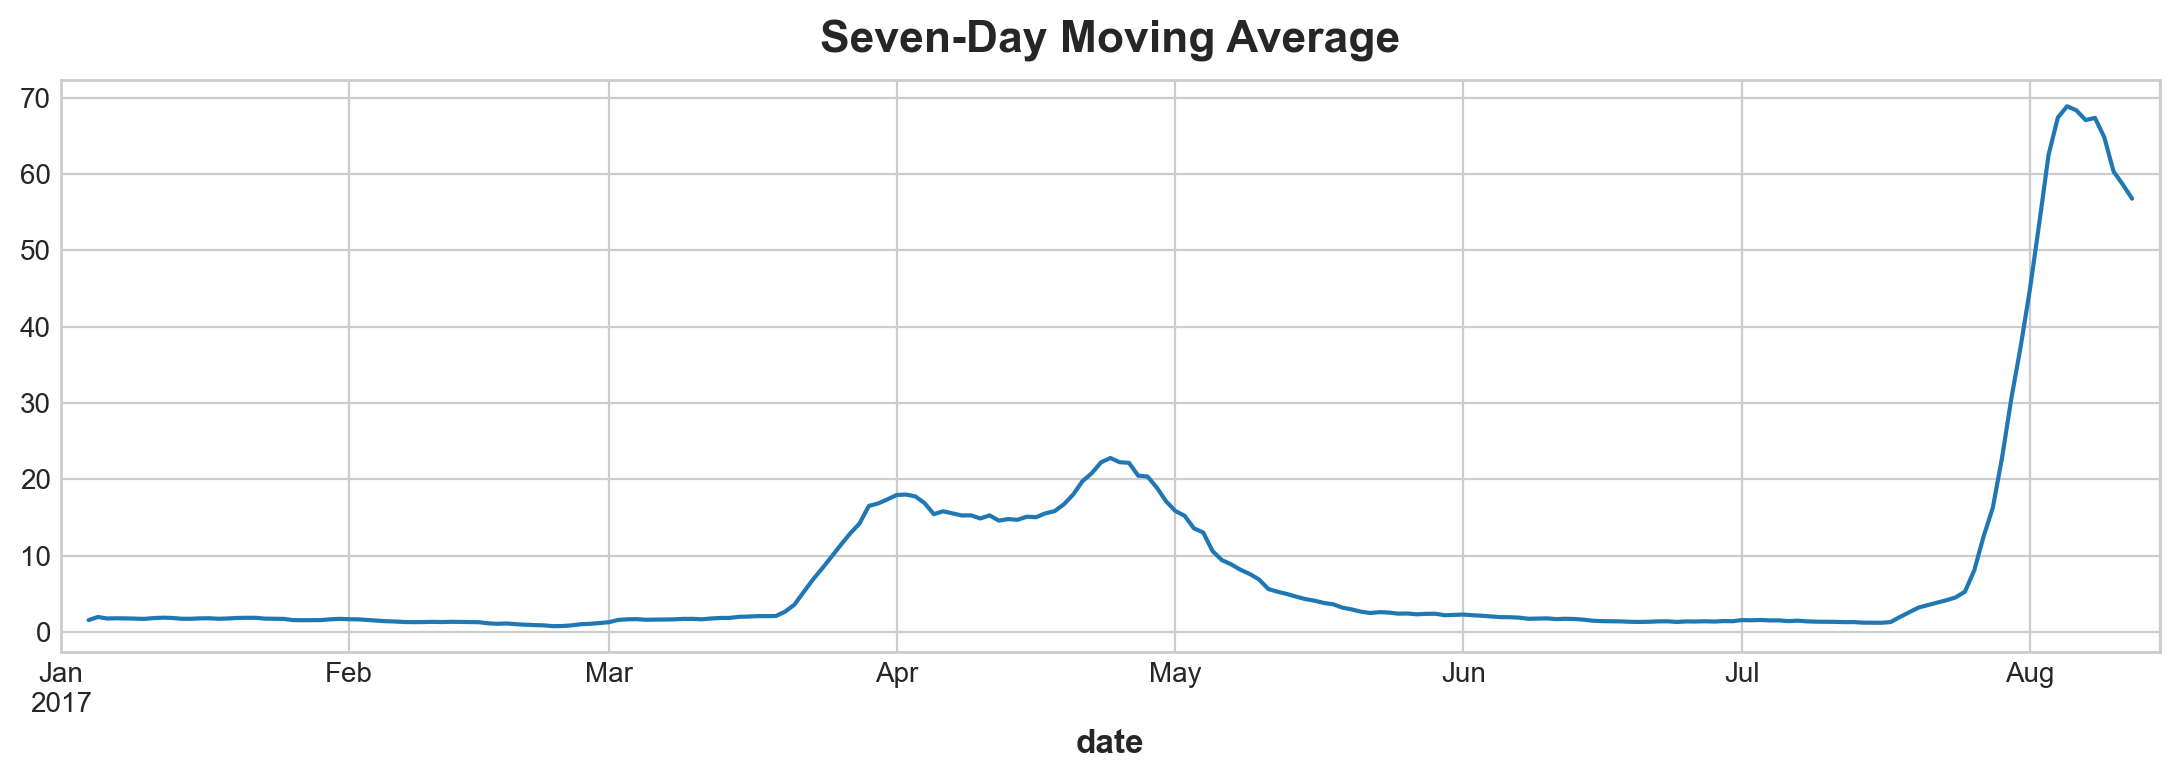

In [363]:
y_ma = y.rolling(7, center=True).mean()

ax = y_ma.plot()
ax.set_title("Seven-Day Moving Average");

In both, we can see cyclic behavior indicated.

Let's examine our deseasonalized series for serial dependence. Take a look at the partial autocorrelation correlogram and lag plot.

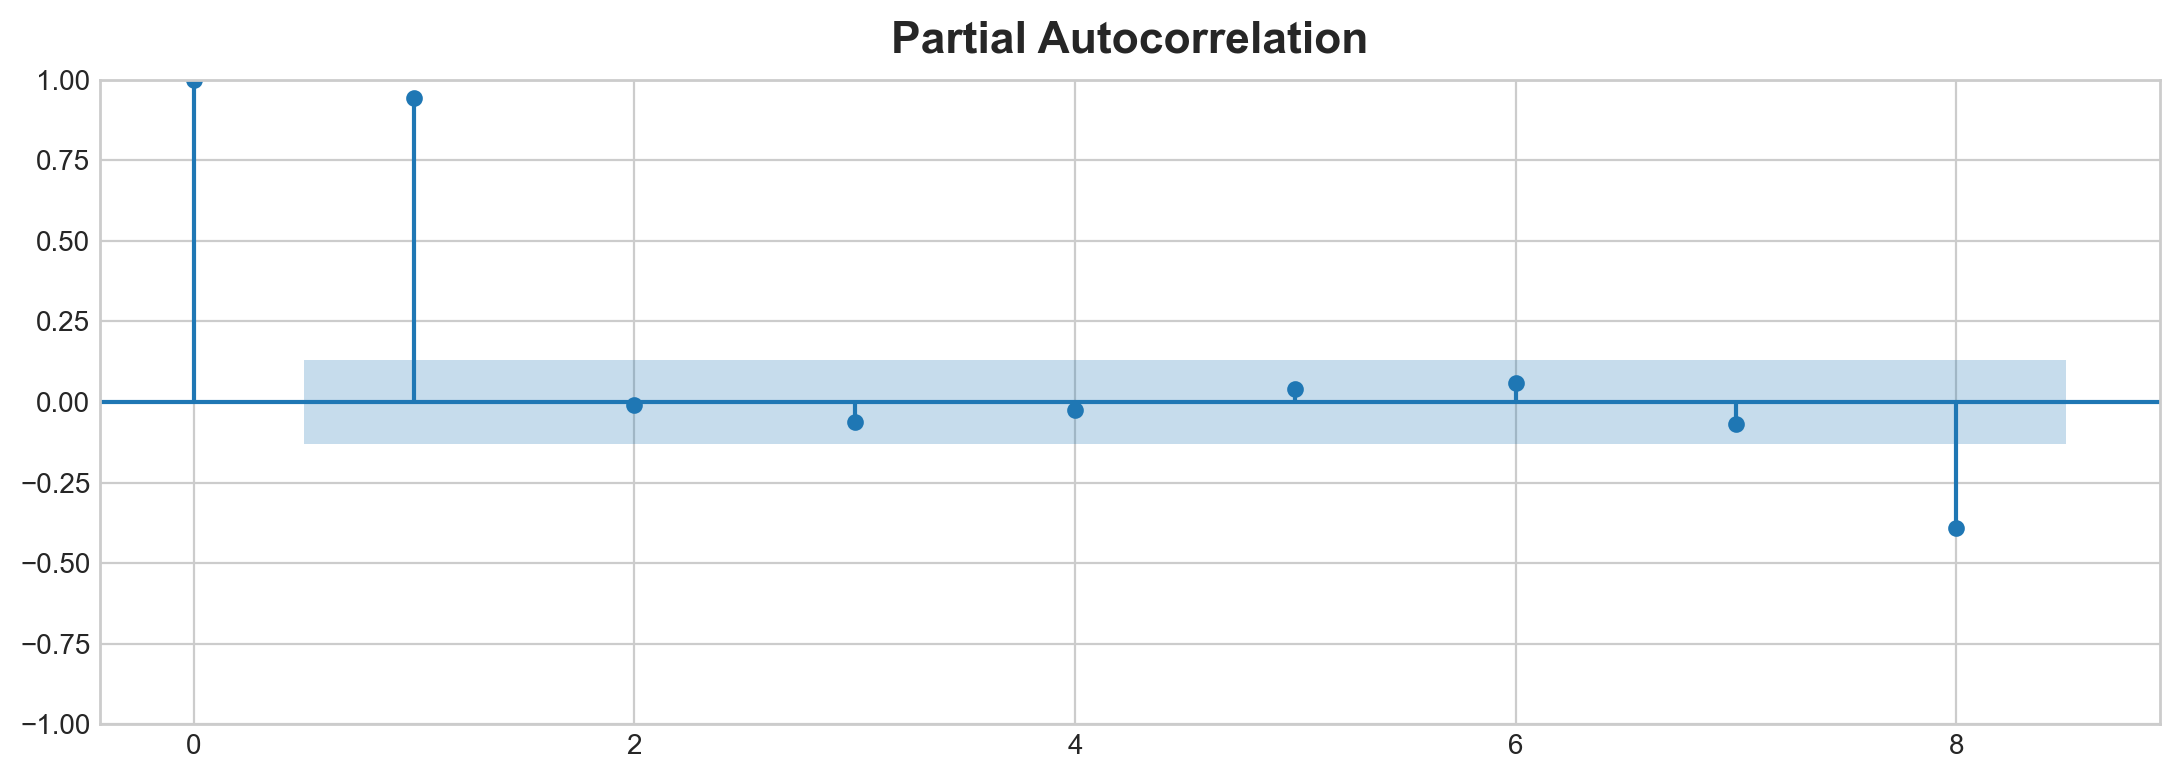

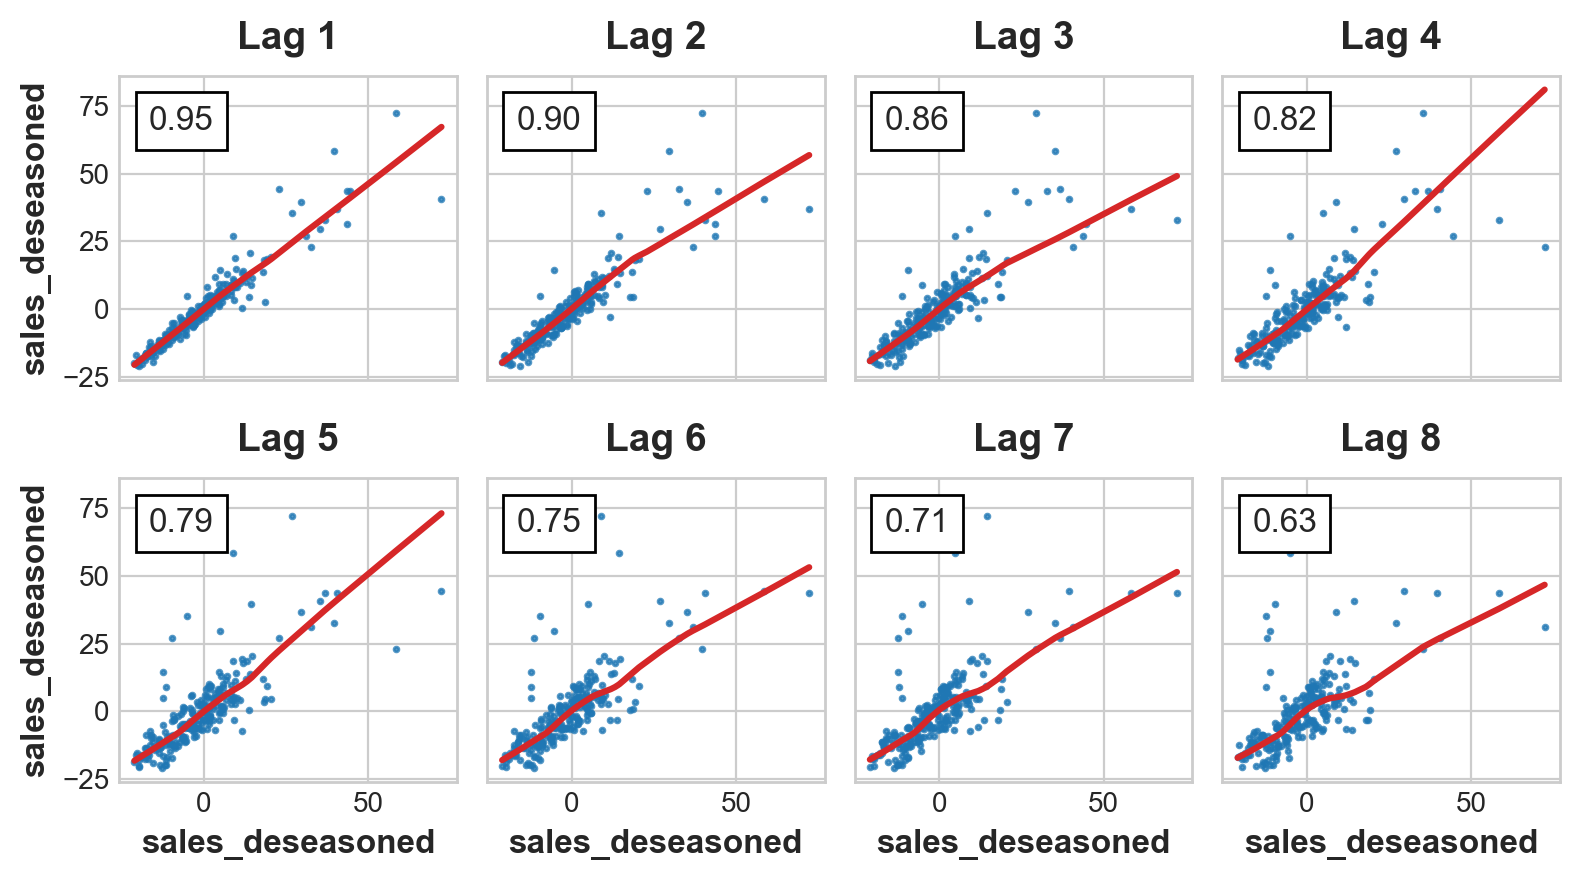

In [364]:
plot_pacf(y_deseason, lags=8);
plot_lags(y_deseason, lags=8, nrows=2);

The correlogram indicates the first lag is likely to be significant, as well as possibly the eighth lag. The lag plot suggests the effect is mostly linear.

Let's examine leading and lagging values for onpromotion plotted against sales of school and office supplies.

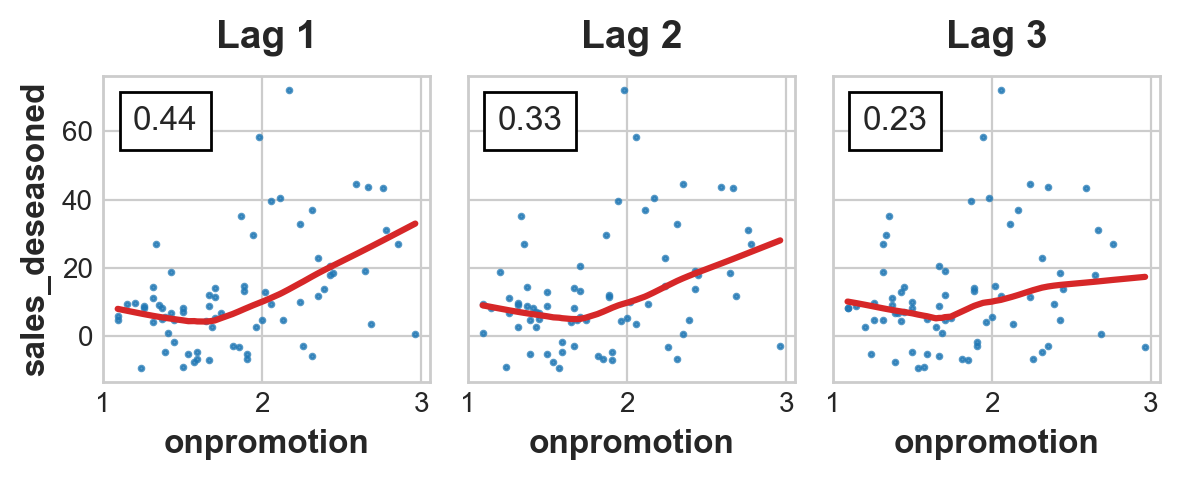

In [368]:
onpromotion = supply_sales.loc[:, 'onpromotion'].squeeze().rename('onpromotion')

# Drop days without promotions
plot_lags(x=onpromotion.loc[onpromotion > 1], y=y_deseason.loc[onpromotion > 1], lags=3, nrows=1);

Create the features indicated:

In [370]:
X_lags = make_lags(y_deseason, lags=1)

X_promo = pd.concat([
    make_lags(onpromotion, lags=1),
    onpromotion], axis=1)

X = pd.concat([X_time, X_lags, X_promo], axis=1).dropna()
y, X = y.align(X, join='inner')

Predictions from the resulting model:

Training RMSLE: 0.23893
Validation RMSLE: 0.34245


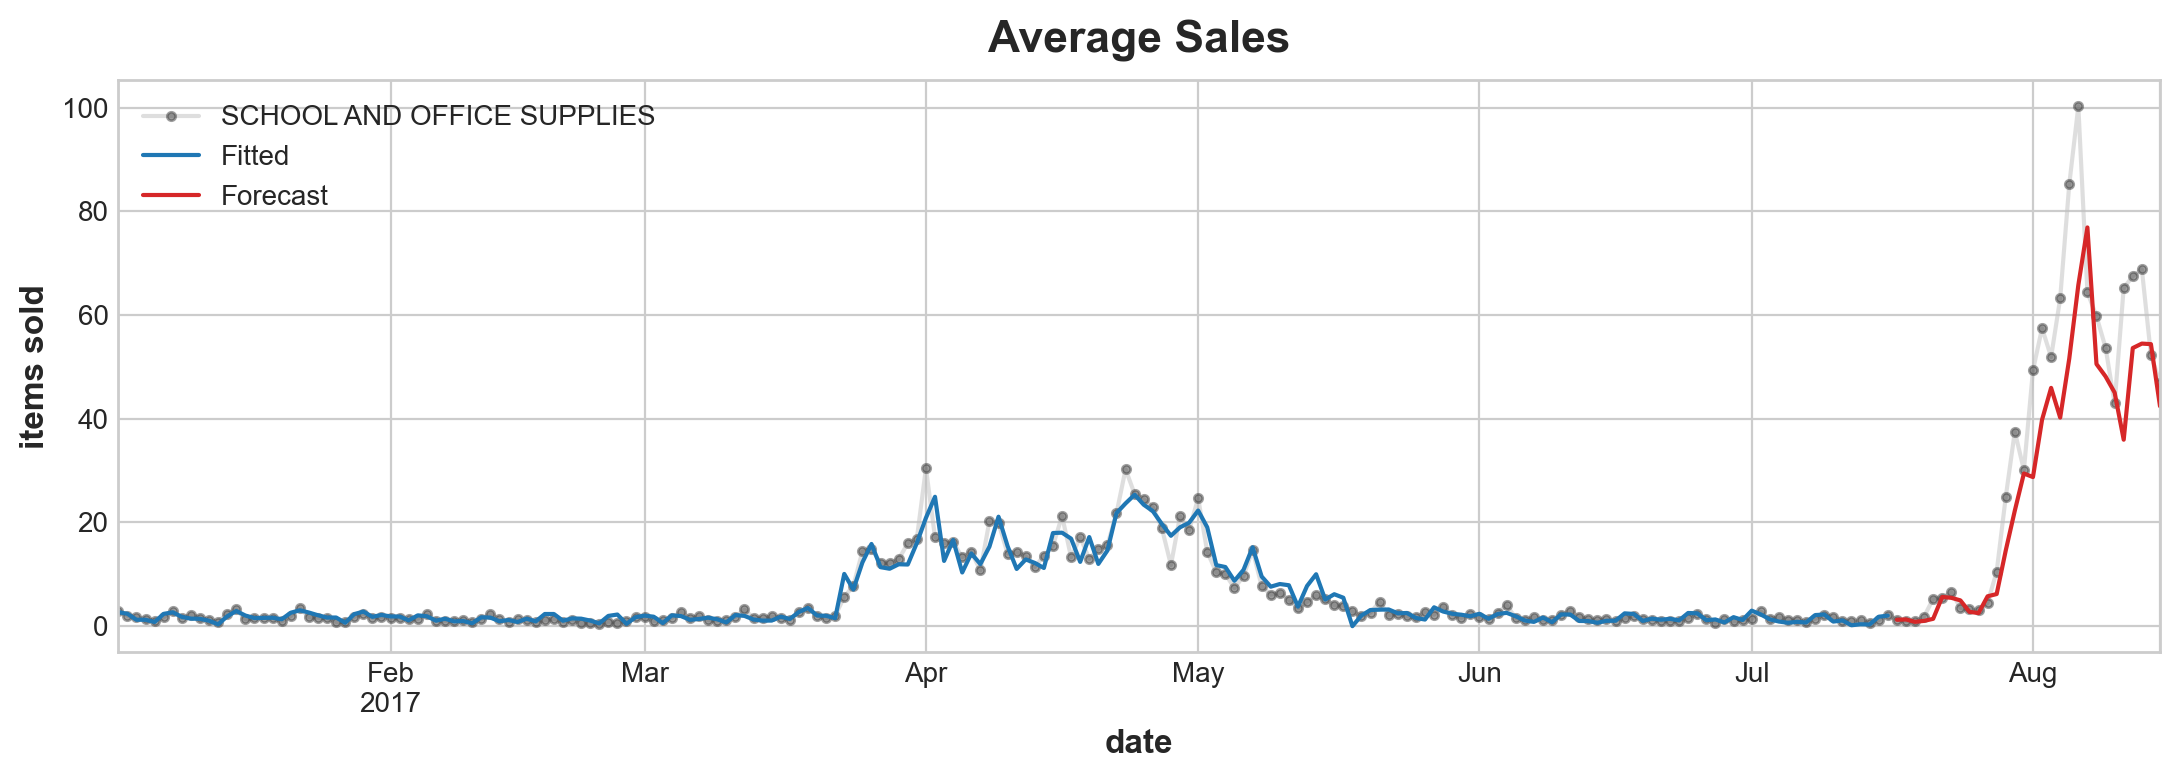

In [371]:
from sklearn.model_selection import train_test_split

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=30, shuffle=False)

model = LinearRegression(fit_intercept=False).fit(X_train, y_train)
y_fit = pd.Series(model.predict(X_train), index=X_train.index).clip(0.0)
y_pred = pd.Series(model.predict(X_valid), index=X_valid.index).clip(0.0)

rmsle_train = mean_squared_log_error(y_train, y_fit) ** 0.5
rmsle_valid = mean_squared_log_error(y_valid, y_pred) ** 0.5
print(f'Training RMSLE: {rmsle_train:.5f}')
print(f'Validation RMSLE: {rmsle_valid:.5f}')

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fit.plot(ax=ax, label="Fitted", color='C0')
ax = y_pred.plot(ax=ax, label="Forecast", color='C3')
ax.legend();